In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
weight_bit_width = 4
act_bit_width = 4
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='int',
                         scaling_impl_type='const',
                         bit_width=act_bit_width,
                         min_val=-8.0,
                         max_val=7.0, 
                         return_quant_tensor=True
                     )
        
        self.conv0 = qnn.QuantConv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = nn.SiLU()
        self.quan0 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=act_bit_width, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = qnn.QuantConv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = nn.SiLU()
        self.quan1 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=act_bit_width, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = qnn.QuantLinear(
                         input_length, 
                         hidden_0, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = nn.SiLU()
        self.quan2 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=act_bit_width, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(
                         hidden_0, 
                         output_length, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )

    def forward(self, x):
        out = self.input(x)
        out = self.pool0(self.drop0(self.quan0(self.act0(self.bn0(self.conv0(out))))))
        out = self.pool1(self.drop1(self.quan1(self.act1(self.bn1(self.conv1(out))))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.quan2(self.act2(self.bn2(self.fc2(out)))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  return F.conv2d(input, weight, bias, self.stride,
/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9641 | Val Loss: 0.0609, Acc: 0.9814


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9825 | Val Loss: 0.0486, Acc: 0.9852


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9860 | Val Loss: 0.1043, Acc: 0.9698


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.0494, Acc: 0.9860


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0502, Acc: 0.9862


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9914 | Val Loss: 0.0402, Acc: 0.9888


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0428, Acc: 0.9896


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.0497, Acc: 0.9874


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 0.0544, Acc: 0.9861


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0521, Acc: 0.9889


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0595, Acc: 0.9879


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9954 | Val Loss: 0.0587, Acc: 0.9881


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.0527, Acc: 0.9889


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0557, Acc: 0.9895


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.0623, Acc: 0.9872


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0632, Acc: 0.9880


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0626, Acc: 0.9878


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0702, Acc: 0.9874


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0665, Acc: 0.9883


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0675, Acc: 0.9875


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9968 | Val Loss: 0.0628, Acc: 0.9897


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.0737, Acc: 0.9892


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.0704, Acc: 0.9895


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9967 | Val Loss: 0.0639, Acc: 0.9892


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0711, Acc: 0.9895


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9977 | Val Loss: 0.0707, Acc: 0.9902


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0878, Acc: 0.9879


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0834, Acc: 0.9886


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.0804, Acc: 0.9878


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.0711, Acc: 0.9914


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0729, Acc: 0.9901


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9978 | Val Loss: 0.0629, Acc: 0.9921


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.0730, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.0748, Acc: 0.9901


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.0975, Acc: 0.9881


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.0920, Acc: 0.9892


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.0908, Acc: 0.9893


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.1014, Acc: 0.9896


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0873, Acc: 0.9888


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9978 | Val Loss: 0.0856, Acc: 0.9904


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9986 | Val Loss: 0.0955, Acc: 0.9889


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9983 | Val Loss: 0.1024, Acc: 0.9900


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9983 | Val Loss: 0.0997, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.0873, Acc: 0.9905


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.0842, Acc: 0.9914


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.1048, Acc: 0.9886


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.0889, Acc: 0.9901


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1071, Acc: 0.9892


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.1042, Acc: 0.9903


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1079, Acc: 0.9909


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9985 | Val Loss: 0.1094, Acc: 0.9890


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9985 | Val Loss: 0.0916, Acc: 0.9909


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 0.1233, Acc: 0.9882


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.0965, Acc: 0.9914


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9987 | Val Loss: 0.1073, Acc: 0.9901


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9986 | Val Loss: 0.1101, Acc: 0.9911


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.1149, Acc: 0.9896


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9986 | Val Loss: 0.1051, Acc: 0.9898


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9989 | Val Loss: 0.1110, Acc: 0.9905


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.1172, Acc: 0.9892


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.1171, Acc: 0.9896


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9992 | Val Loss: 0.1259, Acc: 0.9906


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.1286, Acc: 0.9882


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1372, Acc: 0.9893


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.1383, Acc: 0.9885


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9990 | Val Loss: 0.1066, Acc: 0.9915


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1233, Acc: 0.9901


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9989 | Val Loss: 0.1298, Acc: 0.9896


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9988 | Val Loss: 0.1277, Acc: 0.9905


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9990 | Val Loss: 0.1314, Acc: 0.9908


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9988 | Val Loss: 0.1155, Acc: 0.9906


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9990 | Val Loss: 0.1607, Acc: 0.9888


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9989 | Val Loss: 0.1338, Acc: 0.9902


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 0.1385, Acc: 0.9909


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9992 | Val Loss: 0.1202, Acc: 0.9912


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1332, Acc: 0.9893


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9987 | Val Loss: 0.1400, Acc: 0.9904


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1111, Acc: 0.9916


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.1176, Acc: 0.9907


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.1242, Acc: 0.9909


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9989 | Val Loss: 0.1167, Acc: 0.9899


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9992 | Val Loss: 0.1295, Acc: 0.9898


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9989 | Val Loss: 0.1257, Acc: 0.9908


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9990 | Val Loss: 0.1226, Acc: 0.9910


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.1592, Acc: 0.9894


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.1439, Acc: 0.9898


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.1588, Acc: 0.9902


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9988 | Val Loss: 0.1595, Acc: 0.9890


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9993 | Val Loss: 0.1581, Acc: 0.9901


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9990 | Val Loss: 0.1556, Acc: 0.9902


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9989 | Val Loss: 0.1613, Acc: 0.9894


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9988 | Val Loss: 0.1770, Acc: 0.9892


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9991 | Val Loss: 0.1457, Acc: 0.9898


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9994 | Val Loss: 0.1445, Acc: 0.9895


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9992 | Val Loss: 0.1439, Acc: 0.9910


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9991 | Val Loss: 0.1419, Acc: 0.9904


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9991 | Val Loss: 0.1544, Acc: 0.9899


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9991 | Val Loss: 0.1469, Acc: 0.9891


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9992 | Val Loss: 0.1543, Acc: 0.9895


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9990 | Val Loss: 0.1473, Acc: 0.9908


Final Test Loss: 0.1570 Accuracy: 0.9892


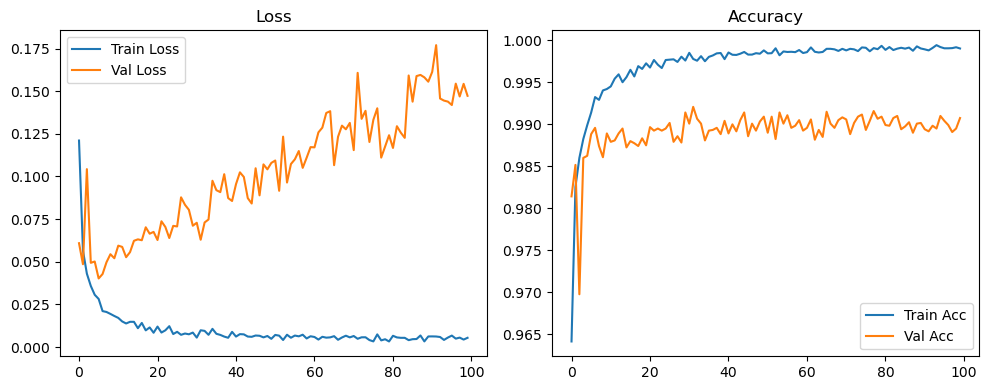

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9570 | Val Loss: 0.1281, Acc: 0.9611


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9778 | Val Loss: 0.0734, Acc: 0.9770


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9812 | Val Loss: 0.0559, Acc: 0.9822


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9829 | Val Loss: 0.0589, Acc: 0.9817


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9847 | Val Loss: 0.0474, Acc: 0.9852


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0852, Acc: 0.9738


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9874 | Val Loss: 0.0630, Acc: 0.9811


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0609, Acc: 0.9818


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9886 | Val Loss: 0.0502, Acc: 0.9853


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9892 | Val Loss: 0.0537, Acc: 0.9848


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0574, Acc: 0.9829


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0487, Acc: 0.9866


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9907 | Val Loss: 0.0613, Acc: 0.9835


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0555, Acc: 0.9858


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9914 | Val Loss: 0.0507, Acc: 0.9848


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9920 | Val Loss: 0.0484, Acc: 0.9865


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9921 | Val Loss: 0.0491, Acc: 0.9857


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0588, Acc: 0.9845


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.0502, Acc: 0.9878


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9933 | Val Loss: 0.0594, Acc: 0.9837


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9933 | Val Loss: 0.0582, Acc: 0.9844


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0495, Acc: 0.9874


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0507, Acc: 0.9886


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9935 | Val Loss: 0.0487, Acc: 0.9878


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9937 | Val Loss: 0.0654, Acc: 0.9839


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0693, Acc: 0.9832


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9941 | Val Loss: 0.0675, Acc: 0.9840


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9949 | Val Loss: 0.0502, Acc: 0.9877


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9944 | Val Loss: 0.0527, Acc: 0.9870


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9949 | Val Loss: 0.0602, Acc: 0.9870


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9940 | Val Loss: 0.0620, Acc: 0.9860


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.0765, Acc: 0.9824


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.0606, Acc: 0.9868


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.0569, Acc: 0.9873


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.0740, Acc: 0.9830


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.0724, Acc: 0.9842


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9952 | Val Loss: 0.0648, Acc: 0.9861


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.0578, Acc: 0.9858


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.0572, Acc: 0.9862


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9958 | Val Loss: 0.0501, Acc: 0.9886


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9955 | Val Loss: 0.0631, Acc: 0.9866


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9959 | Val Loss: 0.0608, Acc: 0.9864


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9955 | Val Loss: 0.0577, Acc: 0.9870


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9958 | Val Loss: 0.0646, Acc: 0.9878


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9954 | Val Loss: 0.0794, Acc: 0.9830


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.0600, Acc: 0.9876


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.0782, Acc: 0.9844


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.0633, Acc: 0.9875


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9957 | Val Loss: 0.0626, Acc: 0.9861


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.0581, Acc: 0.9887


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.0601, Acc: 0.9875


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9961 | Val Loss: 0.0566, Acc: 0.9875


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9961 | Val Loss: 0.0743, Acc: 0.9851


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9964 | Val Loss: 0.0567, Acc: 0.9888


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9967 | Val Loss: 0.0588, Acc: 0.9882


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9965 | Val Loss: 0.0693, Acc: 0.9845


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9966 | Val Loss: 0.0616, Acc: 0.9875


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9965 | Val Loss: 0.0568, Acc: 0.9896


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.0699, Acc: 0.9888


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9965 | Val Loss: 0.0730, Acc: 0.9872


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9964 | Val Loss: 0.0773, Acc: 0.9862


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9957 | Val Loss: 0.0643, Acc: 0.9880


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9966 | Val Loss: 0.0593, Acc: 0.9896


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.0648, Acc: 0.9871


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0650, Acc: 0.9870


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9964 | Val Loss: 0.0597, Acc: 0.9878


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9968 | Val Loss: 0.0503, Acc: 0.9902


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9969 | Val Loss: 0.0647, Acc: 0.9866


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9961 | Val Loss: 0.0663, Acc: 0.9858


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.0633, Acc: 0.9869


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9971 | Val Loss: 0.0835, Acc: 0.9816


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9967 | Val Loss: 0.0736, Acc: 0.9854


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9970 | Val Loss: 0.0582, Acc: 0.9878


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9969 | Val Loss: 0.0631, Acc: 0.9872


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.0740, Acc: 0.9868


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9969 | Val Loss: 0.0569, Acc: 0.9890


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.0639, Acc: 0.9864


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9972 | Val Loss: 0.0588, Acc: 0.9875


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.0692, Acc: 0.9873


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9968 | Val Loss: 0.0704, Acc: 0.9852


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9971 | Val Loss: 0.0654, Acc: 0.9888


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9971 | Val Loss: 0.0601, Acc: 0.9878


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9971 | Val Loss: 0.0661, Acc: 0.9870


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9976 | Val Loss: 0.0627, Acc: 0.9871


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9972 | Val Loss: 0.0651, Acc: 0.9896


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9972 | Val Loss: 0.0683, Acc: 0.9869


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9971 | Val Loss: 0.0605, Acc: 0.9871


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.0667, Acc: 0.9873


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9976 | Val Loss: 0.0662, Acc: 0.9872


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9975 | Val Loss: 0.0695, Acc: 0.9869


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9978 | Val Loss: 0.0709, Acc: 0.9869


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9971 | Val Loss: 0.0702, Acc: 0.9878


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9972 | Val Loss: 0.0689, Acc: 0.9855


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9975 | Val Loss: 0.0658, Acc: 0.9880


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9977 | Val Loss: 0.0898, Acc: 0.9839


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9970 | Val Loss: 0.0777, Acc: 0.9860


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9974 | Val Loss: 0.0630, Acc: 0.9882


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9974 | Val Loss: 0.0562, Acc: 0.9898


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9976 | Val Loss: 0.0574, Acc: 0.9872


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.0604, Acc: 0.9880


Final Test Loss: 0.0681 Accuracy: 0.9875


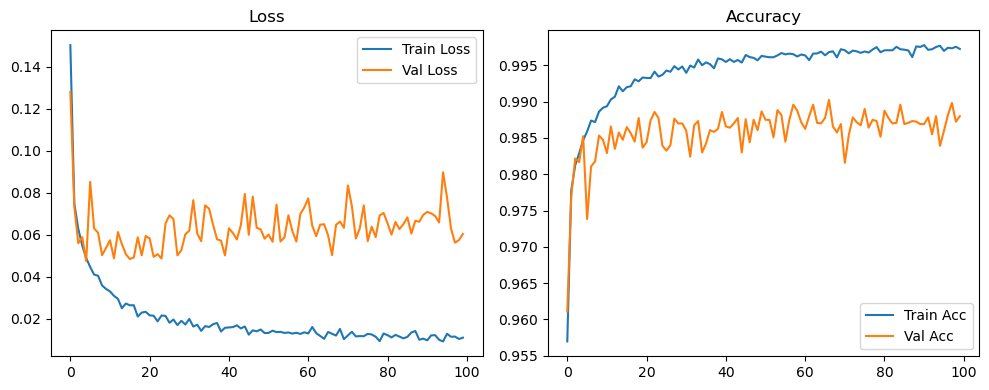

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2535, Acc: 0.9259 | Val Loss: 0.9894, Acc: 0.6667


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1484, Acc: 0.9568 | Val Loss: 0.5314, Acc: 0.8193


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9623 | Val Loss: 0.5046, Acc: 0.8122


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9658 | Val Loss: 0.2129, Acc: 0.9317


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1091, Acc: 0.9679 | Val Loss: 0.2737, Acc: 0.9078


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9688 | Val Loss: 0.2760, Acc: 0.8993


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9706 | Val Loss: 0.2516, Acc: 0.9150


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9704 | Val Loss: 0.2487, Acc: 0.9187


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9730 | Val Loss: 0.2833, Acc: 0.9031


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9740 | Val Loss: 0.1853, Acc: 0.9383


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9743 | Val Loss: 0.1793, Acc: 0.9417


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9741 | Val Loss: 0.1962, Acc: 0.9299


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9755 | Val Loss: 0.2479, Acc: 0.9039


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0815, Acc: 0.9759 | Val Loss: 0.1680, Acc: 0.9450


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9776 | Val Loss: 0.1861, Acc: 0.9387


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9779 | Val Loss: 0.1476, Acc: 0.9494


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9774 | Val Loss: 0.1898, Acc: 0.9333


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9779 | Val Loss: 0.1927, Acc: 0.9352


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9795 | Val Loss: 0.1620, Acc: 0.9477


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9783 | Val Loss: 0.1689, Acc: 0.9395


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9797 | Val Loss: 0.2596, Acc: 0.9141


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0680, Acc: 0.9790 | Val Loss: 0.1130, Acc: 0.9703


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9805 | Val Loss: 0.1462, Acc: 0.9593


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9795 | Val Loss: 0.1820, Acc: 0.9386


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0680, Acc: 0.9801 | Val Loss: 0.1635, Acc: 0.9527


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9805 | Val Loss: 0.1594, Acc: 0.9522


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9820 | Val Loss: 0.1680, Acc: 0.9398


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9810 | Val Loss: 0.1604, Acc: 0.9513


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9810 | Val Loss: 0.1891, Acc: 0.9449


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9809 | Val Loss: 0.1979, Acc: 0.9307


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9819 | Val Loss: 0.2053, Acc: 0.9277


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9809 | Val Loss: 0.1908, Acc: 0.9403


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9826 | Val Loss: 0.1562, Acc: 0.9477


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9821 | Val Loss: 0.1612, Acc: 0.9492


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9819 | Val Loss: 0.1998, Acc: 0.9349


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9838 | Val Loss: 0.1500, Acc: 0.9500


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9826 | Val Loss: 0.1978, Acc: 0.9273


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9830 | Val Loss: 0.1454, Acc: 0.9597


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9827 | Val Loss: 0.1503, Acc: 0.9542


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9826 | Val Loss: 0.1871, Acc: 0.9489


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9825 | Val Loss: 0.1741, Acc: 0.9411


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9834 | Val Loss: 0.2061, Acc: 0.9344


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9836 | Val Loss: 0.1545, Acc: 0.9512


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9841 | Val Loss: 0.2128, Acc: 0.9306


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9827 | Val Loss: 0.1742, Acc: 0.9440


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9842 | Val Loss: 0.1862, Acc: 0.9333


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9846 | Val Loss: 0.2940, Acc: 0.8783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9836 | Val Loss: 0.2016, Acc: 0.9320


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9843 | Val Loss: 0.1605, Acc: 0.9470


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9845 | Val Loss: 0.2032, Acc: 0.9318


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9825 | Val Loss: 0.1283, Acc: 0.9583


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9844 | Val Loss: 0.1605, Acc: 0.9548


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9851 | Val Loss: 0.2137, Acc: 0.9301


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9840 | Val Loss: 0.2345, Acc: 0.9159


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9842 | Val Loss: 0.3194, Acc: 0.8727


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9845 | Val Loss: 0.1874, Acc: 0.9401


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9843 | Val Loss: 0.2434, Acc: 0.9074


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9843 | Val Loss: 0.2038, Acc: 0.9363


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9841 | Val Loss: 0.2774, Acc: 0.8989


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9851 | Val Loss: 0.1774, Acc: 0.9461


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9849 | Val Loss: 0.2837, Acc: 0.8879


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9850 | Val Loss: 0.1884, Acc: 0.9352


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9850 | Val Loss: 0.1988, Acc: 0.9276


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9853 | Val Loss: 0.2086, Acc: 0.9230


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.1361, Acc: 0.9576


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9864 | Val Loss: 0.2195, Acc: 0.9238


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9854 | Val Loss: 0.2464, Acc: 0.8971


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9855 | Val Loss: 0.2569, Acc: 0.9085


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9848 | Val Loss: 0.2548, Acc: 0.9042


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9857 | Val Loss: 0.1953, Acc: 0.9343


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9859 | Val Loss: 0.2565, Acc: 0.8884


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9860 | Val Loss: 0.1662, Acc: 0.9483


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9858 | Val Loss: 0.1797, Acc: 0.9399


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9858 | Val Loss: 0.1761, Acc: 0.9409


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9855 | Val Loss: 0.1704, Acc: 0.9457


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9850 | Val Loss: 0.2508, Acc: 0.9134


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9862 | Val Loss: 0.2375, Acc: 0.9130


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9859 | Val Loss: 0.1783, Acc: 0.9419


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9864 | Val Loss: 0.1961, Acc: 0.9352


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9863 | Val Loss: 0.2069, Acc: 0.9253


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9862 | Val Loss: 0.2353, Acc: 0.9168


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9861 | Val Loss: 0.2381, Acc: 0.9039


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9859 | Val Loss: 0.2091, Acc: 0.9297


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9866 | Val Loss: 0.2125, Acc: 0.9148


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9868 | Val Loss: 0.2360, Acc: 0.9197


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9874 | Val Loss: 0.2013, Acc: 0.9293


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9855 | Val Loss: 0.2018, Acc: 0.9360


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9861 | Val Loss: 0.2446, Acc: 0.9239


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9866 | Val Loss: 0.2071, Acc: 0.9228


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9861 | Val Loss: 0.1730, Acc: 0.9479


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9854 | Val Loss: 0.1929, Acc: 0.9467


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9871 | Val Loss: 0.2200, Acc: 0.9349


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9872 | Val Loss: 0.1849, Acc: 0.9414


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9864 | Val Loss: 0.2263, Acc: 0.9269


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.2522, Acc: 0.9157


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9855 | Val Loss: 0.3108, Acc: 0.8748


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9874 | Val Loss: 0.2046, Acc: 0.9412


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9862 | Val Loss: 0.2944, Acc: 0.8889


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 0.1877, Acc: 0.9461


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9876 | Val Loss: 0.2555, Acc: 0.9163


Final Test Loss: 0.2554 Accuracy: 0.9151


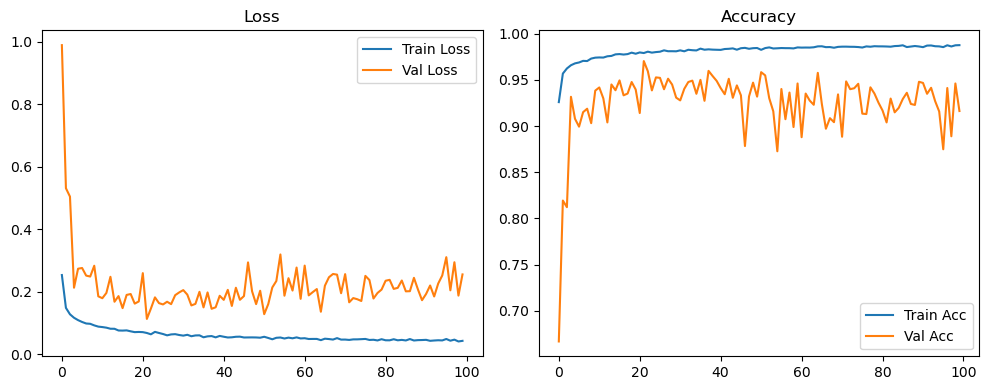

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9641 | Val Loss: 0.0609, Acc: 0.9814


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9826 | Val Loss: 0.0561, Acc: 0.9837


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9864 | Val Loss: 0.0457, Acc: 0.9859


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9884 | Val Loss: 0.0389, Acc: 0.9882


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.0465, Acc: 0.9857


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0414, Acc: 0.9889


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0589, Acc: 0.9862


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0515, Acc: 0.9858


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0509, Acc: 0.9873


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0613, Acc: 0.9861


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0530, Acc: 0.9882


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0517, Acc: 0.9887


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0521, Acc: 0.9894


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0597, Acc: 0.9888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0754, Acc: 0.9877


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0714, Acc: 0.9875


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0691, Acc: 0.9878


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.0662, Acc: 0.9883


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0736, Acc: 0.9871


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0777, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0629, Acc: 0.9896


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9974 | Val Loss: 0.0653, Acc: 0.9894


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0628, Acc: 0.9897


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.0767, Acc: 0.9877


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.0786, Acc: 0.9889


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0728, Acc: 0.9879


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.0820, Acc: 0.9888


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.0699, Acc: 0.9902


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.0816, Acc: 0.9868


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9978 | Val Loss: 0.0821, Acc: 0.9876


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0722, Acc: 0.9905


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9977 | Val Loss: 0.0855, Acc: 0.9884


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9984 | Val Loss: 0.0964, Acc: 0.9870


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9979 | Val Loss: 0.1031, Acc: 0.9885


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9977 | Val Loss: 0.0856, Acc: 0.9892


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0666, Acc: 0.9914


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.0902, Acc: 0.9890


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.0964, Acc: 0.9882


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.0866, Acc: 0.9888


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0952, Acc: 0.9896


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.0874, Acc: 0.9901


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0869, Acc: 0.9905


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9983 | Val Loss: 0.0971, Acc: 0.9895


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.0967, Acc: 0.9908


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9984 | Val Loss: 0.0961, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0736, Acc: 0.9912


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9983 | Val Loss: 0.1017, Acc: 0.9898


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9983 | Val Loss: 0.0825, Acc: 0.9899


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0974, Acc: 0.9896


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9987 | Val Loss: 0.0990, Acc: 0.9907


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0887, Acc: 0.9911


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0928, Acc: 0.9901


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0844, Acc: 0.9907


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0866, Acc: 0.9921


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0803, Acc: 0.9914


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0998, Acc: 0.9903


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0868, Acc: 0.9911


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0904, Acc: 0.9905


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1029, Acc: 0.9909


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1045, Acc: 0.9916


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0950, Acc: 0.9911


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1011, Acc: 0.9911


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0866, Acc: 0.9917


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1062, Acc: 0.9905


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.0954, Acc: 0.9910


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0988, Acc: 0.9907


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0975, Acc: 0.9905


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1128, Acc: 0.9907


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1066, Acc: 0.9912


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1196, Acc: 0.9908


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1063, Acc: 0.9910


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1074, Acc: 0.9911


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0986, Acc: 0.9904


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1070, Acc: 0.9914


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0975, Acc: 0.9916


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0950, Acc: 0.9924


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.1116, Acc: 0.9922


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1038, Acc: 0.9920


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0950, Acc: 0.9920


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.1008, Acc: 0.9928


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0905, Acc: 0.9924


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0953, Acc: 0.9924


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0947, Acc: 0.9927


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0976, Acc: 0.9922


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9921


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0985, Acc: 0.9916


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0970, Acc: 0.9920


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0928, Acc: 0.9926


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0919, Acc: 0.9928


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0971, Acc: 0.9929


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0985, Acc: 0.9919


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0956, Acc: 0.9928


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0929, Acc: 0.9924


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0976, Acc: 0.9924


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1081, Acc: 0.9919


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0963, Acc: 0.9924


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0971, Acc: 0.9928


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1056, Acc: 0.9921


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1045, Acc: 0.9918


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0997, Acc: 0.9918


Final Test Loss: 0.1173 Accuracy: 0.9909


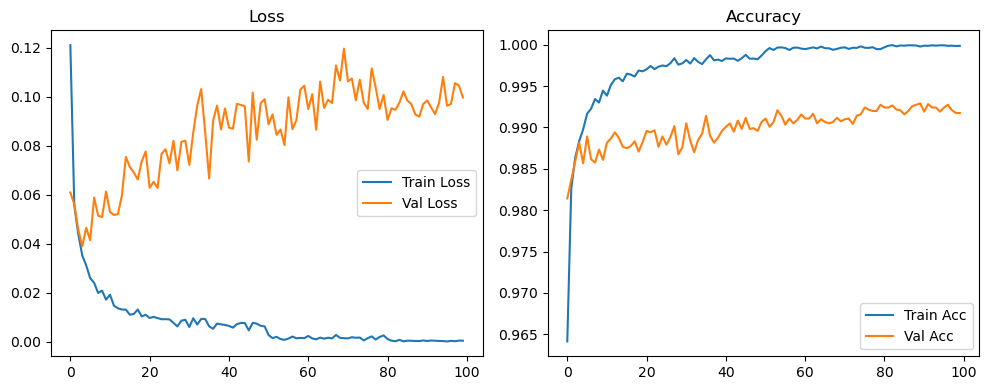

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1496, Acc: 0.9572 | Val Loss: 0.1531, Acc: 0.9532


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9758 | Val Loss: 0.0888, Acc: 0.9722


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9810 | Val Loss: 0.0737, Acc: 0.9762


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9824 | Val Loss: 0.0756, Acc: 0.9752


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9850 | Val Loss: 0.0756, Acc: 0.9754


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9860 | Val Loss: 0.0593, Acc: 0.9831


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.0436, Acc: 0.9878


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.0575, Acc: 0.9828


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0540, Acc: 0.9842


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0575, Acc: 0.9829


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.0576, Acc: 0.9834


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 0.0431, Acc: 0.9875


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.0660, Acc: 0.9840


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9914 | Val Loss: 0.0551, Acc: 0.9858


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.0513, Acc: 0.9868


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0603, Acc: 0.9847


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9922 | Val Loss: 0.0716, Acc: 0.9804


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.0498, Acc: 0.9878


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.0602, Acc: 0.9852


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0403, Acc: 0.9890


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0526, Acc: 0.9862


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0494, Acc: 0.9875


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9942 | Val Loss: 0.0556, Acc: 0.9872


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0480, Acc: 0.9878


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0504, Acc: 0.9864


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9939 | Val Loss: 0.0544, Acc: 0.9858


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0743, Acc: 0.9849


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9937 | Val Loss: 0.0671, Acc: 0.9856


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.0538, Acc: 0.9875


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9941 | Val Loss: 0.0531, Acc: 0.9875


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.0545, Acc: 0.9884


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9950 | Val Loss: 0.0635, Acc: 0.9841


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9949 | Val Loss: 0.0400, Acc: 0.9893


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9954 | Val Loss: 0.0549, Acc: 0.9866


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.0552, Acc: 0.9871


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9955 | Val Loss: 0.0611, Acc: 0.9855


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9951 | Val Loss: 0.0534, Acc: 0.9889


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.0483, Acc: 0.9888


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9957 | Val Loss: 0.0513, Acc: 0.9874


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0475, Acc: 0.9894


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9957 | Val Loss: 0.0523, Acc: 0.9887


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9947 | Val Loss: 0.0587, Acc: 0.9875


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.0538, Acc: 0.9884


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9959 | Val Loss: 0.0777, Acc: 0.9858


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0558, Acc: 0.9882


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.0595, Acc: 0.9861


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9963 | Val Loss: 0.0711, Acc: 0.9856


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.0627, Acc: 0.9874


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9959 | Val Loss: 0.0531, Acc: 0.9888


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9964 | Val Loss: 0.0665, Acc: 0.9872


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0557, Acc: 0.9890


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.0584, Acc: 0.9888


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0580, Acc: 0.9884


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0474, Acc: 0.9902


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0649, Acc: 0.9881


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0503, Acc: 0.9906


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0538, Acc: 0.9898


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0476, Acc: 0.9904


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0535, Acc: 0.9885


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0539, Acc: 0.9892


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0585, Acc: 0.9888


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0494, Acc: 0.9902


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0509, Acc: 0.9914


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0489, Acc: 0.9909


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0496, Acc: 0.9910


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0503, Acc: 0.9896


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0500, Acc: 0.9908


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.0589, Acc: 0.9894


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.0640, Acc: 0.9882


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0563, Acc: 0.9900


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.0659, Acc: 0.9879


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0624, Acc: 0.9884


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0564, Acc: 0.9897


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0518, Acc: 0.9898


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0636, Acc: 0.9883


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0518, Acc: 0.9906


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0593, Acc: 0.9900


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0571, Acc: 0.9902


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0565, Acc: 0.9894


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0489, Acc: 0.9909


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0485, Acc: 0.9902


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0494, Acc: 0.9911


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0531, Acc: 0.9917


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0517, Acc: 0.9903


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0485, Acc: 0.9917


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0484, Acc: 0.9907


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0496, Acc: 0.9901


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0559, Acc: 0.9898


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0510, Acc: 0.9915


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0506, Acc: 0.9911


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0577, Acc: 0.9901


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0472, Acc: 0.9915


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0516, Acc: 0.9906


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0464, Acc: 0.9909


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0541, Acc: 0.9906


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0493, Acc: 0.9906


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0517, Acc: 0.9899


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0567, Acc: 0.9896


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0476, Acc: 0.9912


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0502, Acc: 0.9908


Final Test Loss: 0.0559 Accuracy: 0.9889


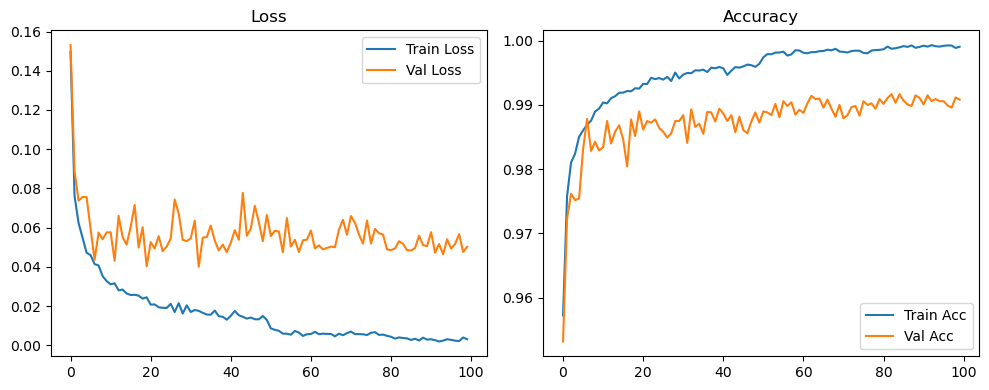

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2535, Acc: 0.9253 | Val Loss: 1.1008, Acc: 0.6543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9555 | Val Loss: 0.5396, Acc: 0.8063


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1305, Acc: 0.9605 | Val Loss: 0.5321, Acc: 0.8127


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1163, Acc: 0.9656 | Val Loss: 0.2279, Acc: 0.9253


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1092, Acc: 0.9681 | Val Loss: 0.2829, Acc: 0.8999


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9686 | Val Loss: 0.2786, Acc: 0.9072


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9706 | Val Loss: 0.2449, Acc: 0.9143


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9709 | Val Loss: 0.3484, Acc: 0.8709


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9727 | Val Loss: 0.3916, Acc: 0.8530


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9741 | Val Loss: 0.2499, Acc: 0.9086


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9743 | Val Loss: 0.1914, Acc: 0.9407


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9750 | Val Loss: 0.1742, Acc: 0.9445


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9757 | Val Loss: 0.1812, Acc: 0.9427


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9770 | Val Loss: 0.1805, Acc: 0.9412


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9771 | Val Loss: 0.1939, Acc: 0.9371


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0797, Acc: 0.9756 | Val Loss: 0.1548, Acc: 0.9481


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9777 | Val Loss: 0.1616, Acc: 0.9456


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9783 | Val Loss: 0.1723, Acc: 0.9437


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9797 | Val Loss: 0.1429, Acc: 0.9567


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9786 | Val Loss: 0.1784, Acc: 0.9407


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9791 | Val Loss: 0.1911, Acc: 0.9343


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9794 | Val Loss: 0.1474, Acc: 0.9563


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9796 | Val Loss: 0.1668, Acc: 0.9521


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9801 | Val Loss: 0.1593, Acc: 0.9505


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9809 | Val Loss: 0.1420, Acc: 0.9541


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9811 | Val Loss: 0.1431, Acc: 0.9577


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9816 | Val Loss: 0.1509, Acc: 0.9454


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9803 | Val Loss: 0.1547, Acc: 0.9504


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9814 | Val Loss: 0.1425, Acc: 0.9617


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9820 | Val Loss: 0.1689, Acc: 0.9470


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9807 | Val Loss: 0.1890, Acc: 0.9400


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9825 | Val Loss: 0.1856, Acc: 0.9373


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9818 | Val Loss: 0.1448, Acc: 0.9542


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9823 | Val Loss: 0.1998, Acc: 0.9323


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9822 | Val Loss: 0.1874, Acc: 0.9470


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9832 | Val Loss: 0.1727, Acc: 0.9479


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9825 | Val Loss: 0.1311, Acc: 0.9633


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9833 | Val Loss: 0.2407, Acc: 0.9013


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9832 | Val Loss: 0.2057, Acc: 0.9303


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9829 | Val Loss: 0.1303, Acc: 0.9556


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9834 | Val Loss: 0.2378, Acc: 0.9276


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9828 | Val Loss: 0.1640, Acc: 0.9493


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9837 | Val Loss: 0.1748, Acc: 0.9383


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9834 | Val Loss: 0.2051, Acc: 0.9367


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9839 | Val Loss: 0.1847, Acc: 0.9397


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9850 | Val Loss: 0.2096, Acc: 0.9223


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9819 | Val Loss: 0.3084, Acc: 0.8674


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9827 | Val Loss: 0.1774, Acc: 0.9427


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9839 | Val Loss: 0.2749, Acc: 0.8911


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9846 | Val Loss: 0.2307, Acc: 0.9183


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9857 | Val Loss: 0.2192, Acc: 0.9143


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9872 | Val Loss: 0.2181, Acc: 0.9225


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9876 | Val Loss: 0.2066, Acc: 0.9296


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9877 | Val Loss: 0.2196, Acc: 0.9243


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.2076, Acc: 0.9307


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.1652, Acc: 0.9509


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 0.1521, Acc: 0.9536


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9879 | Val Loss: 0.1647, Acc: 0.9487


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9884 | Val Loss: 0.1820, Acc: 0.9349


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.2403, Acc: 0.9057


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.2485, Acc: 0.9048


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9880 | Val Loss: 0.1677, Acc: 0.9487


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.1740, Acc: 0.9449


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.1830, Acc: 0.9417


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9892 | Val Loss: 0.1733, Acc: 0.9437


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.1371, Acc: 0.9539


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9889 | Val Loss: 0.2340, Acc: 0.9254


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9890 | Val Loss: 0.2307, Acc: 0.9195


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9884 | Val Loss: 0.1635, Acc: 0.9549


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.1746, Acc: 0.9464


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9894 | Val Loss: 0.1552, Acc: 0.9494


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.1956, Acc: 0.9359


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 0.1903, Acc: 0.9345


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.2121, Acc: 0.9194


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9884 | Val Loss: 0.1976, Acc: 0.9322


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9898 | Val Loss: 0.2414, Acc: 0.9187


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9896 | Val Loss: 0.1898, Acc: 0.9377


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.1975, Acc: 0.9445


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9905 | Val Loss: 0.1833, Acc: 0.9485


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9886 | Val Loss: 0.2284, Acc: 0.9280


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9902 | Val Loss: 0.1873, Acc: 0.9420


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.2007, Acc: 0.9333


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.2021, Acc: 0.9342


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.1849, Acc: 0.9509


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.2263, Acc: 0.9208


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9912 | Val Loss: 0.2587, Acc: 0.8982


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.2358, Acc: 0.9227


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.2468, Acc: 0.9137


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1947, Acc: 0.9375


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.1903, Acc: 0.9453


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.2298, Acc: 0.9325


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.2126, Acc: 0.9342


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.2026, Acc: 0.9433


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.1873, Acc: 0.9459


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.2069, Acc: 0.9326


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9912 | Val Loss: 0.2241, Acc: 0.9289


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.2164, Acc: 0.9406


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.2599, Acc: 0.9190


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.2161, Acc: 0.9397


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.2110, Acc: 0.9477


Final Test Loss: 0.2087 Accuracy: 0.9459


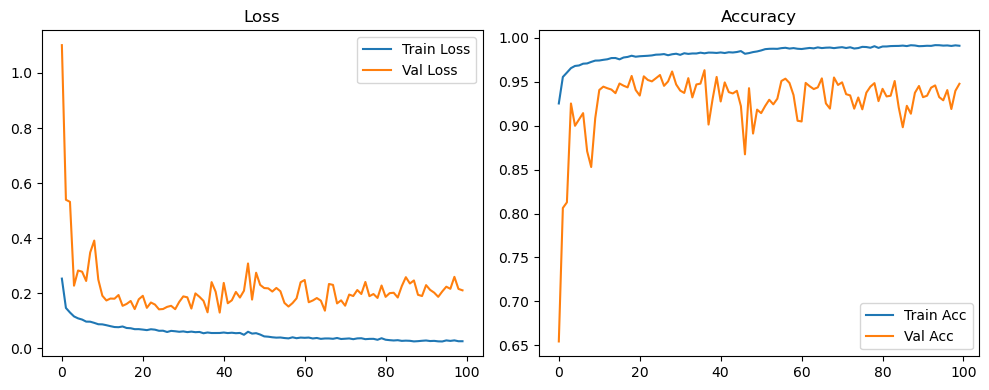

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9641 | Val Loss: 0.0609, Acc: 0.9814


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9831 | Val Loss: 0.0432, Acc: 0.9878


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9866 | Val Loss: 0.0444, Acc: 0.9863


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.0441, Acc: 0.9882


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0484, Acc: 0.9860


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.0548, Acc: 0.9845


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0506, Acc: 0.9872


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0549, Acc: 0.9849


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0638, Acc: 0.9839


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.0467, Acc: 0.9888


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0521, Acc: 0.9862


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0633, Acc: 0.9857


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0509, Acc: 0.9879


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0584, Acc: 0.9878


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0577, Acc: 0.9875


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0609, Acc: 0.9885


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0585, Acc: 0.9898


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0571, Acc: 0.9877


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.0629, Acc: 0.9890


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0756, Acc: 0.9863


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9971 | Val Loss: 0.0579, Acc: 0.9891


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0642, Acc: 0.9896


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0744, Acc: 0.9870


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.0712, Acc: 0.9897


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.0750, Acc: 0.9874


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0663, Acc: 0.9891


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.0591, Acc: 0.9898


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.0605, Acc: 0.9896


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0693, Acc: 0.9902


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0692, Acc: 0.9911


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.0739, Acc: 0.9900


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0755, Acc: 0.9906


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0800, Acc: 0.9899


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0758, Acc: 0.9900


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9978 | Val Loss: 0.0862, Acc: 0.9892


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9985 | Val Loss: 0.0815, Acc: 0.9896


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9985 | Val Loss: 0.0922, Acc: 0.9877


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.0772, Acc: 0.9898


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0907, Acc: 0.9884


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.0750, Acc: 0.9914


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0931, Acc: 0.9875


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0813, Acc: 0.9908


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0809, Acc: 0.9916


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.0990, Acc: 0.9885


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.0865, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9983 | Val Loss: 0.0897, Acc: 0.9901


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9981 | Val Loss: 0.1018, Acc: 0.9903


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9983 | Val Loss: 0.0900, Acc: 0.9905


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9983 | Val Loss: 0.1132, Acc: 0.9888


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1010, Acc: 0.9893


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0817, Acc: 0.9916


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0886, Acc: 0.9922


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0860, Acc: 0.9922


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0848, Acc: 0.9912


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0918, Acc: 0.9912


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0869, Acc: 0.9915


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0923, Acc: 0.9918


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0957, Acc: 0.9915


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0976, Acc: 0.9910


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.0927, Acc: 0.9916


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1079, Acc: 0.9904


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0879, Acc: 0.9913


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0927, Acc: 0.9918


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0972, Acc: 0.9912


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0938, Acc: 0.9916


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0948, Acc: 0.9910


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0944, Acc: 0.9916


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1103, Acc: 0.9906


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9996 | Val Loss: 0.1106, Acc: 0.9912


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0930, Acc: 0.9923


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0917, Acc: 0.9915


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1050, Acc: 0.9910


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0980, Acc: 0.9911


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0980, Acc: 0.9903


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0942, Acc: 0.9916


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1185, Acc: 0.9908


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1207, Acc: 0.9907


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.0941, Acc: 0.9918


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1109, Acc: 0.9906


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1135, Acc: 0.9908


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1016, Acc: 0.9921


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1025, Acc: 0.9920


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1002, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0923, Acc: 0.9925


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0948, Acc: 0.9924


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0920, Acc: 0.9927


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0977, Acc: 0.9926


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0993, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1048, Acc: 0.9923


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1088, Acc: 0.9915


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1076, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1043, Acc: 0.9924


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0913, Acc: 0.9926


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1003, Acc: 0.9918


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0980, Acc: 0.9923


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0974, Acc: 0.9930


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0972, Acc: 0.9929


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0923, Acc: 0.9936


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1015, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0963, Acc: 0.9921


Final Test Loss: 0.1031 Accuracy: 0.9912


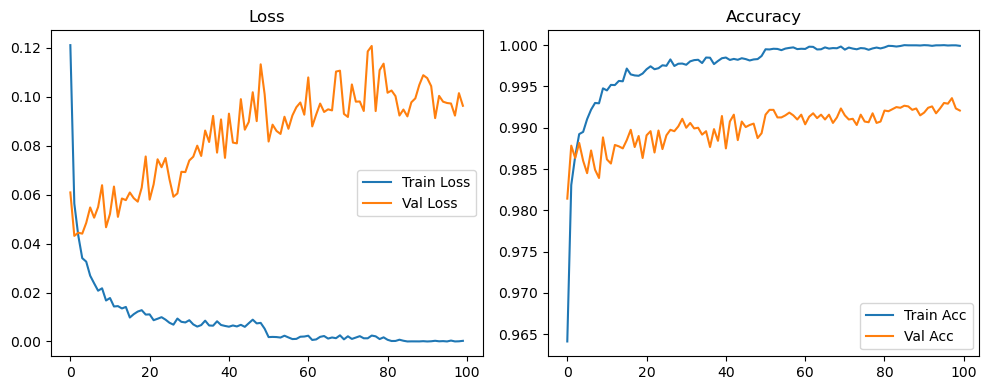

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9571 | Val Loss: 0.1489, Acc: 0.9540


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9761 | Val Loss: 0.0744, Acc: 0.9778


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9807 | Val Loss: 0.0544, Acc: 0.9840


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9830 | Val Loss: 0.0773, Acc: 0.9757


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9841 | Val Loss: 0.0579, Acc: 0.9833


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9855 | Val Loss: 0.0673, Acc: 0.9794


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 0.0446, Acc: 0.9869


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9878 | Val Loss: 0.0558, Acc: 0.9833


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0529, Acc: 0.9840


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.0596, Acc: 0.9822


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.0674, Acc: 0.9831


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0622, Acc: 0.9820


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.0495, Acc: 0.9859


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.0494, Acc: 0.9868


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0512, Acc: 0.9873


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9926 | Val Loss: 0.0734, Acc: 0.9805


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9919 | Val Loss: 0.0526, Acc: 0.9863


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9927 | Val Loss: 0.0497, Acc: 0.9870


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.0558, Acc: 0.9867


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9938 | Val Loss: 0.0461, Acc: 0.9889


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9934 | Val Loss: 0.0546, Acc: 0.9856


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0541, Acc: 0.9855


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.0623, Acc: 0.9848


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0567, Acc: 0.9832


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0545, Acc: 0.9868


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9942 | Val Loss: 0.0602, Acc: 0.9868


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0752, Acc: 0.9845


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9942 | Val Loss: 0.0581, Acc: 0.9876


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.0517, Acc: 0.9885


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0560, Acc: 0.9848


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9946 | Val Loss: 0.0607, Acc: 0.9857


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.0548, Acc: 0.9867


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9949 | Val Loss: 0.0465, Acc: 0.9901


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.0518, Acc: 0.9886


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.0576, Acc: 0.9852


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9951 | Val Loss: 0.0520, Acc: 0.9878


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9953 | Val Loss: 0.0629, Acc: 0.9859


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0618, Acc: 0.9857


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9957 | Val Loss: 0.0573, Acc: 0.9879


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.0576, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9953 | Val Loss: 0.0500, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9957 | Val Loss: 0.0646, Acc: 0.9875


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9963 | Val Loss: 0.0533, Acc: 0.9889


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9958 | Val Loss: 0.0608, Acc: 0.9870


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9956 | Val Loss: 0.0696, Acc: 0.9848


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9956 | Val Loss: 0.0600, Acc: 0.9868


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9965 | Val Loss: 0.0798, Acc: 0.9824


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.0635, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9963 | Val Loss: 0.0623, Acc: 0.9874


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.0662, Acc: 0.9872


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.0521, Acc: 0.9884


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0576, Acc: 0.9882


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0486, Acc: 0.9906


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0504, Acc: 0.9900


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0571, Acc: 0.9879


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0482, Acc: 0.9913


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0515, Acc: 0.9900


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.0531, Acc: 0.9886


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0607, Acc: 0.9893


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0577, Acc: 0.9892


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0580, Acc: 0.9885


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.0605, Acc: 0.9883


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0501, Acc: 0.9906


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0577, Acc: 0.9888


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.0544, Acc: 0.9893


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0610, Acc: 0.9888


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0578, Acc: 0.9892


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.0491, Acc: 0.9902


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0541, Acc: 0.9894


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0508, Acc: 0.9908


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0646, Acc: 0.9890


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0573, Acc: 0.9892


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0610, Acc: 0.9890


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0546, Acc: 0.9896


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0591, Acc: 0.9903


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.0532, Acc: 0.9903


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0634, Acc: 0.9885


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.0550, Acc: 0.9904


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.0571, Acc: 0.9886


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0556, Acc: 0.9901


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0526, Acc: 0.9901


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0470, Acc: 0.9914


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0495, Acc: 0.9912


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0525, Acc: 0.9909


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0564, Acc: 0.9894


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0514, Acc: 0.9899


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0513, Acc: 0.9907


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0523, Acc: 0.9906


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0558, Acc: 0.9900


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0526, Acc: 0.9913


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0619, Acc: 0.9902


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0557, Acc: 0.9904


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0581, Acc: 0.9899


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0509, Acc: 0.9910


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0533, Acc: 0.9909


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0530, Acc: 0.9900


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0524, Acc: 0.9908


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0513, Acc: 0.9907


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0571, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0466, Acc: 0.9912


Final Test Loss: 0.0499 Accuracy: 0.9898


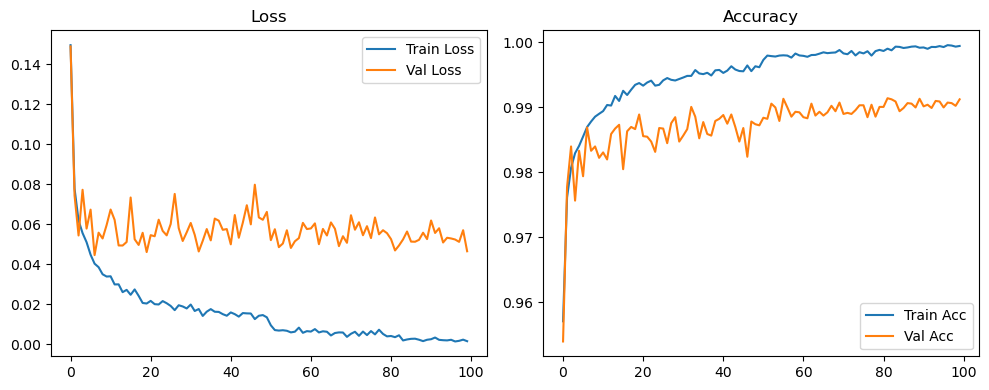

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2529, Acc: 0.9258 | Val Loss: 0.6247, Acc: 0.7812


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1465, Acc: 0.9563 | Val Loss: 0.5468, Acc: 0.8123


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9619 | Val Loss: 0.3301, Acc: 0.8816


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9655 | Val Loss: 0.2899, Acc: 0.9011


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1088, Acc: 0.9684 | Val Loss: 0.3015, Acc: 0.8939


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9693 | Val Loss: 0.2734, Acc: 0.9043


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0986, Acc: 0.9707 | Val Loss: 0.2536, Acc: 0.9126


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9712 | Val Loss: 0.2835, Acc: 0.9020


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9720 | Val Loss: 0.3072, Acc: 0.8817


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0899, Acc: 0.9740 | Val Loss: 0.1754, Acc: 0.9373


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9740 | Val Loss: 0.1768, Acc: 0.9417


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9745 | Val Loss: 0.1762, Acc: 0.9397


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9758 | Val Loss: 0.2076, Acc: 0.9253


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9762 | Val Loss: 0.1602, Acc: 0.9456


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9779 | Val Loss: 0.1879, Acc: 0.9370


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9775 | Val Loss: 0.1917, Acc: 0.9291


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9767 | Val Loss: 0.1724, Acc: 0.9385


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9795 | Val Loss: 0.2074, Acc: 0.9234


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9784 | Val Loss: 0.1244, Acc: 0.9604


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9796 | Val Loss: 0.2445, Acc: 0.9012


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9797 | Val Loss: 0.2230, Acc: 0.9122


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9795 | Val Loss: 0.1471, Acc: 0.9549


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9787 | Val Loss: 0.1188, Acc: 0.9617


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9806 | Val Loss: 0.1586, Acc: 0.9437


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9810 | Val Loss: 0.1478, Acc: 0.9496


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9803 | Val Loss: 0.1583, Acc: 0.9447


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9816 | Val Loss: 0.1604, Acc: 0.9444


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9802 | Val Loss: 0.1845, Acc: 0.9342


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9813 | Val Loss: 0.1510, Acc: 0.9510


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9822 | Val Loss: 0.2075, Acc: 0.9209


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9824 | Val Loss: 0.1814, Acc: 0.9377


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9811 | Val Loss: 0.1962, Acc: 0.9281


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9810 | Val Loss: 0.1688, Acc: 0.9427


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9830 | Val Loss: 0.1818, Acc: 0.9352


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9824 | Val Loss: 0.1771, Acc: 0.9393


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9834 | Val Loss: 0.1854, Acc: 0.9311


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9824 | Val Loss: 0.2049, Acc: 0.9225


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9830 | Val Loss: 0.2724, Acc: 0.8861


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9828 | Val Loss: 0.1540, Acc: 0.9477


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9831 | Val Loss: 0.1782, Acc: 0.9428


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9819 | Val Loss: 0.2071, Acc: 0.9367


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9844 | Val Loss: 0.1954, Acc: 0.9327


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9830 | Val Loss: 0.1398, Acc: 0.9531


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9833 | Val Loss: 0.2107, Acc: 0.9280


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9840 | Val Loss: 0.2010, Acc: 0.9227


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9845 | Val Loss: 0.2007, Acc: 0.9303


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9832 | Val Loss: 0.2966, Acc: 0.8715


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9838 | Val Loss: 0.2033, Acc: 0.9288


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9837 | Val Loss: 0.3389, Acc: 0.8443


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9844 | Val Loss: 0.2172, Acc: 0.9131


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9862 | Val Loss: 0.2057, Acc: 0.9167


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9871 | Val Loss: 0.1894, Acc: 0.9385


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.1943, Acc: 0.9263


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9881 | Val Loss: 0.2342, Acc: 0.9081


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9886 | Val Loss: 0.2312, Acc: 0.9066


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9880 | Val Loss: 0.1910, Acc: 0.9360


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.2095, Acc: 0.9219


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.1636, Acc: 0.9477


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.1796, Acc: 0.9357


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.1709, Acc: 0.9478


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9889 | Val Loss: 0.1919, Acc: 0.9263


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.1684, Acc: 0.9529


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.1918, Acc: 0.9298


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.1955, Acc: 0.9331


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.1936, Acc: 0.9441


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9884 | Val Loss: 0.1876, Acc: 0.9337


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9886 | Val Loss: 0.1973, Acc: 0.9303


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9887 | Val Loss: 0.2005, Acc: 0.9307


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9890 | Val Loss: 0.2017, Acc: 0.9338


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.1944, Acc: 0.9326


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.1982, Acc: 0.9293


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9888 | Val Loss: 0.1720, Acc: 0.9487


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 0.1738, Acc: 0.9438


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9889 | Val Loss: 0.1917, Acc: 0.9424


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9883 | Val Loss: 0.1558, Acc: 0.9546


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9895 | Val Loss: 0.2164, Acc: 0.9362


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.2068, Acc: 0.9334


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9895 | Val Loss: 0.1819, Acc: 0.9401


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9895 | Val Loss: 0.2157, Acc: 0.9263


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.2769, Acc: 0.8988


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.2388, Acc: 0.9265


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9910 | Val Loss: 0.1983, Acc: 0.9422


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.1901, Acc: 0.9392


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.2090, Acc: 0.9306


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.1853, Acc: 0.9432


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.2142, Acc: 0.9209


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.1692, Acc: 0.9503


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.2057, Acc: 0.9263


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.1896, Acc: 0.9299


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1966, Acc: 0.9340


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1981, Acc: 0.9383


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1763, Acc: 0.9435


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.1796, Acc: 0.9437


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1762, Acc: 0.9397


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.2003, Acc: 0.9258


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9920 | Val Loss: 0.1920, Acc: 0.9341


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.2100, Acc: 0.9276


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.1980, Acc: 0.9376


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.1697, Acc: 0.9517


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.2091, Acc: 0.9359


Final Test Loss: 0.2068 Accuracy: 0.9411


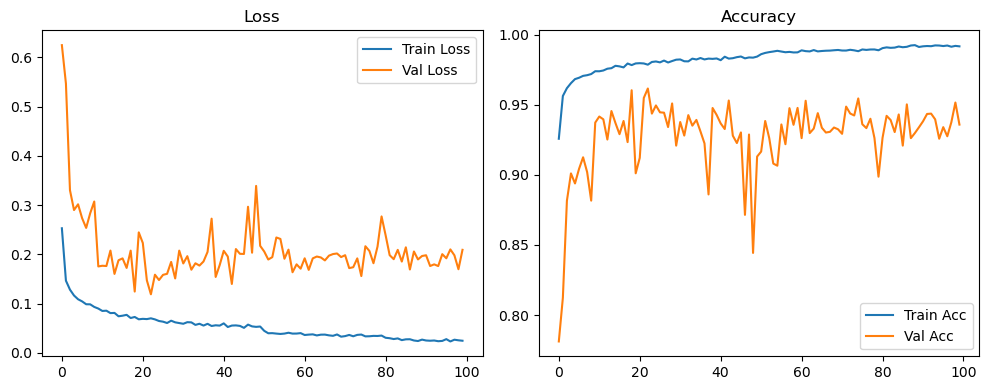

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9641 | Val Loss: 0.0609, Acc: 0.9814


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9831 | Val Loss: 0.0432, Acc: 0.9878


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9869 | Val Loss: 0.0463, Acc: 0.9859


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9894 | Val Loss: 0.0459, Acc: 0.9867


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.0476, Acc: 0.9859


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.0435, Acc: 0.9875


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0453, Acc: 0.9885


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0372, Acc: 0.9895


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0556, Acc: 0.9874


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0539, Acc: 0.9874


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0745, Acc: 0.9848


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0600, Acc: 0.9878


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0601, Acc: 0.9868


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.0600, Acc: 0.9886


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.0599, Acc: 0.9882


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.0558, Acc: 0.9892


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0587, Acc: 0.9888


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0602, Acc: 0.9896


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.0674, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.0553, Acc: 0.9896


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0783, Acc: 0.9871


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0874, Acc: 0.9875


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0625, Acc: 0.9909


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0822, Acc: 0.9882


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0712, Acc: 0.9898


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0584, Acc: 0.9908


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0878, Acc: 0.9874


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.0950, Acc: 0.9879


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9973 | Val Loss: 0.0891, Acc: 0.9887


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9975 | Val Loss: 0.0772, Acc: 0.9894


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1016, Acc: 0.9874


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.0945, Acc: 0.9882


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9977 | Val Loss: 0.0868, Acc: 0.9876


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0758, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0858, Acc: 0.9906


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.0775, Acc: 0.9901


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.0797, Acc: 0.9889


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0938, Acc: 0.9898


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0786, Acc: 0.9900


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.0745, Acc: 0.9894


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0770, Acc: 0.9909


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9982 | Val Loss: 0.0899, Acc: 0.9892


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1112, Acc: 0.9894


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1183, Acc: 0.9885


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1125, Acc: 0.9901


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.0975, Acc: 0.9913


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9986 | Val Loss: 0.1046, Acc: 0.9901


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1042, Acc: 0.9899


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9983 | Val Loss: 0.1000, Acc: 0.9910


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0921, Acc: 0.9899


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0780, Acc: 0.9924


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0801, Acc: 0.9918


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0767, Acc: 0.9930


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0763, Acc: 0.9925


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0782, Acc: 0.9929


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0801, Acc: 0.9928


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0789, Acc: 0.9930


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0759, Acc: 0.9928


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0755, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0821, Acc: 0.9928


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0813, Acc: 0.9929


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0815, Acc: 0.9922


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0811, Acc: 0.9927


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0809, Acc: 0.9925


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0842, Acc: 0.9928


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0770, Acc: 0.9928


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0793, Acc: 0.9931


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0851, Acc: 0.9923


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0792, Acc: 0.9928


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0783, Acc: 0.9932


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0868, Acc: 0.9931


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0846, Acc: 0.9923


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0860, Acc: 0.9929


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0874, Acc: 0.9919


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0812, Acc: 0.9923


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0771, Acc: 0.9928


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0858, Acc: 0.9923


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0822, Acc: 0.9924


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0859, Acc: 0.9923


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0965, Acc: 0.9916


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0922, Acc: 0.9924


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0888, Acc: 0.9923


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0897, Acc: 0.9926


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0844, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0848, Acc: 0.9925


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0780, Acc: 0.9931


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0802, Acc: 0.9935


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0828, Acc: 0.9926


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0847, Acc: 0.9922


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0853, Acc: 0.9929


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0876, Acc: 0.9932


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0775, Acc: 0.9929


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0850, Acc: 0.9933


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0813, Acc: 0.9928


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0820, Acc: 0.9936


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0827, Acc: 0.9931


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0827, Acc: 0.9926


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0807, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0832, Acc: 0.9928


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0775, Acc: 0.9930


Final Test Loss: 0.0748 Accuracy: 0.9923


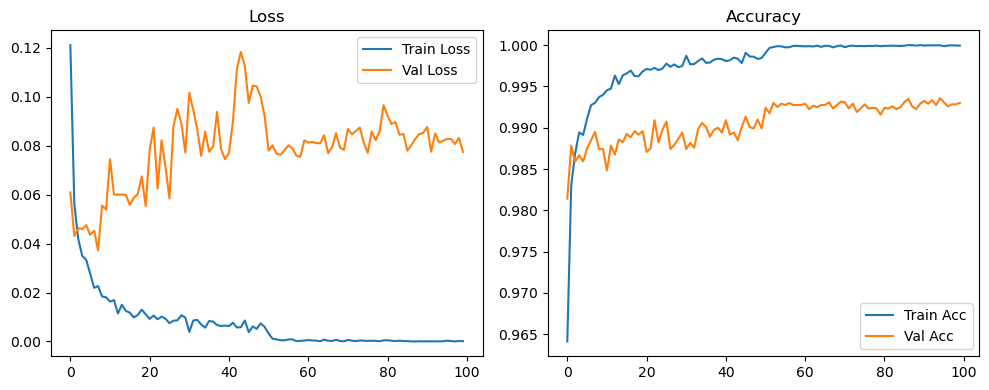

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9571 | Val Loss: 0.1489, Acc: 0.9540


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9764 | Val Loss: 0.0684, Acc: 0.9813


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9806 | Val Loss: 0.0880, Acc: 0.9730


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9821 | Val Loss: 0.0557, Acc: 0.9838


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9846 | Val Loss: 0.0663, Acc: 0.9806


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9859 | Val Loss: 0.0626, Acc: 0.9808


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9870 | Val Loss: 0.0444, Acc: 0.9865


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9882 | Val Loss: 0.0556, Acc: 0.9831


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9883 | Val Loss: 0.0406, Acc: 0.9878


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.0576, Acc: 0.9838


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0639, Acc: 0.9820


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.0493, Acc: 0.9852


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.0459, Acc: 0.9863


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0458, Acc: 0.9888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0597, Acc: 0.9843


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9915 | Val Loss: 0.0542, Acc: 0.9856


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9918 | Val Loss: 0.0466, Acc: 0.9870


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9929 | Val Loss: 0.0539, Acc: 0.9862


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0576, Acc: 0.9858


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0580, Acc: 0.9858


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0585, Acc: 0.9850


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9937 | Val Loss: 0.0491, Acc: 0.9877


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0594, Acc: 0.9854


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0567, Acc: 0.9859


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0498, Acc: 0.9876


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0540, Acc: 0.9872


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9946 | Val Loss: 0.0755, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0560, Acc: 0.9876


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9939 | Val Loss: 0.0580, Acc: 0.9866


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9947 | Val Loss: 0.0531, Acc: 0.9872


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0638, Acc: 0.9850


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9948 | Val Loss: 0.0662, Acc: 0.9863


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9943 | Val Loss: 0.0445, Acc: 0.9894


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9953 | Val Loss: 0.0548, Acc: 0.9871


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0461, Acc: 0.9888


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9959 | Val Loss: 0.0647, Acc: 0.9872


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9949 | Val Loss: 0.0575, Acc: 0.9868


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9947 | Val Loss: 0.0543, Acc: 0.9882


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9957 | Val Loss: 0.0559, Acc: 0.9887


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9958 | Val Loss: 0.0475, Acc: 0.9899


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9952 | Val Loss: 0.0456, Acc: 0.9893


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0563, Acc: 0.9875


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9964 | Val Loss: 0.0591, Acc: 0.9879


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9952 | Val Loss: 0.0593, Acc: 0.9867


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.0563, Acc: 0.9862


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0568, Acc: 0.9898


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.0637, Acc: 0.9882


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9962 | Val Loss: 0.0545, Acc: 0.9885


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9962 | Val Loss: 0.0539, Acc: 0.9877


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.0553, Acc: 0.9875


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0500, Acc: 0.9890


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0524, Acc: 0.9889


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0504, Acc: 0.9902


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0502, Acc: 0.9902


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0509, Acc: 0.9902


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0480, Acc: 0.9905


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0516, Acc: 0.9898


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0468, Acc: 0.9909


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0479, Acc: 0.9901


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0560, Acc: 0.9894


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0506, Acc: 0.9902


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0522, Acc: 0.9908


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0450, Acc: 0.9913


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0513, Acc: 0.9903


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0563, Acc: 0.9894


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0524, Acc: 0.9895


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0489, Acc: 0.9905


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0572, Acc: 0.9895


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0557, Acc: 0.9900


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0472, Acc: 0.9916


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0484, Acc: 0.9914


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0537, Acc: 0.9903


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0508, Acc: 0.9911


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0486, Acc: 0.9913


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0448, Acc: 0.9922


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0444, Acc: 0.9923


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0480, Acc: 0.9918


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0458, Acc: 0.9907


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0479, Acc: 0.9923


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0469, Acc: 0.9926


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0440, Acc: 0.9917


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0494, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0466, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0451, Acc: 0.9926


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0466, Acc: 0.9920


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0477, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0448, Acc: 0.9917


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0486, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0499, Acc: 0.9907


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0509, Acc: 0.9910


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0489, Acc: 0.9920


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0465, Acc: 0.9916


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0506, Acc: 0.9913


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0476, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0514, Acc: 0.9912


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.0502, Acc: 0.9901


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0479, Acc: 0.9919


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0453, Acc: 0.9916


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0487, Acc: 0.9912


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0446, Acc: 0.9914


Final Test Loss: 0.0414 Accuracy: 0.9910


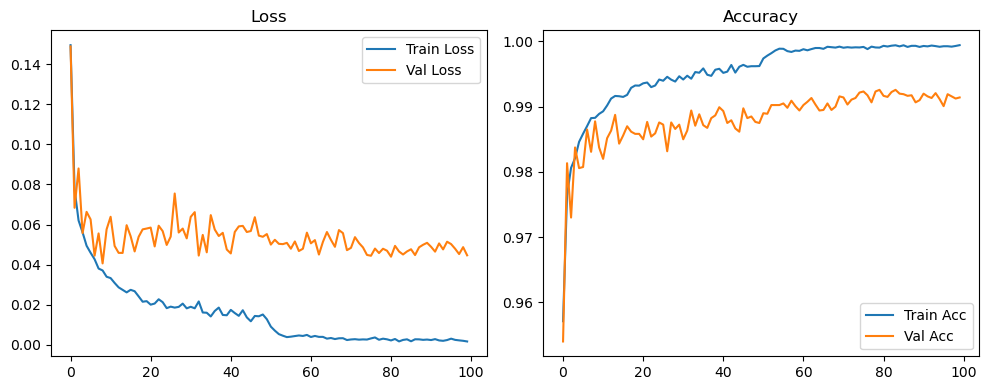

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2529, Acc: 0.9258 | Val Loss: 0.6247, Acc: 0.7812


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1490, Acc: 0.9565 | Val Loss: 0.5674, Acc: 0.8056


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9622 | Val Loss: 0.3410, Acc: 0.8846


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1178, Acc: 0.9655 | Val Loss: 0.3067, Acc: 0.8941


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9671 | Val Loss: 0.2978, Acc: 0.8952


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1056, Acc: 0.9687 | Val Loss: 0.3448, Acc: 0.8764


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9704 | Val Loss: 0.3084, Acc: 0.8942


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9713 | Val Loss: 0.2559, Acc: 0.9188


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9722 | Val Loss: 0.2224, Acc: 0.9224


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9738 | Val Loss: 0.2054, Acc: 0.9248


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9738 | Val Loss: 0.2229, Acc: 0.9202


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9739 | Val Loss: 0.1740, Acc: 0.9419


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0797, Acc: 0.9764 | Val Loss: 0.2795, Acc: 0.8967


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9763 | Val Loss: 0.1684, Acc: 0.9433


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9773 | Val Loss: 0.2185, Acc: 0.9245


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9780 | Val Loss: 0.1314, Acc: 0.9573


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9771 | Val Loss: 0.1602, Acc: 0.9463


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9775 | Val Loss: 0.2116, Acc: 0.9248


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9790 | Val Loss: 0.1816, Acc: 0.9423


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9791 | Val Loss: 0.2099, Acc: 0.9283


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9802 | Val Loss: 0.1912, Acc: 0.9365


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9796 | Val Loss: 0.1113, Acc: 0.9689


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9801 | Val Loss: 0.1464, Acc: 0.9533


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9799 | Val Loss: 0.1694, Acc: 0.9427


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9801 | Val Loss: 0.1430, Acc: 0.9493


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9809 | Val Loss: 0.1602, Acc: 0.9469


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9820 | Val Loss: 0.1545, Acc: 0.9477


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9810 | Val Loss: 0.1264, Acc: 0.9588


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9814 | Val Loss: 0.1876, Acc: 0.9345


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9807 | Val Loss: 0.1680, Acc: 0.9473


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9827 | Val Loss: 0.2054, Acc: 0.9203


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9817 | Val Loss: 0.1664, Acc: 0.9469


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9815 | Val Loss: 0.1813, Acc: 0.9391


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9829 | Val Loss: 0.2102, Acc: 0.9248


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9812 | Val Loss: 0.2390, Acc: 0.9101


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9842 | Val Loss: 0.1556, Acc: 0.9469


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9829 | Val Loss: 0.1751, Acc: 0.9354


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9823 | Val Loss: 0.1739, Acc: 0.9427


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9827 | Val Loss: 0.1836, Acc: 0.9375


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9837 | Val Loss: 0.1699, Acc: 0.9537


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9839 | Val Loss: 0.2029, Acc: 0.9339


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9835 | Val Loss: 0.2097, Acc: 0.9230


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9827 | Val Loss: 0.1789, Acc: 0.9420


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9839 | Val Loss: 0.1647, Acc: 0.9475


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9821 | Val Loss: 0.1734, Acc: 0.9368


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9849 | Val Loss: 0.1367, Acc: 0.9553


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9845 | Val Loss: 0.3021, Acc: 0.8746


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9846 | Val Loss: 0.2315, Acc: 0.9197


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9834 | Val Loss: 0.2187, Acc: 0.9197


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9845 | Val Loss: 0.1869, Acc: 0.9307


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9858 | Val Loss: 0.1560, Acc: 0.9510


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9887 | Val Loss: 0.1537, Acc: 0.9500


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9894 | Val Loss: 0.1578, Acc: 0.9463


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.1642, Acc: 0.9405


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9897 | Val Loss: 0.1818, Acc: 0.9313


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9891 | Val Loss: 0.1361, Acc: 0.9661


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9890 | Val Loss: 0.1673, Acc: 0.9400


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.1507, Acc: 0.9503


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9891 | Val Loss: 0.1482, Acc: 0.9546


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.1519, Acc: 0.9507


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.1460, Acc: 0.9507


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 0.1381, Acc: 0.9587


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.1531, Acc: 0.9513


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.1669, Acc: 0.9476


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.1731, Acc: 0.9430


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.1595, Acc: 0.9494


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.1666, Acc: 0.9491


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1563, Acc: 0.9536


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1361, Acc: 0.9616


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.1410, Acc: 0.9570


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.1349, Acc: 0.9606


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.1397, Acc: 0.9567


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.1497, Acc: 0.9545


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.1401, Acc: 0.9581


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.1260, Acc: 0.9632


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 0.1232, Acc: 0.9699


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9904 | Val Loss: 0.1604, Acc: 0.9564


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.1646, Acc: 0.9523


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9915 | Val Loss: 0.1493, Acc: 0.9603


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.1669, Acc: 0.9497


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9913 | Val Loss: 0.1695, Acc: 0.9533


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1422, Acc: 0.9603


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.1323, Acc: 0.9651


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.1514, Acc: 0.9588


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.1418, Acc: 0.9618


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.1696, Acc: 0.9496


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.1505, Acc: 0.9556


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.1806, Acc: 0.9468


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.1594, Acc: 0.9497


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9912 | Val Loss: 0.1734, Acc: 0.9489


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.1776, Acc: 0.9456


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1518, Acc: 0.9569


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.1571, Acc: 0.9558


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1420, Acc: 0.9621


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1747, Acc: 0.9436


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1628, Acc: 0.9567


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.1575, Acc: 0.9584


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.1641, Acc: 0.9547


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.1697, Acc: 0.9484


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.1587, Acc: 0.9561


Final Test Loss: 0.1548 Accuracy: 0.9557


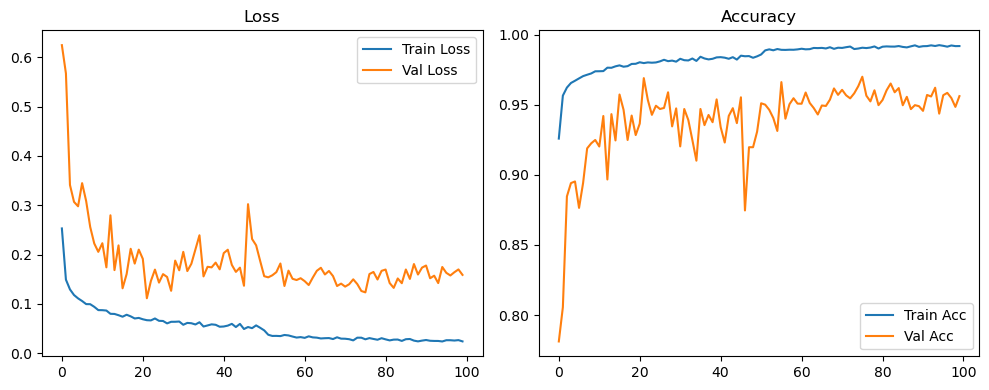

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1212, Acc: 0.9674 | Val Loss: 0.0624, Acc: 0.9803


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9845 | Val Loss: 0.0481, Acc: 0.9857


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0441, Acc: 0.9863


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.0448, Acc: 0.9866


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0473, Acc: 0.9863


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.0469, Acc: 0.9863


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0428, Acc: 0.9898


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.0744, Acc: 0.9799


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0431, Acc: 0.9882


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0502, Acc: 0.9878


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0582, Acc: 0.9858


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9962 | Val Loss: 0.0487, Acc: 0.9884


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0543, Acc: 0.9878


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0525, Acc: 0.9888


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0527, Acc: 0.9897


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0477, Acc: 0.9903


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0592, Acc: 0.9887


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0514, Acc: 0.9887


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0508, Acc: 0.9904


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0672, Acc: 0.9879


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0596, Acc: 0.9888


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0559, Acc: 0.9899


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0676, Acc: 0.9881


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0549, Acc: 0.9885


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0536, Acc: 0.9897


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0570, Acc: 0.9891


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0729, Acc: 0.9881


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0628, Acc: 0.9892


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0600, Acc: 0.9900


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0576, Acc: 0.9896


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0596, Acc: 0.9898


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0619, Acc: 0.9904


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0521, Acc: 0.9901


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0596, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0709, Acc: 0.9881


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0662, Acc: 0.9888


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0597, Acc: 0.9910


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0601, Acc: 0.9912


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0596, Acc: 0.9905


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0761, Acc: 0.9876


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0710, Acc: 0.9903


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0682, Acc: 0.9902


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0721, Acc: 0.9903


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0682, Acc: 0.9909


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0698, Acc: 0.9912


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0621, Acc: 0.9918


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0749, Acc: 0.9898


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0662, Acc: 0.9912


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0746, Acc: 0.9897


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.0752, Acc: 0.9900


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0643, Acc: 0.9910


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.0758, Acc: 0.9898


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0751, Acc: 0.9891


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.0714, Acc: 0.9905


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0832, Acc: 0.9892


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0689, Acc: 0.9910


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0693, Acc: 0.9906


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0685, Acc: 0.9899


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0818, Acc: 0.9882


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0674, Acc: 0.9903


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0849, Acc: 0.9901


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0767, Acc: 0.9912


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0738, Acc: 0.9906


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0722, Acc: 0.9906


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0756, Acc: 0.9908


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0743, Acc: 0.9908


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0754, Acc: 0.9912


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0804, Acc: 0.9902


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0868, Acc: 0.9902


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0920, Acc: 0.9903


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.0869, Acc: 0.9889


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0793, Acc: 0.9902


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0857, Acc: 0.9898


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0734, Acc: 0.9910


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0764, Acc: 0.9917


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0845, Acc: 0.9908


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0775, Acc: 0.9912


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0851, Acc: 0.9912


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0952, Acc: 0.9905


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0837, Acc: 0.9913


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0788, Acc: 0.9914


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0827, Acc: 0.9908


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0905, Acc: 0.9915


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0908, Acc: 0.9904


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0986, Acc: 0.9907


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0759, Acc: 0.9918


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0902, Acc: 0.9896


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0922, Acc: 0.9909


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0811, Acc: 0.9914


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0922, Acc: 0.9914


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1121, Acc: 0.9896


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.0903, Acc: 0.9906


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0914, Acc: 0.9898


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0883, Acc: 0.9914


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0862, Acc: 0.9913


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0993, Acc: 0.9908


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0991, Acc: 0.9913


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0956, Acc: 0.9908


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9902


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1077, Acc: 0.9909


Final Test Loss: 0.0909 Accuracy: 0.9895


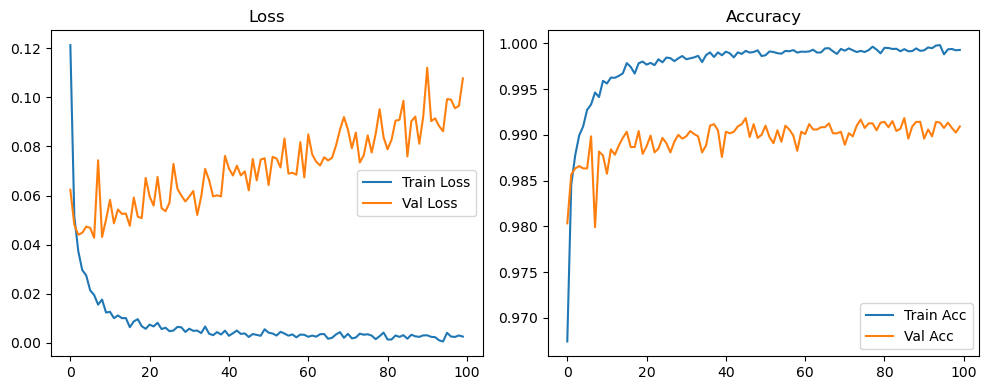

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1471, Acc: 0.9603 | Val Loss: 0.1048, Acc: 0.9677


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9781 | Val Loss: 0.0690, Acc: 0.9793


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9825 | Val Loss: 0.0720, Acc: 0.9784


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9843 | Val Loss: 0.0509, Acc: 0.9842


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.0496, Acc: 0.9865


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9875 | Val Loss: 0.0577, Acc: 0.9830


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.0535, Acc: 0.9843


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.0575, Acc: 0.9830


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.0428, Acc: 0.9878


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9913 | Val Loss: 0.0580, Acc: 0.9824


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0517, Acc: 0.9864


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.0426, Acc: 0.9881


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.0529, Acc: 0.9850


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.0510, Acc: 0.9857


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.0403, Acc: 0.9883


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0403, Acc: 0.9889


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0501, Acc: 0.9852


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0432, Acc: 0.9888


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0471, Acc: 0.9862


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0504, Acc: 0.9860


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0608, Acc: 0.9832


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0448, Acc: 0.9879


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0422, Acc: 0.9884


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0443, Acc: 0.9885


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0476, Acc: 0.9878


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0616, Acc: 0.9841


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.0531, Acc: 0.9856


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0470, Acc: 0.9881


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.0523, Acc: 0.9860


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0553, Acc: 0.9855


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0445, Acc: 0.9887


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0488, Acc: 0.9884


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0464, Acc: 0.9886


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0497, Acc: 0.9874


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.0485, Acc: 0.9887


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0599, Acc: 0.9863


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0422, Acc: 0.9889


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0405, Acc: 0.9902


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0487, Acc: 0.9889


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0512, Acc: 0.9883


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0390, Acc: 0.9894


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0552, Acc: 0.9861


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0467, Acc: 0.9883


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0610, Acc: 0.9852


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0486, Acc: 0.9874


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0458, Acc: 0.9907


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0719, Acc: 0.9825


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0514, Acc: 0.9891


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0456, Acc: 0.9888


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0418, Acc: 0.9901


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0469, Acc: 0.9892


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0556, Acc: 0.9863


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0475, Acc: 0.9888


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0460, Acc: 0.9884


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0460, Acc: 0.9891


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0539, Acc: 0.9871


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0512, Acc: 0.9891


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0441, Acc: 0.9892


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.0460, Acc: 0.9888


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0496, Acc: 0.9882


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0471, Acc: 0.9886


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0439, Acc: 0.9897


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0489, Acc: 0.9891


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0483, Acc: 0.9887


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0552, Acc: 0.9868


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0475, Acc: 0.9874


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0537, Acc: 0.9865


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0563, Acc: 0.9860


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0484, Acc: 0.9897


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0584, Acc: 0.9878


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0565, Acc: 0.9856


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0533, Acc: 0.9883


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0528, Acc: 0.9878


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0445, Acc: 0.9899


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0461, Acc: 0.9892


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0498, Acc: 0.9892


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0648, Acc: 0.9864


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0514, Acc: 0.9888


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0399, Acc: 0.9896


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0477, Acc: 0.9892


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0516, Acc: 0.9888


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0507, Acc: 0.9878


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0523, Acc: 0.9883


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0448, Acc: 0.9904


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0541, Acc: 0.9892


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0454, Acc: 0.9897


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0516, Acc: 0.9892


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0622, Acc: 0.9880


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0510, Acc: 0.9884


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0505, Acc: 0.9898


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0515, Acc: 0.9878


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.0534, Acc: 0.9874


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0552, Acc: 0.9875


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0437, Acc: 0.9907


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0514, Acc: 0.9889


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9976 | Val Loss: 0.0504, Acc: 0.9888


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0561, Acc: 0.9868


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0512, Acc: 0.9883


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.0442, Acc: 0.9895


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0471, Acc: 0.9895


Final Test Loss: 0.0489 Accuracy: 0.9890


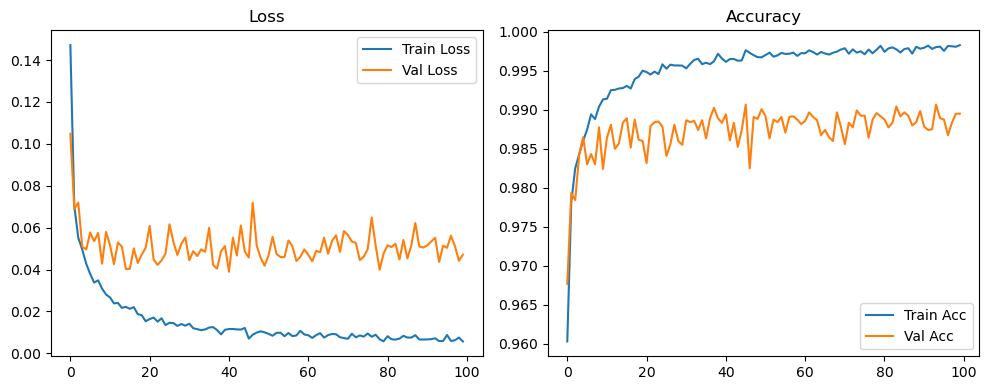

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2509, Acc: 0.9309 | Val Loss: 0.9091, Acc: 0.6828


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1375, Acc: 0.9601 | Val Loss: 0.6143, Acc: 0.8016


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1172, Acc: 0.9654 | Val Loss: 0.5554, Acc: 0.8120


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1090, Acc: 0.9674 | Val Loss: 0.2367, Acc: 0.9230


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1020, Acc: 0.9703 | Val Loss: 0.2881, Acc: 0.9023


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9716 | Val Loss: 0.3119, Acc: 0.8927


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9744 | Val Loss: 0.1864, Acc: 0.9364


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9743 | Val Loss: 0.2050, Acc: 0.9339


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9752 | Val Loss: 0.2564, Acc: 0.9140


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9764 | Val Loss: 0.2023, Acc: 0.9332


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9769 | Val Loss: 0.1647, Acc: 0.9456


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9766 | Val Loss: 0.1553, Acc: 0.9531


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0705, Acc: 0.9790 | Val Loss: 0.1842, Acc: 0.9369


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9781 | Val Loss: 0.2076, Acc: 0.9307


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9785 | Val Loss: 0.1710, Acc: 0.9457


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9790 | Val Loss: 0.1936, Acc: 0.9368


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0666, Acc: 0.9793 | Val Loss: 0.1570, Acc: 0.9515


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9795 | Val Loss: 0.2059, Acc: 0.9317


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9808 | Val Loss: 0.1331, Acc: 0.9633


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9811 | Val Loss: 0.1504, Acc: 0.9577


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9809 | Val Loss: 0.1881, Acc: 0.9426


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9814 | Val Loss: 0.1461, Acc: 0.9577


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9822 | Val Loss: 0.1156, Acc: 0.9697


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9816 | Val Loss: 0.1535, Acc: 0.9572


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9829 | Val Loss: 0.1687, Acc: 0.9501


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9833 | Val Loss: 0.1535, Acc: 0.9586


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9833 | Val Loss: 0.1805, Acc: 0.9475


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9828 | Val Loss: 0.1537, Acc: 0.9606


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9827 | Val Loss: 0.1717, Acc: 0.9471


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9841 | Val Loss: 0.1753, Acc: 0.9456


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9841 | Val Loss: 0.1882, Acc: 0.9432


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9835 | Val Loss: 0.2135, Acc: 0.9331


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9842 | Val Loss: 0.1606, Acc: 0.9589


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9840 | Val Loss: 0.1781, Acc: 0.9491


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9843 | Val Loss: 0.1669, Acc: 0.9518


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9844 | Val Loss: 0.1664, Acc: 0.9552


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9849 | Val Loss: 0.1338, Acc: 0.9667


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9852 | Val Loss: 0.1454, Acc: 0.9617


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9846 | Val Loss: 0.1513, Acc: 0.9587


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9848 | Val Loss: 0.1440, Acc: 0.9603


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9850 | Val Loss: 0.1693, Acc: 0.9498


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9854 | Val Loss: 0.1652, Acc: 0.9498


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9844 | Val Loss: 0.1905, Acc: 0.9532


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9851 | Val Loss: 0.1577, Acc: 0.9549


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9855 | Val Loss: 0.1511, Acc: 0.9625


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.1903, Acc: 0.9436


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9863 | Val Loss: 0.2524, Acc: 0.9158


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.1816, Acc: 0.9510


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9848 | Val Loss: 0.1874, Acc: 0.9480


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9858 | Val Loss: 0.1682, Acc: 0.9632


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9861 | Val Loss: 0.1609, Acc: 0.9577


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9860 | Val Loss: 0.1699, Acc: 0.9560


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9868 | Val Loss: 0.1826, Acc: 0.9483


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9866 | Val Loss: 0.1658, Acc: 0.9636


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9874 | Val Loss: 0.1680, Acc: 0.9490


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9868 | Val Loss: 0.1998, Acc: 0.9455


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 0.1523, Acc: 0.9601


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 0.1504, Acc: 0.9657


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9866 | Val Loss: 0.1854, Acc: 0.9521


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.2367, Acc: 0.9215


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.1774, Acc: 0.9536


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9867 | Val Loss: 0.2067, Acc: 0.9413


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9868 | Val Loss: 0.1970, Acc: 0.9438


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9877 | Val Loss: 0.2575, Acc: 0.9229


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.1526, Acc: 0.9588


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.1866, Acc: 0.9462


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9868 | Val Loss: 0.2098, Acc: 0.9457


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.1755, Acc: 0.9571


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 0.1731, Acc: 0.9538


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.1595, Acc: 0.9560


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9872 | Val Loss: 0.2297, Acc: 0.9312


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.1786, Acc: 0.9439


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9872 | Val Loss: 0.2433, Acc: 0.9246


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.1728, Acc: 0.9523


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9871 | Val Loss: 0.1471, Acc: 0.9662


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 0.2453, Acc: 0.9373


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.2391, Acc: 0.9238


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.2347, Acc: 0.9243


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.1937, Acc: 0.9503


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9871 | Val Loss: 0.1972, Acc: 0.9503


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9872 | Val Loss: 0.1927, Acc: 0.9567


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.1659, Acc: 0.9607


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.2211, Acc: 0.9395


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.2564, Acc: 0.9329


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9897 | Val Loss: 0.1526, Acc: 0.9699


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.1831, Acc: 0.9493


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.1856, Acc: 0.9587


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.2452, Acc: 0.9327


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9889 | Val Loss: 0.2767, Acc: 0.9234


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.1988, Acc: 0.9487


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9886 | Val Loss: 0.1922, Acc: 0.9570


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9892 | Val Loss: 0.1827, Acc: 0.9492


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.2275, Acc: 0.9387


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.1817, Acc: 0.9460


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.2727, Acc: 0.9188


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9880 | Val Loss: 0.2806, Acc: 0.9166


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9880 | Val Loss: 0.2846, Acc: 0.9172


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9879 | Val Loss: 0.2538, Acc: 0.9233


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.1974, Acc: 0.9465


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9887 | Val Loss: 0.2119, Acc: 0.9481


Final Test Loss: 0.2110 Accuracy: 0.9464


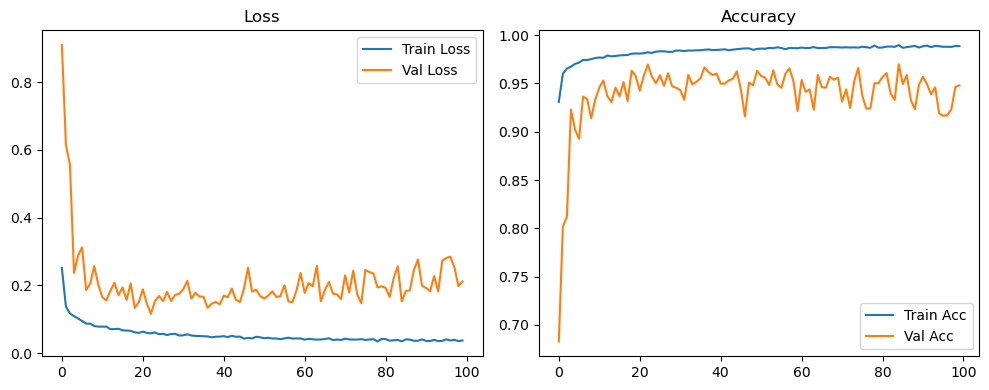

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1213, Acc: 0.9672 | Val Loss: 0.0665, Acc: 0.9795


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9844 | Val Loss: 0.0418, Acc: 0.9877


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0451, Acc: 0.9864


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9895 | Val Loss: 0.0465, Acc: 0.9863


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0494, Acc: 0.9861


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0410, Acc: 0.9893


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.0463, Acc: 0.9878


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.0421, Acc: 0.9882


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0406, Acc: 0.9885


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0467, Acc: 0.9896


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0436, Acc: 0.9891


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0573, Acc: 0.9872


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0503, Acc: 0.9882


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0540, Acc: 0.9893


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0508, Acc: 0.9889


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0510, Acc: 0.9900


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0513, Acc: 0.9892


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0467, Acc: 0.9907


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0433, Acc: 0.9908


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0532, Acc: 0.9900


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0530, Acc: 0.9892


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0771, Acc: 0.9862


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0619, Acc: 0.9900


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0584, Acc: 0.9890


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0585, Acc: 0.9898


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0540, Acc: 0.9906


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0629, Acc: 0.9900


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0566, Acc: 0.9909


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0641, Acc: 0.9892


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0623, Acc: 0.9909


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0607, Acc: 0.9902


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0795, Acc: 0.9877


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0597, Acc: 0.9900


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0607, Acc: 0.9896


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0609, Acc: 0.9913


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0605, Acc: 0.9902


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.0635, Acc: 0.9901


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0681, Acc: 0.9897


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0661, Acc: 0.9897


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0598, Acc: 0.9913


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0665, Acc: 0.9910


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0639, Acc: 0.9900


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.0720, Acc: 0.9889


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0655, Acc: 0.9908


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0713, Acc: 0.9883


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0671, Acc: 0.9902


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0739, Acc: 0.9892


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0820, Acc: 0.9888


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0781, Acc: 0.9905


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0659, Acc: 0.9902


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0591, Acc: 0.9917


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0605, Acc: 0.9923


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0567, Acc: 0.9928


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0643, Acc: 0.9908


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0622, Acc: 0.9919


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0633, Acc: 0.9928


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0605, Acc: 0.9925


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0612, Acc: 0.9924


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0624, Acc: 0.9917


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0777, Acc: 0.9915


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0668, Acc: 0.9918


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0612, Acc: 0.9914


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0598, Acc: 0.9922


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0641, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0668, Acc: 0.9916


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0738, Acc: 0.9916


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0677, Acc: 0.9916


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0702, Acc: 0.9923


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0652, Acc: 0.9923


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0664, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9920


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0714, Acc: 0.9910


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0692, Acc: 0.9918


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0739, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0716, Acc: 0.9918


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0686, Acc: 0.9926


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0678, Acc: 0.9923


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0744, Acc: 0.9914


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0758, Acc: 0.9920


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0828, Acc: 0.9920


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0754, Acc: 0.9913


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0786, Acc: 0.9916


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0773, Acc: 0.9923


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0694, Acc: 0.9919


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0730, Acc: 0.9923


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0750, Acc: 0.9918


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0740, Acc: 0.9925


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0764, Acc: 0.9924


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0782, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0776, Acc: 0.9923


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0796, Acc: 0.9916


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0726, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0747, Acc: 0.9921


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9929


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0734, Acc: 0.9926


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0731, Acc: 0.9915


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0664, Acc: 0.9924


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0702, Acc: 0.9928


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9928


Final Test Loss: 0.0602 Accuracy: 0.9923


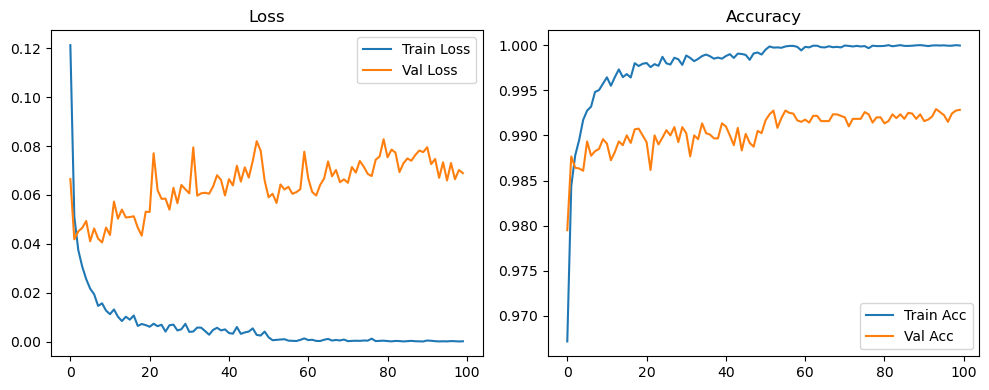

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1467, Acc: 0.9607 | Val Loss: 0.1002, Acc: 0.9688


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9788 | Val Loss: 0.0625, Acc: 0.9812


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9828 | Val Loss: 0.0497, Acc: 0.9852


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 0.0523, Acc: 0.9832


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9869 | Val Loss: 0.0577, Acc: 0.9828


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.0473, Acc: 0.9849


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9886 | Val Loss: 0.0625, Acc: 0.9801


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9892 | Val Loss: 0.0702, Acc: 0.9776


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.0575, Acc: 0.9824


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.0534, Acc: 0.9848


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.0510, Acc: 0.9843


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9920 | Val Loss: 0.0453, Acc: 0.9858


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0475, Acc: 0.9864


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.0459, Acc: 0.9871


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0430, Acc: 0.9878


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9934 | Val Loss: 0.0539, Acc: 0.9853


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0432, Acc: 0.9878


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0427, Acc: 0.9884


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0437, Acc: 0.9888


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0439, Acc: 0.9887


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0487, Acc: 0.9853


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0447, Acc: 0.9884


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0432, Acc: 0.9883


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0528, Acc: 0.9861


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0485, Acc: 0.9873


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.0482, Acc: 0.9874


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0570, Acc: 0.9865


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0524, Acc: 0.9875


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0405, Acc: 0.9892


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.0472, Acc: 0.9877


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0446, Acc: 0.9893


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0579, Acc: 0.9862


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0466, Acc: 0.9882


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0441, Acc: 0.9885


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0434, Acc: 0.9886


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0505, Acc: 0.9872


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.0484, Acc: 0.9883


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0441, Acc: 0.9883


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0508, Acc: 0.9875


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0495, Acc: 0.9872


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0526, Acc: 0.9874


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0542, Acc: 0.9863


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0470, Acc: 0.9897


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0527, Acc: 0.9889


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0428, Acc: 0.9891


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0400, Acc: 0.9900


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0553, Acc: 0.9864


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0421, Acc: 0.9911


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0485, Acc: 0.9887


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0466, Acc: 0.9893


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0393, Acc: 0.9899


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0441, Acc: 0.9908


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0410, Acc: 0.9904


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0412, Acc: 0.9907


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0387, Acc: 0.9914


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0377, Acc: 0.9915


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0363, Acc: 0.9916


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0394, Acc: 0.9906


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0363, Acc: 0.9907


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0423, Acc: 0.9909


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0439, Acc: 0.9902


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0408, Acc: 0.9910


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0400, Acc: 0.9905


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0383, Acc: 0.9923


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0445, Acc: 0.9907


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0414, Acc: 0.9902


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9985 | Val Loss: 0.0438, Acc: 0.9906


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0441, Acc: 0.9901


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0429, Acc: 0.9908


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0416, Acc: 0.9913


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0355, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0353, Acc: 0.9911


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0390, Acc: 0.9914


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0405, Acc: 0.9910


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0457, Acc: 0.9911


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0443, Acc: 0.9912


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0475, Acc: 0.9897


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0402, Acc: 0.9918


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0367, Acc: 0.9908


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0443, Acc: 0.9899


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0408, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0397, Acc: 0.9908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0406, Acc: 0.9905


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0376, Acc: 0.9912


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0450, Acc: 0.9903


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0413, Acc: 0.9904


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0389, Acc: 0.9908


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0407, Acc: 0.9915


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0400, Acc: 0.9912


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0430, Acc: 0.9912


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0412, Acc: 0.9914


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0434, Acc: 0.9903


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0395, Acc: 0.9917


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0408, Acc: 0.9914


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0397, Acc: 0.9924


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0432, Acc: 0.9908


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0437, Acc: 0.9909


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0422, Acc: 0.9907


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0426, Acc: 0.9908


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0414, Acc: 0.9911


Final Test Loss: 0.0385 Accuracy: 0.9909


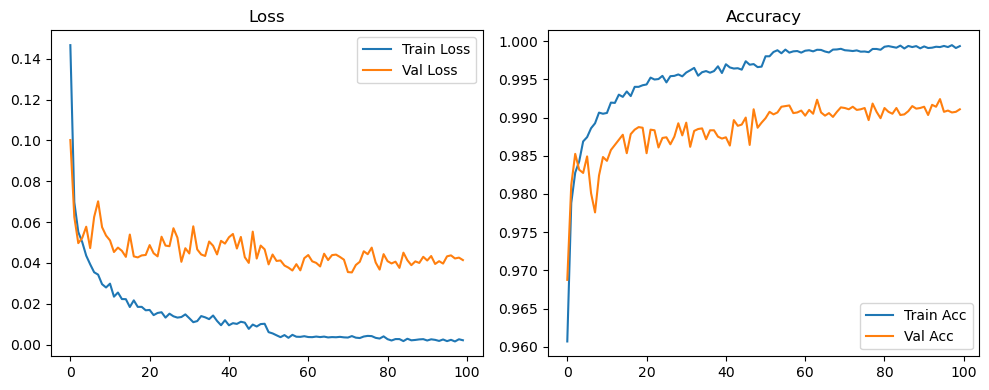

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2500, Acc: 0.9310 | Val Loss: 1.2183, Acc: 0.5863


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1380, Acc: 0.9598 | Val Loss: 0.4519, Acc: 0.8463


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1196, Acc: 0.9646 | Val Loss: 0.6737, Acc: 0.7527


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1094, Acc: 0.9682 | Val Loss: 0.2278, Acc: 0.9277


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0991, Acc: 0.9713 | Val Loss: 0.2041, Acc: 0.9351


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0939, Acc: 0.9717 | Val Loss: 0.3542, Acc: 0.8787


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9737 | Val Loss: 0.1703, Acc: 0.9439


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0875, Acc: 0.9745 | Val Loss: 0.1895, Acc: 0.9451


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9754 | Val Loss: 0.1821, Acc: 0.9422


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9755 | Val Loss: 0.1847, Acc: 0.9382


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9772 | Val Loss: 0.1666, Acc: 0.9498


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9764 | Val Loss: 0.1338, Acc: 0.9623


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9787 | Val Loss: 0.1724, Acc: 0.9436


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9779 | Val Loss: 0.1516, Acc: 0.9507


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9790 | Val Loss: 0.1802, Acc: 0.9369


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9801 | Val Loss: 0.1524, Acc: 0.9517


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9799 | Val Loss: 0.1625, Acc: 0.9455


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9801 | Val Loss: 0.1907, Acc: 0.9347


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9807 | Val Loss: 0.1112, Acc: 0.9668


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9818 | Val Loss: 0.1765, Acc: 0.9403


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9808 | Val Loss: 0.1980, Acc: 0.9333


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9822 | Val Loss: 0.1342, Acc: 0.9587


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9821 | Val Loss: 0.1381, Acc: 0.9612


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9819 | Val Loss: 0.1661, Acc: 0.9499


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9817 | Val Loss: 0.1321, Acc: 0.9599


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9830 | Val Loss: 0.1698, Acc: 0.9473


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9836 | Val Loss: 0.1345, Acc: 0.9592


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9821 | Val Loss: 0.1438, Acc: 0.9582


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9836 | Val Loss: 0.1579, Acc: 0.9508


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9834 | Val Loss: 0.1824, Acc: 0.9402


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9832 | Val Loss: 0.2049, Acc: 0.9344


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.2141, Acc: 0.9301


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9839 | Val Loss: 0.2374, Acc: 0.9198


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9842 | Val Loss: 0.1982, Acc: 0.9379


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9839 | Val Loss: 0.1645, Acc: 0.9531


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9846 | Val Loss: 0.1410, Acc: 0.9657


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 0.1713, Acc: 0.9523


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9841 | Val Loss: 0.1597, Acc: 0.9549


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9853 | Val Loss: 0.2470, Acc: 0.9114


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.1368, Acc: 0.9607


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9846 | Val Loss: 0.1927, Acc: 0.9395


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9850 | Val Loss: 0.1799, Acc: 0.9455


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9845 | Val Loss: 0.1668, Acc: 0.9493


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.1696, Acc: 0.9447


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9845 | Val Loss: 0.2540, Acc: 0.9156


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1421, Acc: 0.9569


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9854 | Val Loss: 0.2700, Acc: 0.8973


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9862 | Val Loss: 0.1553, Acc: 0.9480


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 0.1808, Acc: 0.9456


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9864 | Val Loss: 0.1646, Acc: 0.9510


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9878 | Val Loss: 0.1876, Acc: 0.9427


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.1830, Acc: 0.9469


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.1987, Acc: 0.9325


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9884 | Val Loss: 0.1852, Acc: 0.9427


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.2226, Acc: 0.9184


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.1419, Acc: 0.9593


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9884 | Val Loss: 0.1640, Acc: 0.9499


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.1701, Acc: 0.9474


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.1559, Acc: 0.9509


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.2030, Acc: 0.9348


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9903 | Val Loss: 0.1736, Acc: 0.9540


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.1521, Acc: 0.9593


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.1714, Acc: 0.9506


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.1543, Acc: 0.9553


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.1801, Acc: 0.9449


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.1494, Acc: 0.9583


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.1643, Acc: 0.9589


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 0.1989, Acc: 0.9445


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9901 | Val Loss: 0.2206, Acc: 0.9324


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.1984, Acc: 0.9386


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.2056, Acc: 0.9357


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.1925, Acc: 0.9488


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9900 | Val Loss: 0.2107, Acc: 0.9317


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.1886, Acc: 0.9466


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.1859, Acc: 0.9493


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.1775, Acc: 0.9507


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9906 | Val Loss: 0.2281, Acc: 0.9272


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.2377, Acc: 0.9222


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.2052, Acc: 0.9389


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.2414, Acc: 0.9291


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.1849, Acc: 0.9509


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.1929, Acc: 0.9493


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.1965, Acc: 0.9468


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.1809, Acc: 0.9471


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.1870, Acc: 0.9531


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.2040, Acc: 0.9389


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9919 | Val Loss: 0.1940, Acc: 0.9475


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.2121, Acc: 0.9363


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.2151, Acc: 0.9341


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.1985, Acc: 0.9478


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.2034, Acc: 0.9429


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.2041, Acc: 0.9409


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.2117, Acc: 0.9437


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.2008, Acc: 0.9429


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.1992, Acc: 0.9452


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9918 | Val Loss: 0.2126, Acc: 0.9402


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.2155, Acc: 0.9459


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.1973, Acc: 0.9467


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.1942, Acc: 0.9541


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.1754, Acc: 0.9578


Final Test Loss: 0.1769 Accuracy: 0.9563


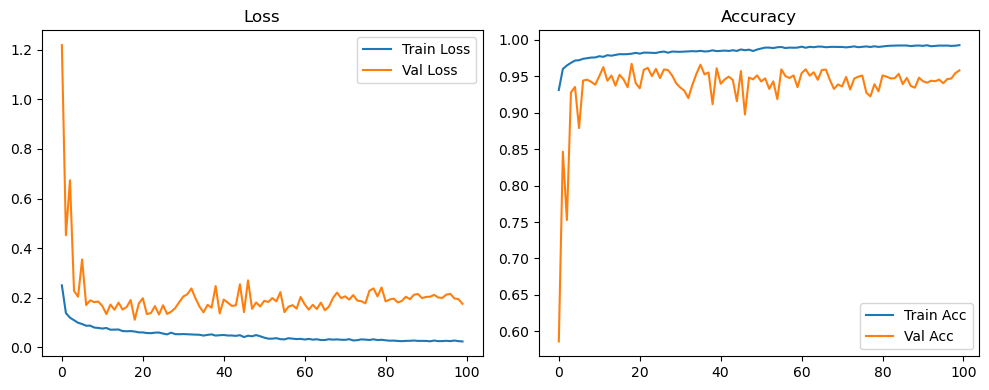

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1401, Acc: 0.9678 | Val Loss: 0.0529, Acc: 0.9841


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9847 | Val Loss: 0.0509, Acc: 0.9844


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0432, Acc: 0.9867


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.0379, Acc: 0.9888


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0452, Acc: 0.9864


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0410, Acc: 0.9888


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0443, Acc: 0.9879


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.0502, Acc: 0.9868


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9953 | Val Loss: 0.0427, Acc: 0.9888


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.0418, Acc: 0.9891


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.0490, Acc: 0.9875


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0408, Acc: 0.9898


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0439, Acc: 0.9896


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0479, Acc: 0.9889


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0461, Acc: 0.9892


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0435, Acc: 0.9902


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0553, Acc: 0.9875


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0477, Acc: 0.9893


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0424, Acc: 0.9905


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0420, Acc: 0.9909


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0424, Acc: 0.9914


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0469, Acc: 0.9892


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0439, Acc: 0.9898


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0434, Acc: 0.9899


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0504, Acc: 0.9897


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0526, Acc: 0.9902


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0620, Acc: 0.9882


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0607, Acc: 0.9895


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0531, Acc: 0.9888


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0460, Acc: 0.9912


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0479, Acc: 0.9912


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0551, Acc: 0.9889


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0491, Acc: 0.9909


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0501, Acc: 0.9900


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0530, Acc: 0.9885


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0532, Acc: 0.9895


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0468, Acc: 0.9909


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0472, Acc: 0.9915


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0488, Acc: 0.9917


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0553, Acc: 0.9895


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0618, Acc: 0.9898


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0563, Acc: 0.9901


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0538, Acc: 0.9904


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0582, Acc: 0.9911


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0589, Acc: 0.9903


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0578, Acc: 0.9914


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0569, Acc: 0.9914


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0569, Acc: 0.9900


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0523, Acc: 0.9913


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0528, Acc: 0.9904


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0489, Acc: 0.9915


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0521, Acc: 0.9919


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0509, Acc: 0.9920


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0589, Acc: 0.9904


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.0555, Acc: 0.9912


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0572, Acc: 0.9906


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0574, Acc: 0.9908


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0524, Acc: 0.9912


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0640, Acc: 0.9903


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0525, Acc: 0.9907


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0712, Acc: 0.9885


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0616, Acc: 0.9901


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0555, Acc: 0.9908


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0563, Acc: 0.9915


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0613, Acc: 0.9913


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0612, Acc: 0.9908


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0745, Acc: 0.9874


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0536, Acc: 0.9917


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0560, Acc: 0.9922


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0664, Acc: 0.9908


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0625, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0658, Acc: 0.9917


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0686, Acc: 0.9911


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0728, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0649, Acc: 0.9917


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0693, Acc: 0.9903


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0710, Acc: 0.9904


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0629, Acc: 0.9904


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0661, Acc: 0.9905


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0631, Acc: 0.9915


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0667, Acc: 0.9898


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0657, Acc: 0.9913


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0649, Acc: 0.9904


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0690, Acc: 0.9899


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0687, Acc: 0.9902


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0610, Acc: 0.9910


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0745, Acc: 0.9902


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0687, Acc: 0.9913


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0687, Acc: 0.9910


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0677, Acc: 0.9906


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0830, Acc: 0.9899


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0704, Acc: 0.9907


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0632, Acc: 0.9902


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0694, Acc: 0.9919


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0674, Acc: 0.9911


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0807, Acc: 0.9900


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0750, Acc: 0.9911


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0678, Acc: 0.9906


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0644, Acc: 0.9909


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0867, Acc: 0.9889


Final Test Loss: 0.0771 Accuracy: 0.9887


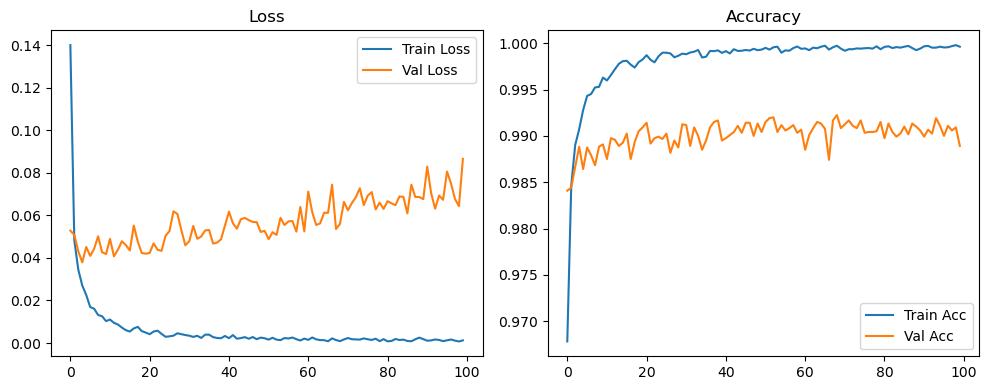

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1674, Acc: 0.9615 | Val Loss: 0.1360, Acc: 0.9581


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9794 | Val Loss: 0.0680, Acc: 0.9800


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0529, Acc: 0.9832 | Val Loss: 0.0951, Acc: 0.9699


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9859 | Val Loss: 0.0654, Acc: 0.9800


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9868 | Val Loss: 0.0617, Acc: 0.9816


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9891 | Val Loss: 0.0550, Acc: 0.9831


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0577, Acc: 0.9829


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.0472, Acc: 0.9858


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.0392, Acc: 0.9889


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0476, Acc: 0.9864


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9916 | Val Loss: 0.0481, Acc: 0.9864


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9923 | Val Loss: 0.0432, Acc: 0.9874


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9926 | Val Loss: 0.0501, Acc: 0.9858


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0494, Acc: 0.9853


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0390, Acc: 0.9894


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9926 | Val Loss: 0.0524, Acc: 0.9850


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0468, Acc: 0.9868


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9944 | Val Loss: 0.0388, Acc: 0.9890


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0395, Acc: 0.9898


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0395, Acc: 0.9878


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0483, Acc: 0.9862


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0475, Acc: 0.9869


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0573, Acc: 0.9847


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0379, Acc: 0.9893


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0505, Acc: 0.9873


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0493, Acc: 0.9873


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9954 | Val Loss: 0.0476, Acc: 0.9872


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0545, Acc: 0.9866


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.0424, Acc: 0.9880


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0450, Acc: 0.9882


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0404, Acc: 0.9896


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0475, Acc: 0.9879


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0480, Acc: 0.9881


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0433, Acc: 0.9891


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0459, Acc: 0.9892


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.0510, Acc: 0.9862


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9958 | Val Loss: 0.0404, Acc: 0.9891


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0428, Acc: 0.9898


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0418, Acc: 0.9888


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0375, Acc: 0.9899


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0392, Acc: 0.9898


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0411, Acc: 0.9895


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0377, Acc: 0.9897


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0422, Acc: 0.9892


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0360, Acc: 0.9908


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0437, Acc: 0.9883


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0679, Acc: 0.9834


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0432, Acc: 0.9900


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0408, Acc: 0.9892


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0393, Acc: 0.9907


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0429, Acc: 0.9882


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0450, Acc: 0.9882


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0510, Acc: 0.9868


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0374, Acc: 0.9902


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0413, Acc: 0.9898


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0427, Acc: 0.9891


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0530, Acc: 0.9872


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0466, Acc: 0.9884


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0434, Acc: 0.9893


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0462, Acc: 0.9882


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0412, Acc: 0.9898


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0479, Acc: 0.9882


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0411, Acc: 0.9896


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0391, Acc: 0.9900


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0378, Acc: 0.9909


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0398, Acc: 0.9898


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0428, Acc: 0.9908


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0403, Acc: 0.9906


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0450, Acc: 0.9894


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0420, Acc: 0.9889


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0407, Acc: 0.9894


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0475, Acc: 0.9882


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0355, Acc: 0.9918


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0397, Acc: 0.9905


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0378, Acc: 0.9910


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0507, Acc: 0.9892


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0504, Acc: 0.9872


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0370, Acc: 0.9906


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0435, Acc: 0.9900


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0422, Acc: 0.9896


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0439, Acc: 0.9893


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0428, Acc: 0.9890


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0438, Acc: 0.9879


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0392, Acc: 0.9902


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0422, Acc: 0.9904


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0363, Acc: 0.9900


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0336, Acc: 0.9909


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0427, Acc: 0.9892


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0353, Acc: 0.9910


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0418, Acc: 0.9898


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0461, Acc: 0.9884


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0423, Acc: 0.9904


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0422, Acc: 0.9894


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0349, Acc: 0.9913


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0435, Acc: 0.9901


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0383, Acc: 0.9903


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0448, Acc: 0.9884


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0506, Acc: 0.9862


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0365, Acc: 0.9899


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0342, Acc: 0.9911


Final Test Loss: 0.0414 Accuracy: 0.9889


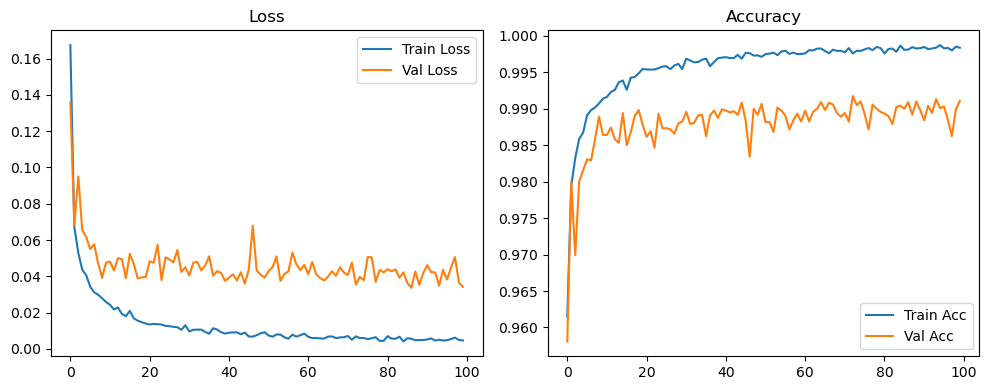

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2792, Acc: 0.9325 | Val Loss: 1.0266, Acc: 0.6469


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1332, Acc: 0.9620 | Val Loss: 0.5010, Acc: 0.8273


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1116, Acc: 0.9676 | Val Loss: 0.6510, Acc: 0.7682


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1041, Acc: 0.9691 | Val Loss: 0.4001, Acc: 0.8578


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0945, Acc: 0.9729 | Val Loss: 0.2537, Acc: 0.9171


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0901, Acc: 0.9733 | Val Loss: 0.4066, Acc: 0.8595


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0816, Acc: 0.9753 | Val Loss: 0.2069, Acc: 0.9312


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0826, Acc: 0.9749 | Val Loss: 0.2281, Acc: 0.9274


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9772 | Val Loss: 0.3295, Acc: 0.8832


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9773 | Val Loss: 0.3110, Acc: 0.8909


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0701, Acc: 0.9785 | Val Loss: 0.1979, Acc: 0.9318


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9790 | Val Loss: 0.1657, Acc: 0.9464


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9797 | Val Loss: 0.2161, Acc: 0.9273


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9804 | Val Loss: 0.2167, Acc: 0.9276


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0615, Acc: 0.9812 | Val Loss: 0.1596, Acc: 0.9474


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0619, Acc: 0.9805 | Val Loss: 0.1983, Acc: 0.9336


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0599, Acc: 0.9815 | Val Loss: 0.1630, Acc: 0.9448


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9813 | Val Loss: 0.2152, Acc: 0.9269


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0584, Acc: 0.9824 | Val Loss: 0.2005, Acc: 0.9283


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0565, Acc: 0.9826 | Val Loss: 0.2232, Acc: 0.9222


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9818 | Val Loss: 0.2076, Acc: 0.9279


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9833 | Val Loss: 0.1208, Acc: 0.9611


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9830 | Val Loss: 0.1581, Acc: 0.9505


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9830 | Val Loss: 0.1612, Acc: 0.9499


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9834 | Val Loss: 0.2134, Acc: 0.9301


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9840 | Val Loss: 0.2040, Acc: 0.9356


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9842 | Val Loss: 0.1831, Acc: 0.9392


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9837 | Val Loss: 0.1987, Acc: 0.9398


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9844 | Val Loss: 0.1809, Acc: 0.9419


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9844 | Val Loss: 0.2732, Acc: 0.9068


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9848 | Val Loss: 0.1599, Acc: 0.9522


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9854 | Val Loss: 0.1497, Acc: 0.9589


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9848 | Val Loss: 0.1827, Acc: 0.9476


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9859 | Val Loss: 0.1641, Acc: 0.9540


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9858 | Val Loss: 0.1507, Acc: 0.9578


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9868 | Val Loss: 0.1513, Acc: 0.9587


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9860 | Val Loss: 0.1599, Acc: 0.9525


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9864 | Val Loss: 0.1523, Acc: 0.9569


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9862 | Val Loss: 0.1595, Acc: 0.9547


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.1801, Acc: 0.9453


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9860 | Val Loss: 0.1574, Acc: 0.9585


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9868 | Val Loss: 0.2096, Acc: 0.9358


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9861 | Val Loss: 0.2188, Acc: 0.9302


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9870 | Val Loss: 0.2214, Acc: 0.9309


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.1532, Acc: 0.9597


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.2109, Acc: 0.9350


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.2644, Acc: 0.9107


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9876 | Val Loss: 0.1653, Acc: 0.9546


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.2009, Acc: 0.9467


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1790, Acc: 0.9587


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9870 | Val Loss: 0.1684, Acc: 0.9607


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9881 | Val Loss: 0.1594, Acc: 0.9637


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9874 | Val Loss: 0.1823, Acc: 0.9534


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9877 | Val Loss: 0.2079, Acc: 0.9483


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.2092, Acc: 0.9498


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.1862, Acc: 0.9524


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9876 | Val Loss: 0.1944, Acc: 0.9450


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9868 | Val Loss: 0.1832, Acc: 0.9513


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.1842, Acc: 0.9527


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9873 | Val Loss: 0.2204, Acc: 0.9331


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9884 | Val Loss: 0.2422, Acc: 0.9243


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9885 | Val Loss: 0.2123, Acc: 0.9416


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.2222, Acc: 0.9398


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.1986, Acc: 0.9501


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9897 | Val Loss: 0.2172, Acc: 0.9371


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.2086, Acc: 0.9405


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9878 | Val Loss: 0.2643, Acc: 0.9107


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9887 | Val Loss: 0.2598, Acc: 0.9272


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.2373, Acc: 0.9375


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9880 | Val Loss: 0.2359, Acc: 0.9343


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.2444, Acc: 0.9327


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.2551, Acc: 0.9257


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.2134, Acc: 0.9483


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 0.2450, Acc: 0.9250


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9886 | Val Loss: 0.2187, Acc: 0.9435


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9897 | Val Loss: 0.2762, Acc: 0.9149


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9893 | Val Loss: 0.3194, Acc: 0.8902


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.2214, Acc: 0.9333


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.2246, Acc: 0.9353


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9883 | Val Loss: 0.2258, Acc: 0.9372


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.2148, Acc: 0.9451


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.2334, Acc: 0.9283


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.2124, Acc: 0.9459


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.1992, Acc: 0.9563


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9898 | Val Loss: 0.2293, Acc: 0.9376


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9890 | Val Loss: 0.2191, Acc: 0.9437


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.2087, Acc: 0.9537


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 0.2577, Acc: 0.9209


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.2371, Acc: 0.9484


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.2657, Acc: 0.9225


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9895 | Val Loss: 0.2460, Acc: 0.9367


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.1961, Acc: 0.9570


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.2147, Acc: 0.9533


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.2070, Acc: 0.9516


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.2446, Acc: 0.9228


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9899 | Val Loss: 0.2977, Acc: 0.9077


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.2271, Acc: 0.9459


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9893 | Val Loss: 0.3029, Acc: 0.9069


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.2452, Acc: 0.9338


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.1912, Acc: 0.9517


Final Test Loss: 0.1869 Accuracy: 0.9524


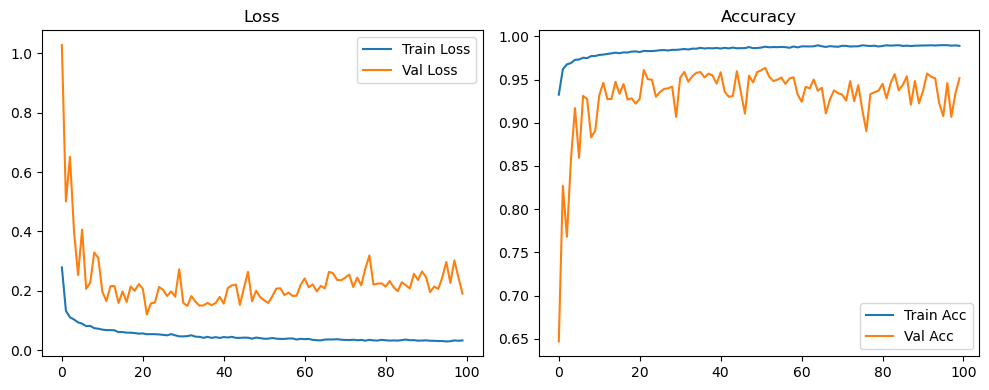

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1779, Acc: 0.9677 | Val Loss: 0.0641, Acc: 0.9808


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9849 | Val Loss: 0.0450, Acc: 0.9872


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9892 | Val Loss: 0.0491, Acc: 0.9856


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9921 | Val Loss: 0.0408, Acc: 0.9869


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0414, Acc: 0.9885


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0403, Acc: 0.9881


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0367, Acc: 0.9894


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0374, Acc: 0.9886


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0373, Acc: 0.9875


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0486, Acc: 0.9869


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0451, Acc: 0.9866


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0445, Acc: 0.9886


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0500, Acc: 0.9863


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0430, Acc: 0.9888


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0477, Acc: 0.9876


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0488, Acc: 0.9874


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0476, Acc: 0.9886


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0438, Acc: 0.9888


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0415, Acc: 0.9889


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0497, Acc: 0.9874


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0537, Acc: 0.9876


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0441, Acc: 0.9887


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0440, Acc: 0.9889


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0495, Acc: 0.9888


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0484, Acc: 0.9882


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0415, Acc: 0.9902


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0476, Acc: 0.9899


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0450, Acc: 0.9893


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0529, Acc: 0.9883


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0579, Acc: 0.9884


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0494, Acc: 0.9902


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0542, Acc: 0.9884


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.0459, Acc: 0.9898


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0482, Acc: 0.9896


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0470, Acc: 0.9894


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0435, Acc: 0.9900


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0472, Acc: 0.9890


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0472, Acc: 0.9906


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0396, Acc: 0.9914


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0472, Acc: 0.9899


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0522, Acc: 0.9897


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0507, Acc: 0.9890


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0510, Acc: 0.9884


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0501, Acc: 0.9904


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0557, Acc: 0.9892


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0474, Acc: 0.9908


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0567, Acc: 0.9896


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0555, Acc: 0.9898


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0491, Acc: 0.9902


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0567, Acc: 0.9907


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0488, Acc: 0.9910


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0543, Acc: 0.9902


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0486, Acc: 0.9901


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0554, Acc: 0.9888


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0633, Acc: 0.9884


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0560, Acc: 0.9888


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0527, Acc: 0.9902


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0592, Acc: 0.9895


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0482, Acc: 0.9903


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0517, Acc: 0.9904


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0571, Acc: 0.9907


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0480, Acc: 0.9901


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0454, Acc: 0.9912


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0494, Acc: 0.9908


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0442, Acc: 0.9907


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0476, Acc: 0.9909


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0491, Acc: 0.9902


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0551, Acc: 0.9904


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0537, Acc: 0.9907


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0477, Acc: 0.9908


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0485, Acc: 0.9910


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0583, Acc: 0.9900


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0496, Acc: 0.9919


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0527, Acc: 0.9906


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0504, Acc: 0.9912


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0618, Acc: 0.9886


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0582, Acc: 0.9902


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0506, Acc: 0.9908


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0571, Acc: 0.9901


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0588, Acc: 0.9897


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0576, Acc: 0.9905


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0526, Acc: 0.9896


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0527, Acc: 0.9905


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0552, Acc: 0.9914


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0573, Acc: 0.9914


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0480, Acc: 0.9908


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0575, Acc: 0.9904


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0541, Acc: 0.9916


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0592, Acc: 0.9905


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0619, Acc: 0.9899


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0594, Acc: 0.9911


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0526, Acc: 0.9915


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0568, Acc: 0.9908


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0497, Acc: 0.9916


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0665, Acc: 0.9898


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0521, Acc: 0.9902


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0577, Acc: 0.9899


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0482, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0584, Acc: 0.9905


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0599, Acc: 0.9909


Final Test Loss: 0.0508 Accuracy: 0.9912


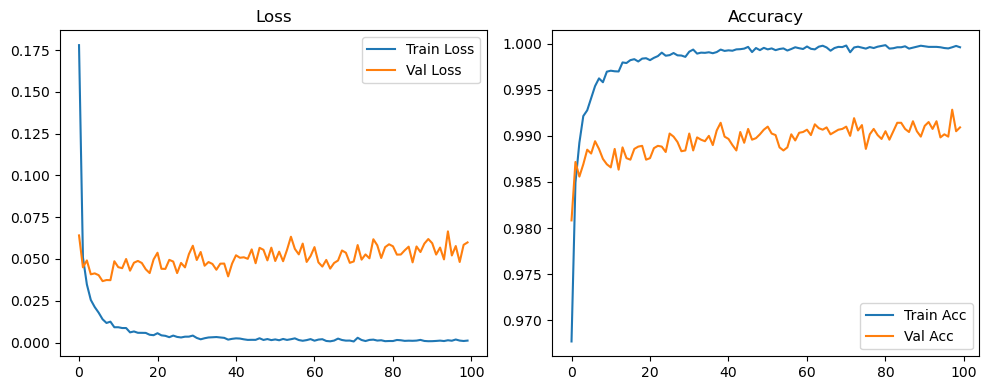

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2129, Acc: 0.9599 | Val Loss: 0.1360, Acc: 0.9650


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9797 | Val Loss: 0.0659, Acc: 0.9821


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9837 | Val Loss: 0.0800, Acc: 0.9764


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.0696, Acc: 0.9785


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9869 | Val Loss: 0.0629, Acc: 0.9801


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.0605, Acc: 0.9812


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.0539, Acc: 0.9837


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.0514, Acc: 0.9843


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.0429, Acc: 0.9878


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0476, Acc: 0.9850


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.0596, Acc: 0.9822


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9924 | Val Loss: 0.0511, Acc: 0.9849


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.0501, Acc: 0.9852


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0449, Acc: 0.9870


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0403, Acc: 0.9885


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0443, Acc: 0.9872


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0499, Acc: 0.9853


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0451, Acc: 0.9858


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0440, Acc: 0.9873


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0472, Acc: 0.9861


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0426, Acc: 0.9875


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.0378, Acc: 0.9889


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0421, Acc: 0.9884


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0418, Acc: 0.9879


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9949 | Val Loss: 0.0490, Acc: 0.9865


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0468, Acc: 0.9866


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0502, Acc: 0.9855


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0441, Acc: 0.9870


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0422, Acc: 0.9875


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0536, Acc: 0.9855


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0520, Acc: 0.9852


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0576, Acc: 0.9827


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0492, Acc: 0.9865


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0398, Acc: 0.9892


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0341, Acc: 0.9904


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0412, Acc: 0.9882


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0388, Acc: 0.9890


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0378, Acc: 0.9895


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0436, Acc: 0.9882


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0404, Acc: 0.9890


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0500, Acc: 0.9871


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0435, Acc: 0.9881


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0432, Acc: 0.9884


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0423, Acc: 0.9891


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0454, Acc: 0.9875


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0442, Acc: 0.9873


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0535, Acc: 0.9853


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0429, Acc: 0.9899


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0463, Acc: 0.9882


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0394, Acc: 0.9890


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0388, Acc: 0.9908


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0420, Acc: 0.9897


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0374, Acc: 0.9899


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0387, Acc: 0.9891


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0429, Acc: 0.9884


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0380, Acc: 0.9905


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0376, Acc: 0.9905


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0361, Acc: 0.9899


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0407, Acc: 0.9894


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0433, Acc: 0.9891


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0455, Acc: 0.9893


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0436, Acc: 0.9881


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0378, Acc: 0.9901


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0435, Acc: 0.9888


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0375, Acc: 0.9898


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0374, Acc: 0.9902


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0369, Acc: 0.9903


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.0465, Acc: 0.9873


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0389, Acc: 0.9892


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9976 | Val Loss: 0.0401, Acc: 0.9897


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0415, Acc: 0.9898


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0420, Acc: 0.9890


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0392, Acc: 0.9889


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0381, Acc: 0.9889


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0474, Acc: 0.9866


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0450, Acc: 0.9872


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0428, Acc: 0.9892


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0432, Acc: 0.9885


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0403, Acc: 0.9894


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0397, Acc: 0.9889


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0428, Acc: 0.9888


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0428, Acc: 0.9891


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0386, Acc: 0.9892


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0378, Acc: 0.9901


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0408, Acc: 0.9899


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0402, Acc: 0.9899


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0360, Acc: 0.9906


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0422, Acc: 0.9896


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0357, Acc: 0.9908


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0359, Acc: 0.9909


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0389, Acc: 0.9898


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0367, Acc: 0.9897


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0360, Acc: 0.9900


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0360, Acc: 0.9902


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0383, Acc: 0.9899


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0364, Acc: 0.9902


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0349, Acc: 0.9911


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0374, Acc: 0.9907


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.0361, Acc: 0.9904


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0326, Acc: 0.9908


Final Test Loss: 0.0355 Accuracy: 0.9901


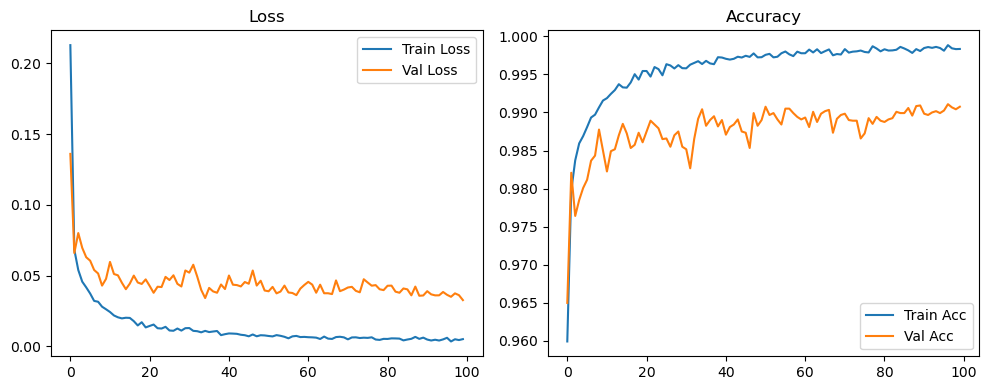

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3449, Acc: 0.9273 | Val Loss: 1.0702, Acc: 0.6063


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1397, Acc: 0.9607 | Val Loss: 0.8535, Acc: 0.6955


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1148, Acc: 0.9675 | Val Loss: 0.6627, Acc: 0.7681


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1036, Acc: 0.9702 | Val Loss: 0.5335, Acc: 0.8119


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0956, Acc: 0.9723 | Val Loss: 0.3277, Acc: 0.8909


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0942, Acc: 0.9718 | Val Loss: 0.4717, Acc: 0.8353


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0846, Acc: 0.9748 | Val Loss: 0.3396, Acc: 0.8832


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0843, Acc: 0.9751 | Val Loss: 0.2772, Acc: 0.9052


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9761 | Val Loss: 0.2993, Acc: 0.8995


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0743, Acc: 0.9778 | Val Loss: 0.2570, Acc: 0.9127


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0720, Acc: 0.9780 | Val Loss: 0.2149, Acc: 0.9276


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0733, Acc: 0.9779 | Val Loss: 0.1801, Acc: 0.9439


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0689, Acc: 0.9791 | Val Loss: 0.2706, Acc: 0.9083


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9792 | Val Loss: 0.2320, Acc: 0.9237


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9801 | Val Loss: 0.2111, Acc: 0.9328


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0627, Acc: 0.9803 | Val Loss: 0.1782, Acc: 0.9460


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9810 | Val Loss: 0.1922, Acc: 0.9377


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0604, Acc: 0.9813 | Val Loss: 0.1796, Acc: 0.9426


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9824 | Val Loss: 0.1701, Acc: 0.9442


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9814 | Val Loss: 0.2051, Acc: 0.9309


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0592, Acc: 0.9823 | Val Loss: 0.1823, Acc: 0.9414


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9821 | Val Loss: 0.1636, Acc: 0.9467


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9830 | Val Loss: 0.1518, Acc: 0.9540


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9825 | Val Loss: 0.1895, Acc: 0.9377


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0568, Acc: 0.9828 | Val Loss: 0.1723, Acc: 0.9453


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9832 | Val Loss: 0.1593, Acc: 0.9526


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0504, Acc: 0.9846 | Val Loss: 0.2071, Acc: 0.9315


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9834 | Val Loss: 0.1569, Acc: 0.9554


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9845 | Val Loss: 0.1561, Acc: 0.9528


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9841 | Val Loss: 0.1412, Acc: 0.9564


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9842 | Val Loss: 0.1772, Acc: 0.9470


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9847 | Val Loss: 0.1358, Acc: 0.9618


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9852 | Val Loss: 0.1420, Acc: 0.9599


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9850 | Val Loss: 0.1314, Acc: 0.9627


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.1316, Acc: 0.9652


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1400, Acc: 0.9582


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9854 | Val Loss: 0.1528, Acc: 0.9552


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.1520, Acc: 0.9567


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9853 | Val Loss: 0.1486, Acc: 0.9607


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9857 | Val Loss: 0.1470, Acc: 0.9614


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9864 | Val Loss: 0.1532, Acc: 0.9574


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9856 | Val Loss: 0.1368, Acc: 0.9638


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9860 | Val Loss: 0.1681, Acc: 0.9506


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9872 | Val Loss: 0.1408, Acc: 0.9618


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9864 | Val Loss: 0.1732, Acc: 0.9506


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9877 | Val Loss: 0.1401, Acc: 0.9606


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.1801, Acc: 0.9445


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9872 | Val Loss: 0.1624, Acc: 0.9549


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9869 | Val Loss: 0.1522, Acc: 0.9593


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9867 | Val Loss: 0.1457, Acc: 0.9627


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 0.1833, Acc: 0.9413


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9874 | Val Loss: 0.1879, Acc: 0.9453


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9871 | Val Loss: 0.1662, Acc: 0.9544


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9868 | Val Loss: 0.2160, Acc: 0.9359


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.1747, Acc: 0.9508


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9876 | Val Loss: 0.1496, Acc: 0.9649


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9875 | Val Loss: 0.1938, Acc: 0.9504


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9873 | Val Loss: 0.1689, Acc: 0.9493


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1602, Acc: 0.9572


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.1683, Acc: 0.9563


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.1659, Acc: 0.9602


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.1661, Acc: 0.9622


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9877 | Val Loss: 0.1299, Acc: 0.9695


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9882 | Val Loss: 0.1628, Acc: 0.9609


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9880 | Val Loss: 0.1677, Acc: 0.9602


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9880 | Val Loss: 0.1420, Acc: 0.9602


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9887 | Val Loss: 0.2084, Acc: 0.9547


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.1925, Acc: 0.9537


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9880 | Val Loss: 0.1799, Acc: 0.9592


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.1824, Acc: 0.9553


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.1897, Acc: 0.9578


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9886 | Val Loss: 0.2046, Acc: 0.9452


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.1939, Acc: 0.9454


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9878 | Val Loss: 0.1749, Acc: 0.9584


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9882 | Val Loss: 0.1513, Acc: 0.9650


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.2017, Acc: 0.9536


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9891 | Val Loss: 0.2456, Acc: 0.9315


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9883 | Val Loss: 0.1965, Acc: 0.9517


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9895 | Val Loss: 0.1949, Acc: 0.9573


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9872 | Val Loss: 0.1929, Acc: 0.9499


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.1769, Acc: 0.9575


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.2103, Acc: 0.9488


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9883 | Val Loss: 0.1968, Acc: 0.9484


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.1491, Acc: 0.9647


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9906 | Val Loss: 0.1821, Acc: 0.9556


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1910, Acc: 0.9533


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.1662, Acc: 0.9610


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.2007, Acc: 0.9494


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.1781, Acc: 0.9632


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9884 | Val Loss: 0.2055, Acc: 0.9503


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.1992, Acc: 0.9540


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.1955, Acc: 0.9573


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.1604, Acc: 0.9642


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.1578, Acc: 0.9668


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9896 | Val Loss: 0.1795, Acc: 0.9623


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.2192, Acc: 0.9404


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9906 | Val Loss: 0.2008, Acc: 0.9555


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.1961, Acc: 0.9541


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9893 | Val Loss: 0.1439, Acc: 0.9683


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.1862, Acc: 0.9633


Final Test Loss: 0.1833 Accuracy: 0.9650


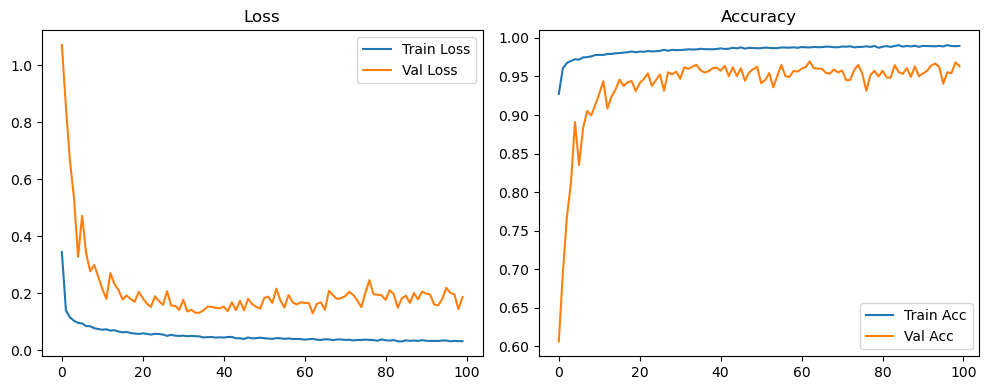

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9645 | Val Loss: 0.0623, Acc: 0.9808


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9842 | Val Loss: 0.0550, Acc: 0.9835


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9875 | Val Loss: 0.0554, Acc: 0.9822


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0474, Acc: 0.9869


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.0547, Acc: 0.9838


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0497, Acc: 0.9865


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0519, Acc: 0.9863


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0619, Acc: 0.9842


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0550, Acc: 0.9865


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0504, Acc: 0.9871


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0532, Acc: 0.9866


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0536, Acc: 0.9881


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0458, Acc: 0.9898


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0499, Acc: 0.9899


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0613, Acc: 0.9860


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0579, Acc: 0.9888


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0827, Acc: 0.9825


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0666, Acc: 0.9868


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0583, Acc: 0.9880


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0629, Acc: 0.9873


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0572, Acc: 0.9893


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0653, Acc: 0.9881


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0557, Acc: 0.9895


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0787, Acc: 0.9863


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0696, Acc: 0.9879


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0742, Acc: 0.9888


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.0568, Acc: 0.9898


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0645, Acc: 0.9892


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0587, Acc: 0.9896


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0625, Acc: 0.9902


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0616, Acc: 0.9903


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0669, Acc: 0.9910


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0665, Acc: 0.9896


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0734, Acc: 0.9880


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0811, Acc: 0.9896


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0768, Acc: 0.9894


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0639, Acc: 0.9906


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0877, Acc: 0.9882


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0694, Acc: 0.9905


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0743, Acc: 0.9891


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.0621, Acc: 0.9899


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0688, Acc: 0.9896


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0859, Acc: 0.9886


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0850, Acc: 0.9882


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0740, Acc: 0.9905


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0878, Acc: 0.9893


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0945, Acc: 0.9887


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0951, Acc: 0.9900


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0780, Acc: 0.9909


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.0948, Acc: 0.9888


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0812, Acc: 0.9900


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0914, Acc: 0.9895


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0864, Acc: 0.9889


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0836, Acc: 0.9900


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0802, Acc: 0.9911


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1005, Acc: 0.9890


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.0863, Acc: 0.9908


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.0897, Acc: 0.9891


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0965, Acc: 0.9893


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1095, Acc: 0.9892


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0873, Acc: 0.9889


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0918, Acc: 0.9896


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0872, Acc: 0.9895


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9990 | Val Loss: 0.0927, Acc: 0.9906


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.0842, Acc: 0.9907


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0824, Acc: 0.9907


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1036, Acc: 0.9884


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0829, Acc: 0.9905


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0898, Acc: 0.9911


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.0933, Acc: 0.9903


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1125, Acc: 0.9876


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.0967, Acc: 0.9900


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9991 | Val Loss: 0.1073, Acc: 0.9893


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0891, Acc: 0.9905


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0865, Acc: 0.9902


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1016, Acc: 0.9898


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1022, Acc: 0.9907


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9992 | Val Loss: 0.0988, Acc: 0.9903


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1147, Acc: 0.9886


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1002, Acc: 0.9904


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.0973, Acc: 0.9898


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1010, Acc: 0.9913


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0970, Acc: 0.9915


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1109, Acc: 0.9888


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1080, Acc: 0.9901


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.0961, Acc: 0.9902


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0951, Acc: 0.9912


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1233, Acc: 0.9898


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.1194, Acc: 0.9901


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1247, Acc: 0.9901


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.1155, Acc: 0.9908


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1098, Acc: 0.9902


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0910, Acc: 0.9922


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0996, Acc: 0.9909


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1141, Acc: 0.9913


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1108, Acc: 0.9908


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.1498, Acc: 0.9892


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1190, Acc: 0.9904


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0966, Acc: 0.9916


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1039, Acc: 0.9906


Final Test Loss: 0.1185 Accuracy: 0.9903


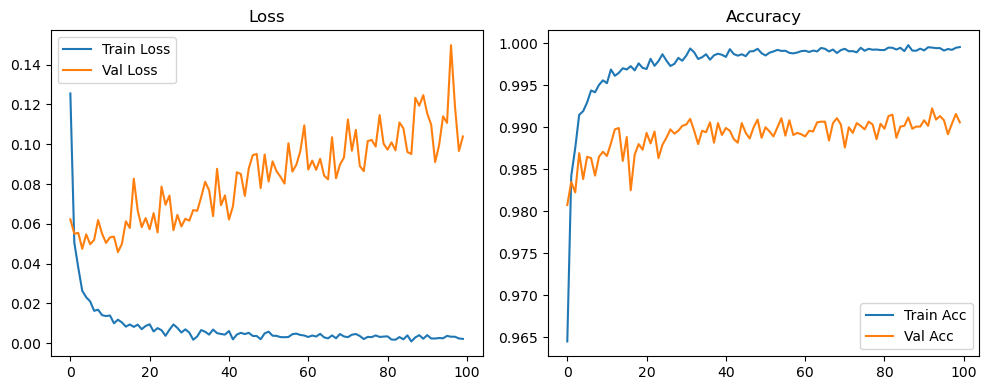

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1585, Acc: 0.9556 | Val Loss: 0.2781, Acc: 0.9143


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9783 | Val Loss: 0.0762, Acc: 0.9772


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9824 | Val Loss: 0.0780, Acc: 0.9762


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9856 | Val Loss: 0.0621, Acc: 0.9812


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9873 | Val Loss: 0.0693, Acc: 0.9783


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9873 | Val Loss: 0.0541, Acc: 0.9840


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.0687, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0538, Acc: 0.9842


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.0538, Acc: 0.9846


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0613, Acc: 0.9818


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0440, Acc: 0.9868


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.0626, Acc: 0.9825


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0671, Acc: 0.9818


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0466, Acc: 0.9874


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0534, Acc: 0.9859


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0637, Acc: 0.9820


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9934 | Val Loss: 0.0569, Acc: 0.9852


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0552, Acc: 0.9840


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0568, Acc: 0.9851


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0507, Acc: 0.9869


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0565, Acc: 0.9842


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0425, Acc: 0.9887


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0469, Acc: 0.9889


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0585, Acc: 0.9842


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0627, Acc: 0.9858


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0728, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0628, Acc: 0.9846


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0486, Acc: 0.9902


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0479, Acc: 0.9862


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0874, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.0580, Acc: 0.9852


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0689, Acc: 0.9852


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.0523, Acc: 0.9882


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0551, Acc: 0.9880


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0448, Acc: 0.9911


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0562, Acc: 0.9892


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0682, Acc: 0.9855


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0564, Acc: 0.9887


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0470, Acc: 0.9898


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.0615, Acc: 0.9873


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0519, Acc: 0.9881


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0580, Acc: 0.9884


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0501, Acc: 0.9883


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0552, Acc: 0.9881


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0734, Acc: 0.9835


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0504, Acc: 0.9898


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0547, Acc: 0.9865


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0505, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9967 | Val Loss: 0.0501, Acc: 0.9886


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0469, Acc: 0.9888


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9968 | Val Loss: 0.0590, Acc: 0.9873


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0524, Acc: 0.9890


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0506, Acc: 0.9879


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0565, Acc: 0.9878


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0540, Acc: 0.9878


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0522, Acc: 0.9876


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0573, Acc: 0.9878


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0599, Acc: 0.9895


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0490, Acc: 0.9889


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.0466, Acc: 0.9905


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0570, Acc: 0.9876


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.0533, Acc: 0.9880


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0517, Acc: 0.9903


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0535, Acc: 0.9895


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0498, Acc: 0.9901


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0553, Acc: 0.9882


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0567, Acc: 0.9889


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0556, Acc: 0.9912


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.0529, Acc: 0.9900


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0599, Acc: 0.9882


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9976 | Val Loss: 0.0638, Acc: 0.9883


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0572, Acc: 0.9898


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0557, Acc: 0.9888


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.0520, Acc: 0.9893


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0629, Acc: 0.9879


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0556, Acc: 0.9902


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.0542, Acc: 0.9893


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0508, Acc: 0.9912


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0561, Acc: 0.9880


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0586, Acc: 0.9880


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0581, Acc: 0.9890


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0628, Acc: 0.9884


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.0624, Acc: 0.9892


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0559, Acc: 0.9904


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0786, Acc: 0.9864


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.0657, Acc: 0.9879


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0501, Acc: 0.9917


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.0550, Acc: 0.9882


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.0614, Acc: 0.9892


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0559, Acc: 0.9897


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.0572, Acc: 0.9887


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9978 | Val Loss: 0.0533, Acc: 0.9899


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0535, Acc: 0.9902


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0574, Acc: 0.9881


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.0595, Acc: 0.9904


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.0556, Acc: 0.9896


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.0592, Acc: 0.9891


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0587, Acc: 0.9914


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0504, Acc: 0.9905


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0620, Acc: 0.9898


Final Test Loss: 0.0551 Accuracy: 0.9895


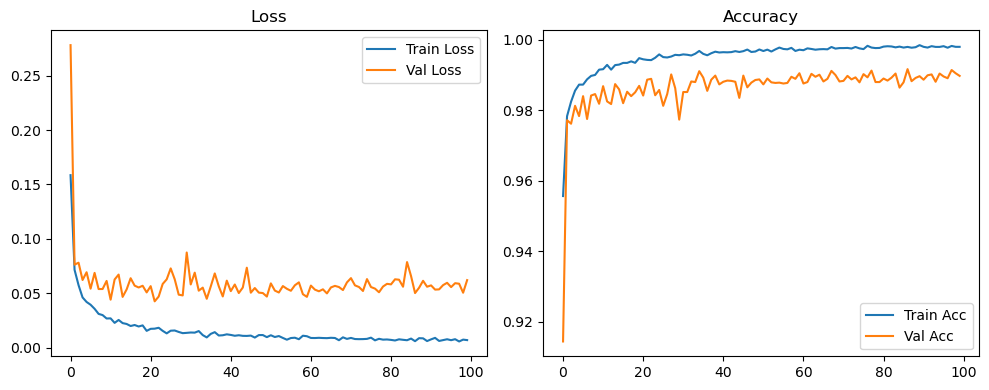

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2529, Acc: 0.9276 | Val Loss: 0.9045, Acc: 0.6858


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9591 | Val Loss: 0.4868, Acc: 0.8197


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9645 | Val Loss: 0.4657, Acc: 0.8243


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1040, Acc: 0.9694 | Val Loss: 0.3952, Acc: 0.8638


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9714 | Val Loss: 0.2053, Acc: 0.9348


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9725 | Val Loss: 0.3362, Acc: 0.8812


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9735 | Val Loss: 0.2113, Acc: 0.9294


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9753 | Val Loss: 0.3038, Acc: 0.8893


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0830, Acc: 0.9753 | Val Loss: 0.1876, Acc: 0.9326


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9764 | Val Loss: 0.1585, Acc: 0.9494


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9776 | Val Loss: 0.1841, Acc: 0.9350


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9772 | Val Loss: 0.1606, Acc: 0.9484


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9783 | Val Loss: 0.2609, Acc: 0.9098


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9784 | Val Loss: 0.1467, Acc: 0.9520


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9795 | Val Loss: 0.3021, Acc: 0.8991


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9793 | Val Loss: 0.1176, Acc: 0.9627


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9796 | Val Loss: 0.1165, Acc: 0.9661


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9806 | Val Loss: 0.1528, Acc: 0.9487


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9808 | Val Loss: 0.2067, Acc: 0.9275


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9821 | Val Loss: 0.1846, Acc: 0.9327


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9811 | Val Loss: 0.2007, Acc: 0.9279


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9822 | Val Loss: 0.1201, Acc: 0.9603


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9816 | Val Loss: 0.1047, Acc: 0.9680


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9831 | Val Loss: 0.1385, Acc: 0.9564


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9821 | Val Loss: 0.1539, Acc: 0.9477


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9829 | Val Loss: 0.1415, Acc: 0.9522


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9822 | Val Loss: 0.1174, Acc: 0.9593


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9829 | Val Loss: 0.1510, Acc: 0.9506


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9835 | Val Loss: 0.1636, Acc: 0.9457


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9835 | Val Loss: 0.0906, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9842 | Val Loss: 0.1402, Acc: 0.9538


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9843 | Val Loss: 0.1161, Acc: 0.9612


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9845 | Val Loss: 0.1233, Acc: 0.9594


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9842 | Val Loss: 0.1011, Acc: 0.9679


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9850 | Val Loss: 0.1070, Acc: 0.9648


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9832 | Val Loss: 0.1387, Acc: 0.9545


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9846 | Val Loss: 0.1128, Acc: 0.9630


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9848 | Val Loss: 0.1099, Acc: 0.9668


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9855 | Val Loss: 0.0930, Acc: 0.9729


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9850 | Val Loss: 0.1293, Acc: 0.9591


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9848 | Val Loss: 0.1180, Acc: 0.9633


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9860 | Val Loss: 0.0854, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9860 | Val Loss: 0.1447, Acc: 0.9496


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9852 | Val Loss: 0.1203, Acc: 0.9600


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9863 | Val Loss: 0.0876, Acc: 0.9738


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.1422, Acc: 0.9513


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9860 | Val Loss: 0.1242, Acc: 0.9588


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9864 | Val Loss: 0.0967, Acc: 0.9723


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.0954, Acc: 0.9681


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9866 | Val Loss: 0.1164, Acc: 0.9601


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9857 | Val Loss: 0.1020, Acc: 0.9679


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9869 | Val Loss: 0.1029, Acc: 0.9673


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.1218, Acc: 0.9625


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9868 | Val Loss: 0.1168, Acc: 0.9656


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.1193, Acc: 0.9620


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9873 | Val Loss: 0.0874, Acc: 0.9728


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9866 | Val Loss: 0.1489, Acc: 0.9507


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9865 | Val Loss: 0.0931, Acc: 0.9707


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 0.1594, Acc: 0.9454


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9866 | Val Loss: 0.0918, Acc: 0.9711


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9870 | Val Loss: 0.1256, Acc: 0.9598


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9865 | Val Loss: 0.1148, Acc: 0.9675


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1293, Acc: 0.9591


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9869 | Val Loss: 0.1006, Acc: 0.9680


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.0985, Acc: 0.9704


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 0.1048, Acc: 0.9698


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.1297, Acc: 0.9631


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9869 | Val Loss: 0.1423, Acc: 0.9531


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9872 | Val Loss: 0.1107, Acc: 0.9667


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9874 | Val Loss: 0.1024, Acc: 0.9674


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9886 | Val Loss: 0.0949, Acc: 0.9691


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.0961, Acc: 0.9699


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9878 | Val Loss: 0.1409, Acc: 0.9515


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9879 | Val Loss: 0.0859, Acc: 0.9765


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9881 | Val Loss: 0.0886, Acc: 0.9737


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9881 | Val Loss: 0.1046, Acc: 0.9676


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.1224, Acc: 0.9632


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9883 | Val Loss: 0.0859, Acc: 0.9734


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 0.1030, Acc: 0.9670


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0879, Acc: 0.9743


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.0809, Acc: 0.9765


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0970, Acc: 0.9703


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9881 | Val Loss: 0.0875, Acc: 0.9755


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9881 | Val Loss: 0.0946, Acc: 0.9698


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9889 | Val Loss: 0.1004, Acc: 0.9722


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9887 | Val Loss: 0.1062, Acc: 0.9667


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9888 | Val Loss: 0.0869, Acc: 0.9732


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.1042, Acc: 0.9701


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9895 | Val Loss: 0.0721, Acc: 0.9778


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9885 | Val Loss: 0.0880, Acc: 0.9761


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.1038, Acc: 0.9668


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.0991, Acc: 0.9679


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.0828, Acc: 0.9750


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9889 | Val Loss: 0.1125, Acc: 0.9633


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9888 | Val Loss: 0.1076, Acc: 0.9648


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.0949, Acc: 0.9705


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.1298, Acc: 0.9564


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9880 | Val Loss: 0.0954, Acc: 0.9708


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.0840, Acc: 0.9748


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9895 | Val Loss: 0.0798, Acc: 0.9753


Final Test Loss: 0.0752 Accuracy: 0.9779


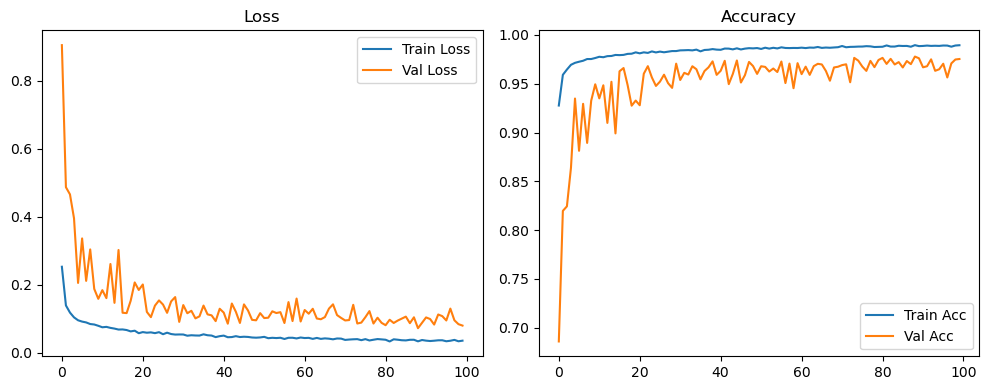

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9645 | Val Loss: 0.0623, Acc: 0.9808


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9845 | Val Loss: 0.0525, Acc: 0.9837


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0619, Acc: 0.9812


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.0448, Acc: 0.9862


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0689, Acc: 0.9815


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0451, Acc: 0.9879


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.0483, Acc: 0.9853


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0473, Acc: 0.9878


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0634, Acc: 0.9836


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0630, Acc: 0.9852


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0623, Acc: 0.9858


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0591, Acc: 0.9865


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0551, Acc: 0.9878


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0492, Acc: 0.9886


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.0530, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0687, Acc: 0.9876


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0652, Acc: 0.9862


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0701, Acc: 0.9861


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0628, Acc: 0.9878


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0531, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0519, Acc: 0.9914


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0702, Acc: 0.9874


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0624, Acc: 0.9886


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0652, Acc: 0.9891


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0951, Acc: 0.9843


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0652, Acc: 0.9896


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0673, Acc: 0.9900


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0876, Acc: 0.9868


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0619, Acc: 0.9884


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0922, Acc: 0.9862


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0558, Acc: 0.9909


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0577, Acc: 0.9919


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.0792, Acc: 0.9887


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0703, Acc: 0.9902


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0731, Acc: 0.9903


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0660, Acc: 0.9903


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0686, Acc: 0.9901


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0646, Acc: 0.9910


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0679, Acc: 0.9901


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0674, Acc: 0.9897


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0780, Acc: 0.9884


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0773, Acc: 0.9886


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0946, Acc: 0.9881


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0723, Acc: 0.9902


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0759, Acc: 0.9886


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0780, Acc: 0.9902


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0793, Acc: 0.9897


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0796, Acc: 0.9888


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0903, Acc: 0.9877


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0813, Acc: 0.9895


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0709, Acc: 0.9908


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0677, Acc: 0.9904


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0697, Acc: 0.9912


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0783, Acc: 0.9913


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0659, Acc: 0.9913


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0657, Acc: 0.9914


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0760, Acc: 0.9915


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0731, Acc: 0.9914


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0727, Acc: 0.9912


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0624, Acc: 0.9928


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0743, Acc: 0.9921


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0776, Acc: 0.9908


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0755, Acc: 0.9915


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0795, Acc: 0.9918


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0793, Acc: 0.9908


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0838, Acc: 0.9906


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0875, Acc: 0.9908


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0825, Acc: 0.9912


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0772, Acc: 0.9916


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0860, Acc: 0.9899


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0859, Acc: 0.9897


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0847, Acc: 0.9906


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0942, Acc: 0.9911


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0853, Acc: 0.9893


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0938, Acc: 0.9904


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0796, Acc: 0.9910


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0895, Acc: 0.9906


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0715, Acc: 0.9915


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0903, Acc: 0.9914


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0878, Acc: 0.9909


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0881, Acc: 0.9923


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0804, Acc: 0.9918


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0838, Acc: 0.9921


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0824, Acc: 0.9922


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0809, Acc: 0.9918


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0824, Acc: 0.9918


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0792, Acc: 0.9921


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0803, Acc: 0.9920


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0849, Acc: 0.9912


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0814, Acc: 0.9922


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0843, Acc: 0.9918


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0777, Acc: 0.9927


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0820, Acc: 0.9923


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0822, Acc: 0.9918


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0749, Acc: 0.9923


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0818, Acc: 0.9918


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0838, Acc: 0.9923


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0835, Acc: 0.9917


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0821, Acc: 0.9915


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0776, Acc: 0.9916


Final Test Loss: 0.0827 Accuracy: 0.9921


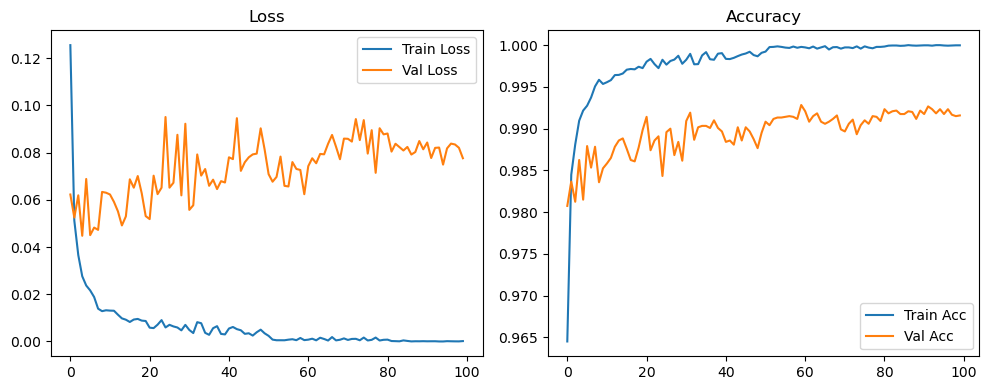

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1585, Acc: 0.9556 | Val Loss: 0.2781, Acc: 0.9143


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9781 | Val Loss: 0.0629, Acc: 0.9819


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9817 | Val Loss: 0.0622, Acc: 0.9828


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9850 | Val Loss: 0.0696, Acc: 0.9792


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 0.0641, Acc: 0.9801


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9877 | Val Loss: 0.0699, Acc: 0.9773


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9879 | Val Loss: 0.0664, Acc: 0.9809


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9901 | Val Loss: 0.0529, Acc: 0.9846


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0468, Acc: 0.9856


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0429, Acc: 0.9874


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0521, Acc: 0.9848


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0480, Acc: 0.9855


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0685, Acc: 0.9788


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0447, Acc: 0.9873


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0646, Acc: 0.9820


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0589, Acc: 0.9832


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0499, Acc: 0.9867


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.0486, Acc: 0.9878


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0469, Acc: 0.9872


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0509, Acc: 0.9868


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0525, Acc: 0.9852


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0505, Acc: 0.9873


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9947 | Val Loss: 0.0545, Acc: 0.9857


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0466, Acc: 0.9882


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0622, Acc: 0.9844


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0540, Acc: 0.9862


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0545, Acc: 0.9866


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0545, Acc: 0.9869


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0506, Acc: 0.9869


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.0539, Acc: 0.9868


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0478, Acc: 0.9895


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0668, Acc: 0.9840


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0625, Acc: 0.9852


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0507, Acc: 0.9887


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.0484, Acc: 0.9880


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0573, Acc: 0.9874


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0471, Acc: 0.9889


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.0558, Acc: 0.9874


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0521, Acc: 0.9882


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0537, Acc: 0.9884


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.0561, Acc: 0.9880


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0564, Acc: 0.9876


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0570, Acc: 0.9881


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0554, Acc: 0.9889


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0543, Acc: 0.9885


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0516, Acc: 0.9893


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0653, Acc: 0.9861


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0582, Acc: 0.9894


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0635, Acc: 0.9874


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0584, Acc: 0.9893


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0536, Acc: 0.9902


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0519, Acc: 0.9890


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0528, Acc: 0.9902


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0503, Acc: 0.9896


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0555, Acc: 0.9898


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0486, Acc: 0.9908


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0499, Acc: 0.9902


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0635, Acc: 0.9885


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0549, Acc: 0.9893


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0557, Acc: 0.9909


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0569, Acc: 0.9900


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0537, Acc: 0.9903


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0541, Acc: 0.9907


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0540, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0507, Acc: 0.9902


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0504, Acc: 0.9904


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0502, Acc: 0.9919


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0575, Acc: 0.9901


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0477, Acc: 0.9914


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0552, Acc: 0.9899


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0575, Acc: 0.9902


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0474, Acc: 0.9914


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0483, Acc: 0.9928


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0575, Acc: 0.9909


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0534, Acc: 0.9908


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0550, Acc: 0.9903


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0678, Acc: 0.9881


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0523, Acc: 0.9900


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0519, Acc: 0.9914


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0532, Acc: 0.9908


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0508, Acc: 0.9906


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0468, Acc: 0.9918


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0497, Acc: 0.9915


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0484, Acc: 0.9926


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0479, Acc: 0.9923


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0552, Acc: 0.9912


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0475, Acc: 0.9913


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0510, Acc: 0.9908


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0514, Acc: 0.9909


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0537, Acc: 0.9912


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0498, Acc: 0.9912


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0492, Acc: 0.9911


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0491, Acc: 0.9912


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0519, Acc: 0.9921


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0532, Acc: 0.9911


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0510, Acc: 0.9916


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0481, Acc: 0.9931


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0530, Acc: 0.9918


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0482, Acc: 0.9918


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0513, Acc: 0.9920


Final Test Loss: 0.0428 Accuracy: 0.9912


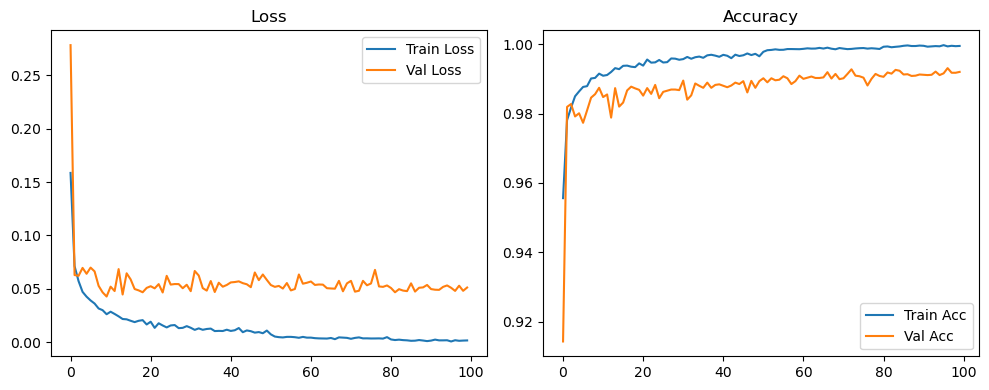

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2529, Acc: 0.9276 | Val Loss: 0.9045, Acc: 0.6858


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1386, Acc: 0.9589 | Val Loss: 0.4946, Acc: 0.8159


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1158, Acc: 0.9654 | Val Loss: 0.4292, Acc: 0.8327


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9690 | Val Loss: 0.3508, Acc: 0.8750


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9724 | Val Loss: 0.3223, Acc: 0.8884


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9724 | Val Loss: 0.2107, Acc: 0.9294


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9724 | Val Loss: 0.2565, Acc: 0.9133


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9744 | Val Loss: 0.3239, Acc: 0.8840


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9768 | Val Loss: 0.1631, Acc: 0.9447


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9762 | Val Loss: 0.3810, Acc: 0.8597


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9776 | Val Loss: 0.2320, Acc: 0.9146


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9772 | Val Loss: 0.2133, Acc: 0.9272


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9786 | Val Loss: 0.1695, Acc: 0.9429


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9796 | Val Loss: 0.1889, Acc: 0.9390


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9788 | Val Loss: 0.2592, Acc: 0.9094


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9794 | Val Loss: 0.1077, Acc: 0.9669


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9789 | Val Loss: 0.1969, Acc: 0.9331


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9804 | Val Loss: 0.1153, Acc: 0.9627


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9800 | Val Loss: 0.1863, Acc: 0.9378


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9813 | Val Loss: 0.1727, Acc: 0.9404


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9810 | Val Loss: 0.1779, Acc: 0.9363


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9821 | Val Loss: 0.0989, Acc: 0.9684


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9821 | Val Loss: 0.0948, Acc: 0.9702


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9819 | Val Loss: 0.1059, Acc: 0.9674


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9826 | Val Loss: 0.1497, Acc: 0.9511


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 0.1677, Acc: 0.9419


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9834 | Val Loss: 0.1132, Acc: 0.9641


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9831 | Val Loss: 0.1731, Acc: 0.9437


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9836 | Val Loss: 0.1409, Acc: 0.9525


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9829 | Val Loss: 0.1374, Acc: 0.9536


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9842 | Val Loss: 0.1327, Acc: 0.9553


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9850 | Val Loss: 0.1097, Acc: 0.9645


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9844 | Val Loss: 0.1160, Acc: 0.9648


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9840 | Val Loss: 0.1341, Acc: 0.9580


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9847 | Val Loss: 0.1309, Acc: 0.9570


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9846 | Val Loss: 0.1372, Acc: 0.9542


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9844 | Val Loss: 0.0864, Acc: 0.9748


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9839 | Val Loss: 0.1113, Acc: 0.9663


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9860 | Val Loss: 0.0729, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9849 | Val Loss: 0.1240, Acc: 0.9603


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9853 | Val Loss: 0.0956, Acc: 0.9705


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9855 | Val Loss: 0.0765, Acc: 0.9778


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9856 | Val Loss: 0.1014, Acc: 0.9669


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9853 | Val Loss: 0.0955, Acc: 0.9698


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9858 | Val Loss: 0.1116, Acc: 0.9653


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9858 | Val Loss: 0.1033, Acc: 0.9676


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9855 | Val Loss: 0.1081, Acc: 0.9648


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9867 | Val Loss: 0.0949, Acc: 0.9700


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9853 | Val Loss: 0.1273, Acc: 0.9579


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9857 | Val Loss: 0.1337, Acc: 0.9531


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9871 | Val Loss: 0.0927, Acc: 0.9715


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.1066, Acc: 0.9675


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0970, Acc: 0.9712


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.0790, Acc: 0.9778


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0930, Acc: 0.9716


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0953, Acc: 0.9699


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.1187, Acc: 0.9607


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9894 | Val Loss: 0.1017, Acc: 0.9681


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.1086, Acc: 0.9663


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9895 | Val Loss: 0.0893, Acc: 0.9716


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.1354, Acc: 0.9543


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9903 | Val Loss: 0.0819, Acc: 0.9740


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1080, Acc: 0.9657


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9896 | Val Loss: 0.0919, Acc: 0.9718


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0744, Acc: 0.9783


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.0895, Acc: 0.9735


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9901 | Val Loss: 0.0944, Acc: 0.9712


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.1191, Acc: 0.9597


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.1151, Acc: 0.9615


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9903 | Val Loss: 0.0699, Acc: 0.9806


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.0870, Acc: 0.9736


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0909, Acc: 0.9702


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.0941, Acc: 0.9698


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.0770, Acc: 0.9758


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.0622, Acc: 0.9832


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0836, Acc: 0.9752


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0995, Acc: 0.9691


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.0730, Acc: 0.9795


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.0907, Acc: 0.9726


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9904 | Val Loss: 0.0832, Acc: 0.9768


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0814, Acc: 0.9786


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0921, Acc: 0.9722


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0862, Acc: 0.9759


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0830, Acc: 0.9747


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0909, Acc: 0.9712


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0950, Acc: 0.9700


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.0926, Acc: 0.9714


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0827, Acc: 0.9747


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0825, Acc: 0.9757


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0787, Acc: 0.9762


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0759, Acc: 0.9783


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0870, Acc: 0.9729


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.0935, Acc: 0.9702


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.0807, Acc: 0.9762


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.0787, Acc: 0.9758


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.0817, Acc: 0.9745


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0708, Acc: 0.9784


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.0745, Acc: 0.9789


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0672, Acc: 0.9823


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.0730, Acc: 0.9800


Final Test Loss: 0.0685 Accuracy: 0.9790


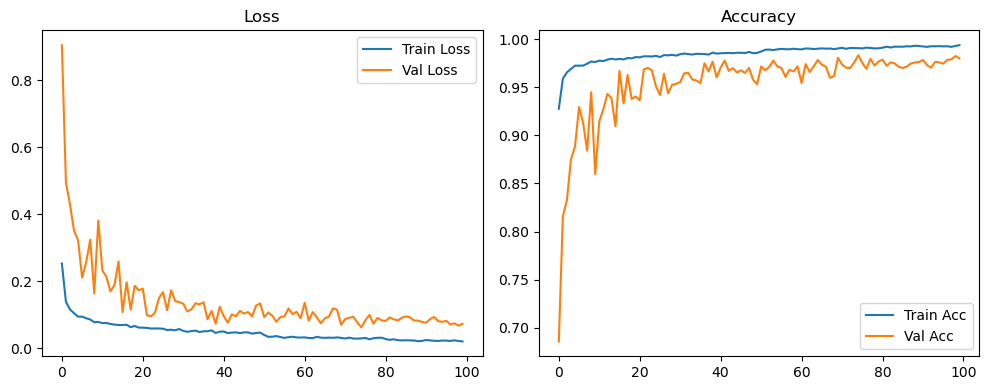

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9645 | Val Loss: 0.0623, Acc: 0.9808


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9839 | Val Loss: 0.0494, Acc: 0.9837


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9882 | Val Loss: 0.0599, Acc: 0.9815


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.0508, Acc: 0.9849


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9915 | Val Loss: 0.0511, Acc: 0.9859


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0471, Acc: 0.9863


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9935 | Val Loss: 0.0607, Acc: 0.9852


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0607, Acc: 0.9850


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0399, Acc: 0.9891


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0574, Acc: 0.9873


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0483, Acc: 0.9882


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0552, Acc: 0.9864


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0539, Acc: 0.9891


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0747, Acc: 0.9838


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0586, Acc: 0.9875


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0640, Acc: 0.9882


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0596, Acc: 0.9882


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0644, Acc: 0.9872


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0650, Acc: 0.9852


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0594, Acc: 0.9869


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0666, Acc: 0.9874


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0572, Acc: 0.9888


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0623, Acc: 0.9896


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0642, Acc: 0.9894


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0687, Acc: 0.9880


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9977 | Val Loss: 0.0660, Acc: 0.9886


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0669, Acc: 0.9873


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0870, Acc: 0.9865


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0702, Acc: 0.9880


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0798, Acc: 0.9867


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0683, Acc: 0.9898


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0654, Acc: 0.9901


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0793, Acc: 0.9868


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0953, Acc: 0.9857


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0824, Acc: 0.9872


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0755, Acc: 0.9889


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0842, Acc: 0.9876


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0834, Acc: 0.9895


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0707, Acc: 0.9905


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0855, Acc: 0.9871


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0788, Acc: 0.9903


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0680, Acc: 0.9904


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0710, Acc: 0.9904


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0801, Acc: 0.9900


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0809, Acc: 0.9882


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0765, Acc: 0.9898


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.0711, Acc: 0.9908


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0898, Acc: 0.9889


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0804, Acc: 0.9907


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0716, Acc: 0.9908


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0620, Acc: 0.9922


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0638, Acc: 0.9913


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0614, Acc: 0.9922


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9918


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0625, Acc: 0.9919


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0642, Acc: 0.9917


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0675, Acc: 0.9912


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0820, Acc: 0.9913


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0878, Acc: 0.9898


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0796, Acc: 0.9909


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0768, Acc: 0.9906


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0780, Acc: 0.9905


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0783, Acc: 0.9902


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0755, Acc: 0.9908


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0717, Acc: 0.9906


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0761, Acc: 0.9919


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0799, Acc: 0.9904


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0757, Acc: 0.9913


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0742, Acc: 0.9913


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0687, Acc: 0.9924


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0722, Acc: 0.9919


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0810, Acc: 0.9908


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0830, Acc: 0.9911


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0754, Acc: 0.9933


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0823, Acc: 0.9922


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0824, Acc: 0.9910


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0833, Acc: 0.9916


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0780, Acc: 0.9925


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0841, Acc: 0.9919


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0986, Acc: 0.9903


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0873, Acc: 0.9909


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0832, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0837, Acc: 0.9924


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0805, Acc: 0.9924


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0823, Acc: 0.9923


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0815, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0804, Acc: 0.9925


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0796, Acc: 0.9921


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0820, Acc: 0.9922


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0804, Acc: 0.9927


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0829, Acc: 0.9924


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0799, Acc: 0.9924


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0787, Acc: 0.9921


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0768, Acc: 0.9929


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0816, Acc: 0.9928


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0788, Acc: 0.9928


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0807, Acc: 0.9924


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0792, Acc: 0.9922


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0771, Acc: 0.9931


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0771, Acc: 0.9922


Final Test Loss: 0.0649 Accuracy: 0.9916


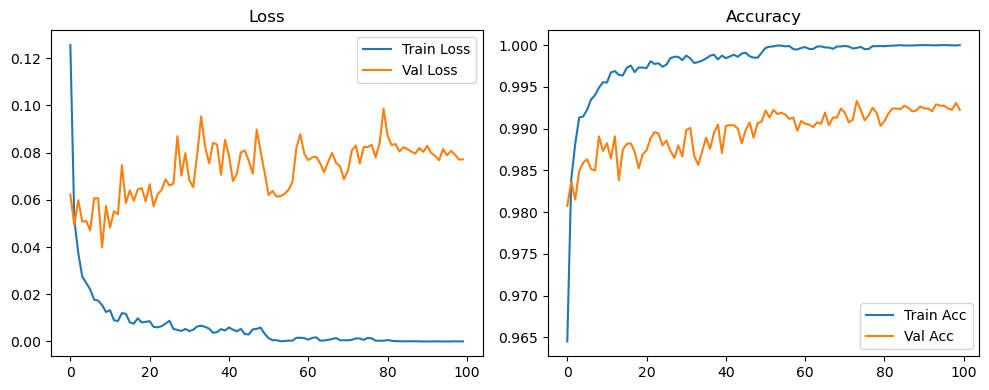

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1585, Acc: 0.9556 | Val Loss: 0.2781, Acc: 0.9143


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9784 | Val Loss: 0.1002, Acc: 0.9700


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9823 | Val Loss: 0.0748, Acc: 0.9777


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9855 | Val Loss: 0.0713, Acc: 0.9792


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9870 | Val Loss: 0.0644, Acc: 0.9809


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 0.0877, Acc: 0.9747


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.0716, Acc: 0.9789


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.0442, Acc: 0.9858


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9909 | Val Loss: 0.0441, Acc: 0.9873


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.0469, Acc: 0.9868


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0510, Acc: 0.9852


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0474, Acc: 0.9853


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0505, Acc: 0.9854


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0517, Acc: 0.9863


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.0457, Acc: 0.9876


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0547, Acc: 0.9865


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9936 | Val Loss: 0.0565, Acc: 0.9857


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0432, Acc: 0.9883


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.0602, Acc: 0.9834


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0489, Acc: 0.9874


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.0554, Acc: 0.9849


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0484, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0497, Acc: 0.9878


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0586, Acc: 0.9864


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0512, Acc: 0.9876


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9946 | Val Loss: 0.0602, Acc: 0.9865


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0577, Acc: 0.9858


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0531, Acc: 0.9888


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9957 | Val Loss: 0.0589, Acc: 0.9853


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0526, Acc: 0.9868


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0548, Acc: 0.9891


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0576, Acc: 0.9878


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9959 | Val Loss: 0.0573, Acc: 0.9878


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0577, Acc: 0.9870


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0517, Acc: 0.9886


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0597, Acc: 0.9870


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0460, Acc: 0.9890


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.0570, Acc: 0.9872


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0531, Acc: 0.9882


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0529, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0482, Acc: 0.9892


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0526, Acc: 0.9868


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0504, Acc: 0.9885


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0505, Acc: 0.9894


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0576, Acc: 0.9875


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0598, Acc: 0.9886


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0547, Acc: 0.9879


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.0558, Acc: 0.9899


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0510, Acc: 0.9893


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0470, Acc: 0.9891


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0479, Acc: 0.9892


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0497, Acc: 0.9902


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0511, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0506, Acc: 0.9896


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0556, Acc: 0.9901


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0514, Acc: 0.9915


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0513, Acc: 0.9918


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0524, Acc: 0.9898


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0454, Acc: 0.9919


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0570, Acc: 0.9903


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0548, Acc: 0.9898


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0622, Acc: 0.9892


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0515, Acc: 0.9911


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0527, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0523, Acc: 0.9902


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0527, Acc: 0.9904


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0446, Acc: 0.9922


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0508, Acc: 0.9910


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0523, Acc: 0.9898


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0522, Acc: 0.9908


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0527, Acc: 0.9908


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0495, Acc: 0.9910


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0456, Acc: 0.9922


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0609, Acc: 0.9885


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0526, Acc: 0.9915


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0580, Acc: 0.9905


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0636, Acc: 0.9890


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0522, Acc: 0.9911


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0576, Acc: 0.9904


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0592, Acc: 0.9903


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0614, Acc: 0.9895


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0547, Acc: 0.9907


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0579, Acc: 0.9907


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0570, Acc: 0.9907


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0510, Acc: 0.9922


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0531, Acc: 0.9920


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0561, Acc: 0.9917


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0523, Acc: 0.9919


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0533, Acc: 0.9923


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0512, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0549, Acc: 0.9923


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0496, Acc: 0.9927


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0511, Acc: 0.9920


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0497, Acc: 0.9924


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0527, Acc: 0.9924


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0531, Acc: 0.9921


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0489, Acc: 0.9926


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0512, Acc: 0.9915


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0487, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0482, Acc: 0.9923


Final Test Loss: 0.0451 Accuracy: 0.9907


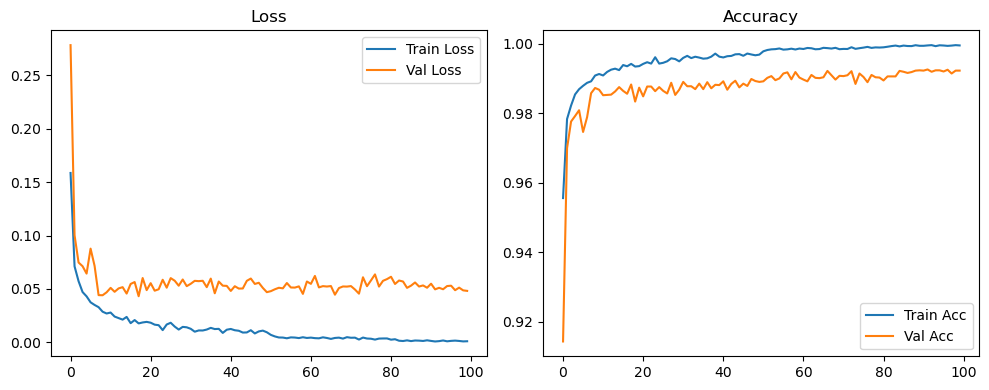

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2529, Acc: 0.9276 | Val Loss: 0.9045, Acc: 0.6858


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1386, Acc: 0.9590 | Val Loss: 0.6138, Acc: 0.7682


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9653 | Val Loss: 0.5033, Acc: 0.8125


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1074, Acc: 0.9681 | Val Loss: 0.3324, Acc: 0.8851


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9720 | Val Loss: 0.3680, Acc: 0.8734


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9725 | Val Loss: 0.4345, Acc: 0.8485


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9730 | Val Loss: 0.2878, Acc: 0.8987


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9736 | Val Loss: 0.2480, Acc: 0.9127


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9760 | Val Loss: 0.1703, Acc: 0.9422


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9764 | Val Loss: 0.2103, Acc: 0.9304


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9765 | Val Loss: 0.1903, Acc: 0.9333


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9764 | Val Loss: 0.1878, Acc: 0.9399


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9781 | Val Loss: 0.1530, Acc: 0.9472


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9785 | Val Loss: 0.1793, Acc: 0.9395


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9788 | Val Loss: 0.1366, Acc: 0.9533


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9796 | Val Loss: 0.1402, Acc: 0.9546


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9794 | Val Loss: 0.1898, Acc: 0.9335


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9804 | Val Loss: 0.1240, Acc: 0.9592


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9803 | Val Loss: 0.1026, Acc: 0.9656


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9819 | Val Loss: 0.2738, Acc: 0.8979


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9818 | Val Loss: 0.1233, Acc: 0.9595


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9819 | Val Loss: 0.1038, Acc: 0.9662


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9819 | Val Loss: 0.1029, Acc: 0.9676


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9830 | Val Loss: 0.1230, Acc: 0.9580


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9821 | Val Loss: 0.1166, Acc: 0.9639


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9817 | Val Loss: 0.0869, Acc: 0.9749


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9833 | Val Loss: 0.1105, Acc: 0.9640


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9834 | Val Loss: 0.1294, Acc: 0.9583


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9835 | Val Loss: 0.1591, Acc: 0.9467


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9832 | Val Loss: 0.0937, Acc: 0.9696


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9841 | Val Loss: 0.1396, Acc: 0.9520


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9850 | Val Loss: 0.1631, Acc: 0.9453


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9837 | Val Loss: 0.1413, Acc: 0.9523


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 0.1195, Acc: 0.9603


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9841 | Val Loss: 0.1205, Acc: 0.9597


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.1568, Acc: 0.9468


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9849 | Val Loss: 0.1080, Acc: 0.9658


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9842 | Val Loss: 0.1060, Acc: 0.9647


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9851 | Val Loss: 0.1070, Acc: 0.9663


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9846 | Val Loss: 0.1064, Acc: 0.9657


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9846 | Val Loss: 0.1813, Acc: 0.9375


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9850 | Val Loss: 0.1027, Acc: 0.9721


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.1408, Acc: 0.9508


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9864 | Val Loss: 0.0963, Acc: 0.9691


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9862 | Val Loss: 0.1068, Acc: 0.9643


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9858 | Val Loss: 0.1126, Acc: 0.9618


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9858 | Val Loss: 0.1385, Acc: 0.9544


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9866 | Val Loss: 0.0853, Acc: 0.9744


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9857 | Val Loss: 0.1485, Acc: 0.9484


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9866 | Val Loss: 0.0909, Acc: 0.9718


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.1114, Acc: 0.9638


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.1149, Acc: 0.9612


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9897 | Val Loss: 0.1001, Acc: 0.9683


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9890 | Val Loss: 0.0874, Acc: 0.9732


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0957, Acc: 0.9697


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.0897, Acc: 0.9712


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9900 | Val Loss: 0.1475, Acc: 0.9473


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.1127, Acc: 0.9624


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 0.0979, Acc: 0.9662


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.1036, Acc: 0.9664


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0964, Acc: 0.9698


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9900 | Val Loss: 0.1055, Acc: 0.9653


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.0930, Acc: 0.9723


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9909 | Val Loss: 0.1022, Acc: 0.9657


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.1016, Acc: 0.9672


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.1114, Acc: 0.9644


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0863, Acc: 0.9718


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.1358, Acc: 0.9525


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.1131, Acc: 0.9616


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0956, Acc: 0.9706


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.0901, Acc: 0.9708


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.1199, Acc: 0.9587


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.1014, Acc: 0.9680


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.0856, Acc: 0.9727


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0700, Acc: 0.9802


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.0776, Acc: 0.9780


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0912, Acc: 0.9722


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.0825, Acc: 0.9732


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.0966, Acc: 0.9680


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0835, Acc: 0.9760


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9906 | Val Loss: 0.0868, Acc: 0.9736


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0905, Acc: 0.9708


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0862, Acc: 0.9728


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0862, Acc: 0.9724


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.0874, Acc: 0.9712


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0864, Acc: 0.9728


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.0844, Acc: 0.9725


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0750, Acc: 0.9769


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0727, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0732, Acc: 0.9781


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.0823, Acc: 0.9752


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9931 | Val Loss: 0.0831, Acc: 0.9752


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0834, Acc: 0.9754


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0885, Acc: 0.9732


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0768, Acc: 0.9769


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0906, Acc: 0.9713


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.0728, Acc: 0.9774


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0804, Acc: 0.9763


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0709, Acc: 0.9775


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0778, Acc: 0.9755


Final Test Loss: 0.0765 Accuracy: 0.9763


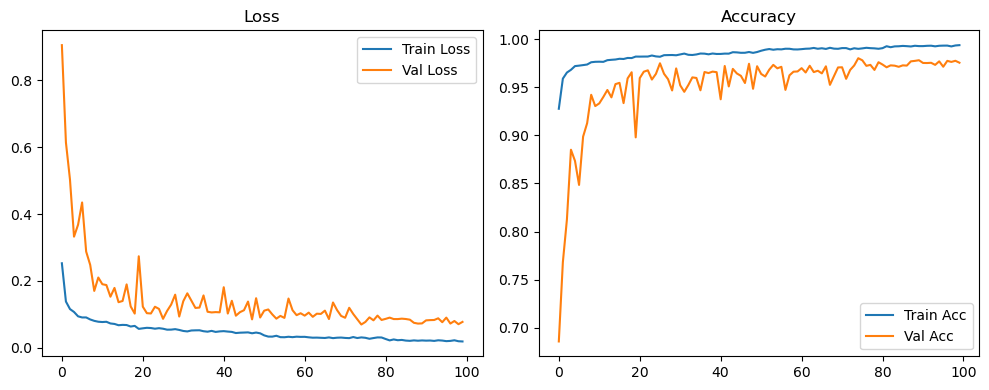

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1255, Acc: 0.9645 | Val Loss: 0.0623, Acc: 0.9808


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9845 | Val Loss: 0.0579, Acc: 0.9814


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.0782, Acc: 0.9767


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9897 | Val Loss: 0.0455, Acc: 0.9867


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0521, Acc: 0.9842


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0499, Acc: 0.9841


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0451, Acc: 0.9878


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0457, Acc: 0.9867


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0520, Acc: 0.9878


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.0701, Acc: 0.9837


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0577, Acc: 0.9880


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9962 | Val Loss: 0.0489, Acc: 0.9880


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0709, Acc: 0.9855


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0569, Acc: 0.9875


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0518, Acc: 0.9879


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0599, Acc: 0.9872


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0685, Acc: 0.9868


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.0663, Acc: 0.9857


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0640, Acc: 0.9875


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0494, Acc: 0.9899


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0776, Acc: 0.9858


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0586, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0585, Acc: 0.9894


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0958, Acc: 0.9825


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0609, Acc: 0.9893


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0671, Acc: 0.9881


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0773, Acc: 0.9876


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0658, Acc: 0.9896


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0771, Acc: 0.9892


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0678, Acc: 0.9887


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0692, Acc: 0.9891


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0676, Acc: 0.9899


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0710, Acc: 0.9892


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0654, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0664, Acc: 0.9895


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0795, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0899, Acc: 0.9881


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0727, Acc: 0.9895


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0728, Acc: 0.9900


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0711, Acc: 0.9900


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0788, Acc: 0.9889


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0809, Acc: 0.9896


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0688, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0743, Acc: 0.9892


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0803, Acc: 0.9892


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0863, Acc: 0.9880


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0984, Acc: 0.9888


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0802, Acc: 0.9896


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0834, Acc: 0.9894


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.0833, Acc: 0.9903


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0668, Acc: 0.9915


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0684, Acc: 0.9921


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0681, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0658, Acc: 0.9921


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0713, Acc: 0.9914


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0697, Acc: 0.9917


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0689, Acc: 0.9917


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0728, Acc: 0.9911


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0692, Acc: 0.9908


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0723, Acc: 0.9912


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9922


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9918


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0613, Acc: 0.9924


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9913


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0667, Acc: 0.9917


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0662, Acc: 0.9916


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0603, Acc: 0.9930


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9923


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0680, Acc: 0.9923


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0624, Acc: 0.9926


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9923


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0735, Acc: 0.9916


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0762, Acc: 0.9911


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0766, Acc: 0.9911


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0711, Acc: 0.9917


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0800, Acc: 0.9909


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0776, Acc: 0.9914


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0693, Acc: 0.9926


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0785, Acc: 0.9912


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0736, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0728, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0773, Acc: 0.9908


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0787, Acc: 0.9914


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0762, Acc: 0.9913


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0710, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0719, Acc: 0.9915


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0715, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0804, Acc: 0.9915


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0763, Acc: 0.9916


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0769, Acc: 0.9920


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0754, Acc: 0.9925


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0695, Acc: 0.9921


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0732, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0784, Acc: 0.9926


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0799, Acc: 0.9920


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0756, Acc: 0.9923


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0737, Acc: 0.9923


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0722, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0716, Acc: 0.9925


Final Test Loss: 0.0761 Accuracy: 0.9907


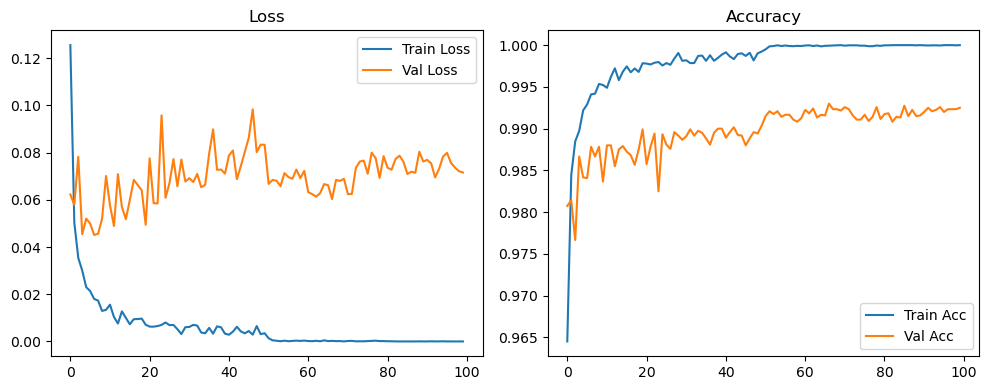

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1585, Acc: 0.9556 | Val Loss: 0.2781, Acc: 0.9143


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9784 | Val Loss: 0.0819, Acc: 0.9757


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9828 | Val Loss: 0.0835, Acc: 0.9758


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9855 | Val Loss: 0.0638, Acc: 0.9823


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9870 | Val Loss: 0.0536, Acc: 0.9835


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.0554, Acc: 0.9825


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0802, Acc: 0.9746


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0536, Acc: 0.9832


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.0514, Acc: 0.9836


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9910 | Val Loss: 0.0452, Acc: 0.9873


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.0455, Acc: 0.9866


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.0387, Acc: 0.9891


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.0514, Acc: 0.9861


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0486, Acc: 0.9874


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0532, Acc: 0.9869


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9930 | Val Loss: 0.0463, Acc: 0.9879


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9934 | Val Loss: 0.0598, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0411, Acc: 0.9887


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0508, Acc: 0.9867


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0469, Acc: 0.9867


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0511, Acc: 0.9866


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0676, Acc: 0.9842


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.0585, Acc: 0.9856


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0485, Acc: 0.9881


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0609, Acc: 0.9848


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.0470, Acc: 0.9883


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9955 | Val Loss: 0.0451, Acc: 0.9878


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0562, Acc: 0.9867


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0451, Acc: 0.9895


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9952 | Val Loss: 0.0602, Acc: 0.9866


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.0498, Acc: 0.9881


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0521, Acc: 0.9870


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0482, Acc: 0.9888


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0590, Acc: 0.9874


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0517, Acc: 0.9886


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0525, Acc: 0.9875


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0717, Acc: 0.9833


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9959 | Val Loss: 0.0496, Acc: 0.9878


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0635, Acc: 0.9842


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0537, Acc: 0.9873


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0553, Acc: 0.9876


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0495, Acc: 0.9891


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.0540, Acc: 0.9885


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0547, Acc: 0.9879


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0569, Acc: 0.9880


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0510, Acc: 0.9888


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0548, Acc: 0.9888


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0501, Acc: 0.9897


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0450, Acc: 0.9905


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.0593, Acc: 0.9888


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0490, Acc: 0.9903


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0518, Acc: 0.9901


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0448, Acc: 0.9913


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0482, Acc: 0.9910


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0490, Acc: 0.9899


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0492, Acc: 0.9902


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0498, Acc: 0.9900


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0500, Acc: 0.9908


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0487, Acc: 0.9912


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0505, Acc: 0.9913


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0485, Acc: 0.9909


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0493, Acc: 0.9912


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0483, Acc: 0.9908


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0551, Acc: 0.9903


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0479, Acc: 0.9906


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0481, Acc: 0.9913


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0470, Acc: 0.9913


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0482, Acc: 0.9917


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0473, Acc: 0.9913


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0448, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0459, Acc: 0.9914


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0481, Acc: 0.9912


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0492, Acc: 0.9906


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0566, Acc: 0.9909


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0528, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0495, Acc: 0.9907


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0507, Acc: 0.9909


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0483, Acc: 0.9909


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0459, Acc: 0.9927


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0518, Acc: 0.9905


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0493, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0499, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0440, Acc: 0.9919


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0479, Acc: 0.9917


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0473, Acc: 0.9917


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0445, Acc: 0.9924


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0462, Acc: 0.9913


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0454, Acc: 0.9919


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0443, Acc: 0.9912


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0495, Acc: 0.9909


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0501, Acc: 0.9914


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0464, Acc: 0.9916


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0479, Acc: 0.9924


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0481, Acc: 0.9916


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0480, Acc: 0.9914


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0466, Acc: 0.9918


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0476, Acc: 0.9914


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0487, Acc: 0.9910


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0474, Acc: 0.9918


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0460, Acc: 0.9914


Final Test Loss: 0.0437 Accuracy: 0.9906


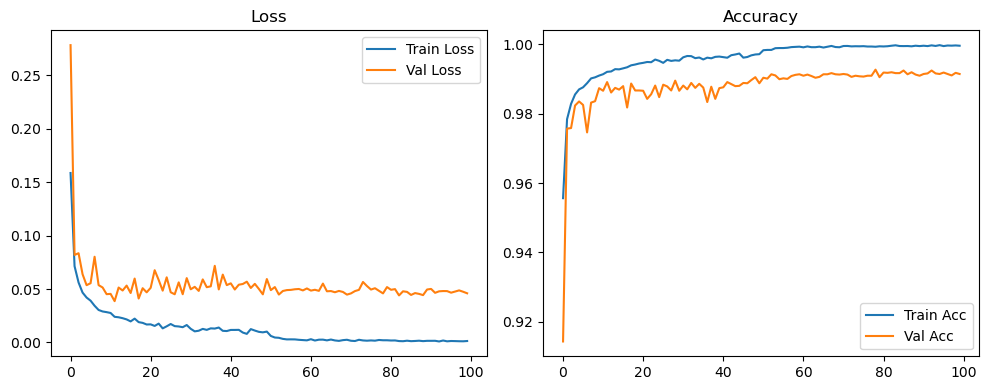

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2529, Acc: 0.9276 | Val Loss: 0.9045, Acc: 0.6858


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1389, Acc: 0.9591 | Val Loss: 0.4628, Acc: 0.8312


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9647 | Val Loss: 0.5372, Acc: 0.7994


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9683 | Val Loss: 0.3778, Acc: 0.8722


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9731 | Val Loss: 0.3533, Acc: 0.8782


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9733 | Val Loss: 0.2695, Acc: 0.9060


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0901, Acc: 0.9734 | Val Loss: 0.2364, Acc: 0.9171


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9749 | Val Loss: 0.2278, Acc: 0.9227


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9755 | Val Loss: 0.1450, Acc: 0.9533


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9768 | Val Loss: 0.2009, Acc: 0.9301


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9769 | Val Loss: 0.2117, Acc: 0.9201


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9776 | Val Loss: 0.1767, Acc: 0.9441


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9787 | Val Loss: 0.2211, Acc: 0.9258


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9790 | Val Loss: 0.1507, Acc: 0.9537


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9794 | Val Loss: 0.2762, Acc: 0.9038


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9792 | Val Loss: 0.1435, Acc: 0.9548


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9793 | Val Loss: 0.1649, Acc: 0.9465


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9807 | Val Loss: 0.2032, Acc: 0.9343


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9798 | Val Loss: 0.1713, Acc: 0.9396


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9819 | Val Loss: 0.1390, Acc: 0.9543


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9815 | Val Loss: 0.1531, Acc: 0.9482


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9819 | Val Loss: 0.1362, Acc: 0.9541


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9816 | Val Loss: 0.1196, Acc: 0.9619


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9831 | Val Loss: 0.1338, Acc: 0.9552


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9821 | Val Loss: 0.1420, Acc: 0.9522


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9826 | Val Loss: 0.1044, Acc: 0.9656


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9838 | Val Loss: 0.0910, Acc: 0.9708


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9840 | Val Loss: 0.1692, Acc: 0.9409


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9832 | Val Loss: 0.1049, Acc: 0.9681


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9831 | Val Loss: 0.1174, Acc: 0.9606


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9835 | Val Loss: 0.1373, Acc: 0.9521


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9843 | Val Loss: 0.1332, Acc: 0.9558


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9846 | Val Loss: 0.1170, Acc: 0.9622


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9837 | Val Loss: 0.1171, Acc: 0.9646


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9847 | Val Loss: 0.0977, Acc: 0.9692


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.1678, Acc: 0.9430


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.1153, Acc: 0.9627


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9841 | Val Loss: 0.1091, Acc: 0.9652


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0863, Acc: 0.9725


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9854 | Val Loss: 0.1229, Acc: 0.9613


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9846 | Val Loss: 0.1132, Acc: 0.9656


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9860 | Val Loss: 0.0961, Acc: 0.9715


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9850 | Val Loss: 0.1238, Acc: 0.9571


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9856 | Val Loss: 0.0973, Acc: 0.9695


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9860 | Val Loss: 0.0907, Acc: 0.9718


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.0936, Acc: 0.9718


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9857 | Val Loss: 0.1172, Acc: 0.9623


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9862 | Val Loss: 0.0929, Acc: 0.9715


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9850 | Val Loss: 0.1298, Acc: 0.9545


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1088, Acc: 0.9645


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.0877, Acc: 0.9737


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0966, Acc: 0.9698


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0936, Acc: 0.9701


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9902 | Val Loss: 0.0831, Acc: 0.9738


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9899 | Val Loss: 0.0970, Acc: 0.9688


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0709, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0998, Acc: 0.9671


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.1002, Acc: 0.9668


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.0885, Acc: 0.9721


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.0862, Acc: 0.9718


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.0825, Acc: 0.9746


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0812, Acc: 0.9742


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0814, Acc: 0.9758


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.0932, Acc: 0.9701


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0800, Acc: 0.9758


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0893, Acc: 0.9731


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.0852, Acc: 0.9758


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0914, Acc: 0.9728


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0837, Acc: 0.9734


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.0802, Acc: 0.9742


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0747, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0845, Acc: 0.9725


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0830, Acc: 0.9734


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0740, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0768, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0695, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0883, Acc: 0.9722


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.0631, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9918 | Val Loss: 0.0721, Acc: 0.9788


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.0798, Acc: 0.9758


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.0696, Acc: 0.9790


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0743, Acc: 0.9778


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0786, Acc: 0.9736


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0769, Acc: 0.9754


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0746, Acc: 0.9774


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0682, Acc: 0.9777


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.0742, Acc: 0.9763


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0788, Acc: 0.9745


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0736, Acc: 0.9763


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0773, Acc: 0.9758


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.0810, Acc: 0.9752


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9931 | Val Loss: 0.0719, Acc: 0.9768


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.0807, Acc: 0.9752


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0730, Acc: 0.9786


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0719, Acc: 0.9786


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0825, Acc: 0.9742


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0741, Acc: 0.9763


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0701, Acc: 0.9789


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0618, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0645, Acc: 0.9808


Final Test Loss: 0.0644 Accuracy: 0.9798


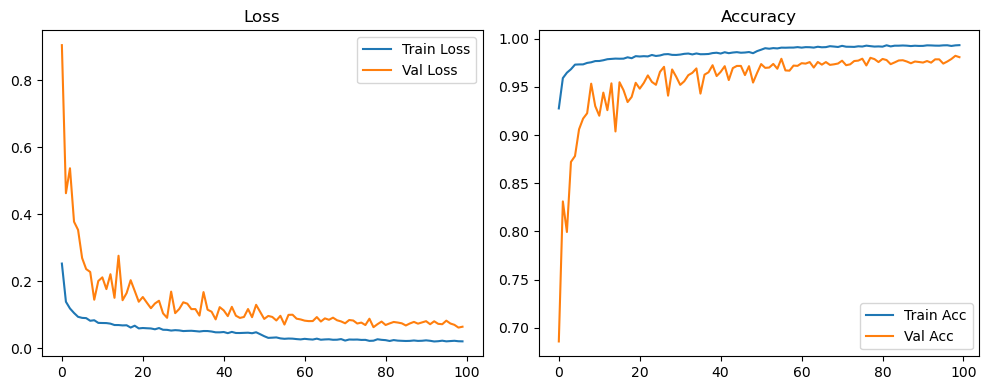

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1343, Acc: 0.9651 | Val Loss: 0.0577, Acc: 0.9826


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9845 | Val Loss: 0.0458, Acc: 0.9867


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0488, Acc: 0.9861


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9914 | Val Loss: 0.0547, Acc: 0.9841


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.0411, Acc: 0.9874


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.0452, Acc: 0.9868


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0444, Acc: 0.9878


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.0561, Acc: 0.9838


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0506, Acc: 0.9866


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0553, Acc: 0.9865


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0447, Acc: 0.9887


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0536, Acc: 0.9866


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0512, Acc: 0.9882


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0598, Acc: 0.9868


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0525, Acc: 0.9872


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0534, Acc: 0.9892


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0452, Acc: 0.9898


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0484, Acc: 0.9884


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0775, Acc: 0.9827


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0467, Acc: 0.9892


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0511, Acc: 0.9883


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0544, Acc: 0.9884


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0546, Acc: 0.9885


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0552, Acc: 0.9886


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0567, Acc: 0.9882


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0571, Acc: 0.9884


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0525, Acc: 0.9884


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0609, Acc: 0.9885


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0529, Acc: 0.9894


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0569, Acc: 0.9890


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0599, Acc: 0.9890


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0556, Acc: 0.9892


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0652, Acc: 0.9879


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0575, Acc: 0.9893


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0603, Acc: 0.9892


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0587, Acc: 0.9902


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0574, Acc: 0.9898


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0523, Acc: 0.9900


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0631, Acc: 0.9900


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0623, Acc: 0.9904


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0635, Acc: 0.9893


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0819, Acc: 0.9869


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0723, Acc: 0.9884


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0722, Acc: 0.9877


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0671, Acc: 0.9889


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0608, Acc: 0.9905


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0603, Acc: 0.9908


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0598, Acc: 0.9910


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0586, Acc: 0.9910


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0685, Acc: 0.9893


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0674, Acc: 0.9869


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0652, Acc: 0.9908


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0521, Acc: 0.9906


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0760, Acc: 0.9888


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0717, Acc: 0.9898


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0613, Acc: 0.9902


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0623, Acc: 0.9912


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0687, Acc: 0.9893


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0633, Acc: 0.9894


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0717, Acc: 0.9899


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0584, Acc: 0.9918


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0587, Acc: 0.9911


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0696, Acc: 0.9888


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0599, Acc: 0.9914


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0615, Acc: 0.9906


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0675, Acc: 0.9908


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0621, Acc: 0.9903


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0619, Acc: 0.9910


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0655, Acc: 0.9914


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0698, Acc: 0.9902


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0687, Acc: 0.9904


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0706, Acc: 0.9902


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0756, Acc: 0.9898


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0702, Acc: 0.9904


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0765, Acc: 0.9904


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0710, Acc: 0.9896


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0717, Acc: 0.9908


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0771, Acc: 0.9887


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0626, Acc: 0.9915


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0701, Acc: 0.9898


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0685, Acc: 0.9915


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.0675, Acc: 0.9902


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0726, Acc: 0.9902


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0707, Acc: 0.9907


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0699, Acc: 0.9904


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0692, Acc: 0.9908


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0751, Acc: 0.9904


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0648, Acc: 0.9913


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0692, Acc: 0.9906


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0708, Acc: 0.9921


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0795, Acc: 0.9908


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0708, Acc: 0.9906


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0744, Acc: 0.9903


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0768, Acc: 0.9902


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0818, Acc: 0.9898


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0754, Acc: 0.9918


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0741, Acc: 0.9909


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0768, Acc: 0.9914


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0822, Acc: 0.9903


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0814, Acc: 0.9904


Final Test Loss: 0.0918 Accuracy: 0.9883


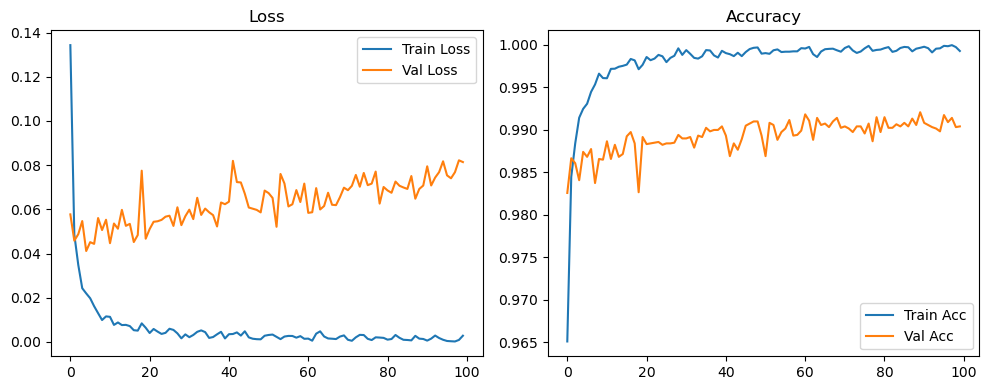

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1617, Acc: 0.9599 | Val Loss: 0.1047, Acc: 0.9682


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9793 | Val Loss: 0.0712, Acc: 0.9792


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9840 | Val Loss: 0.0639, Acc: 0.9808


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 0.0549, Acc: 0.9843


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9883 | Val Loss: 0.0491, Acc: 0.9853


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.0524, Acc: 0.9839


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0533, Acc: 0.9843


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9907 | Val Loss: 0.0524, Acc: 0.9838


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.0455, Acc: 0.9853


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0498, Acc: 0.9851


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.0452, Acc: 0.9868


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9928 | Val Loss: 0.0522, Acc: 0.9852


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0504, Acc: 0.9853


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.0384, Acc: 0.9892


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0424, Acc: 0.9870


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0598, Acc: 0.9839


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9939 | Val Loss: 0.0551, Acc: 0.9852


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.0450, Acc: 0.9872


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.0436, Acc: 0.9887


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0467, Acc: 0.9864


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0443, Acc: 0.9883


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0488, Acc: 0.9873


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0483, Acc: 0.9888


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0450, Acc: 0.9892


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0473, Acc: 0.9886


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0477, Acc: 0.9881


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0418, Acc: 0.9901


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0576, Acc: 0.9839


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0520, Acc: 0.9868


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0451, Acc: 0.9888


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0419, Acc: 0.9894


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9961 | Val Loss: 0.0426, Acc: 0.9892


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0443, Acc: 0.9891


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0450, Acc: 0.9891


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0437, Acc: 0.9907


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0402, Acc: 0.9902


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0694, Acc: 0.9844


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0437, Acc: 0.9889


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0440, Acc: 0.9890


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.0489, Acc: 0.9882


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0434, Acc: 0.9888


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0424, Acc: 0.9905


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0556, Acc: 0.9865


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0447, Acc: 0.9900


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0462, Acc: 0.9896


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0447, Acc: 0.9902


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0572, Acc: 0.9860


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0417, Acc: 0.9898


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0449, Acc: 0.9894


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0545, Acc: 0.9865


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0498, Acc: 0.9878


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0602, Acc: 0.9863


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0516, Acc: 0.9874


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0441, Acc: 0.9899


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0602, Acc: 0.9868


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0414, Acc: 0.9909


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0407, Acc: 0.9909


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0549, Acc: 0.9878


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0394, Acc: 0.9902


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0599, Acc: 0.9850


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0515, Acc: 0.9878


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0440, Acc: 0.9912


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0484, Acc: 0.9892


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0383, Acc: 0.9911


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0430, Acc: 0.9895


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0477, Acc: 0.9896


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0463, Acc: 0.9890


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0615, Acc: 0.9872


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0435, Acc: 0.9909


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0566, Acc: 0.9872


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0482, Acc: 0.9883


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0487, Acc: 0.9880


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0468, Acc: 0.9901


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0664, Acc: 0.9859


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0517, Acc: 0.9890


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.0410, Acc: 0.9902


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0483, Acc: 0.9901


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0463, Acc: 0.9899


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0434, Acc: 0.9911


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0492, Acc: 0.9890


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9980 | Val Loss: 0.0462, Acc: 0.9892


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0438, Acc: 0.9896


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0478, Acc: 0.9878


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0407, Acc: 0.9908


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0469, Acc: 0.9905


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0510, Acc: 0.9897


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0442, Acc: 0.9903


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0528, Acc: 0.9898


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0563, Acc: 0.9888


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0501, Acc: 0.9900


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0661, Acc: 0.9868


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0533, Acc: 0.9880


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0510, Acc: 0.9879


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0435, Acc: 0.9902


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.0506, Acc: 0.9902


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0474, Acc: 0.9899


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0498, Acc: 0.9908


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0506, Acc: 0.9896


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0462, Acc: 0.9901


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0490, Acc: 0.9900


Final Test Loss: 0.0485 Accuracy: 0.9893


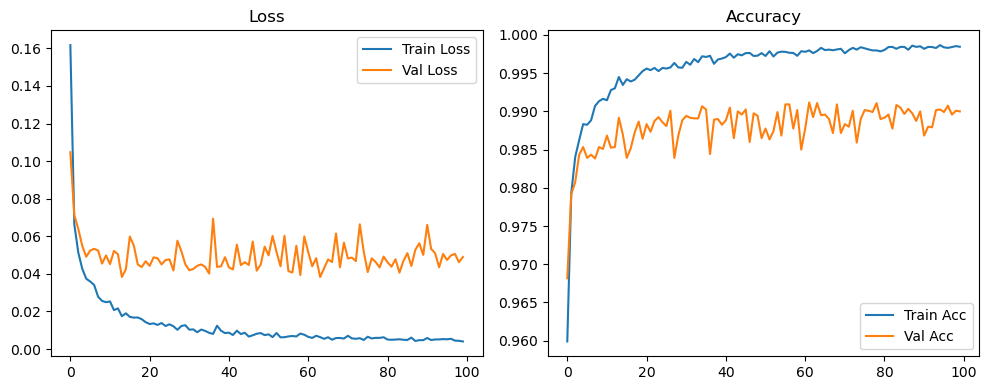

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2602, Acc: 0.9319 | Val Loss: 0.8672, Acc: 0.6809


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1308, Acc: 0.9610 | Val Loss: 0.5037, Acc: 0.8347


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1079, Acc: 0.9681 | Val Loss: 0.4361, Acc: 0.8454


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9717 | Val Loss: 0.4869, Acc: 0.8337


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9736 | Val Loss: 0.3102, Acc: 0.8920


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0827, Acc: 0.9746 | Val Loss: 0.2995, Acc: 0.8958


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9749 | Val Loss: 0.3037, Acc: 0.8953


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0779, Acc: 0.9766 | Val Loss: 0.3298, Acc: 0.8855


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9783 | Val Loss: 0.1771, Acc: 0.9381


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0699, Acc: 0.9786 | Val Loss: 0.2712, Acc: 0.9074


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9785 | Val Loss: 0.1903, Acc: 0.9352


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9787 | Val Loss: 0.1944, Acc: 0.9336


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.2050, Acc: 0.9312


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9814 | Val Loss: 0.2151, Acc: 0.9280


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9800 | Val Loss: 0.1493, Acc: 0.9511


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9811 | Val Loss: 0.1503, Acc: 0.9516


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9811 | Val Loss: 0.1597, Acc: 0.9440


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9829 | Val Loss: 0.1569, Acc: 0.9461


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9826 | Val Loss: 0.1192, Acc: 0.9604


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9834 | Val Loss: 0.2370, Acc: 0.9163


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9832 | Val Loss: 0.1163, Acc: 0.9629


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9837 | Val Loss: 0.1196, Acc: 0.9608


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.0971, Acc: 0.9695


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 0.1028, Acc: 0.9666


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9845 | Val Loss: 0.1540, Acc: 0.9469


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.1259, Acc: 0.9565


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9844 | Val Loss: 0.1253, Acc: 0.9566


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9843 | Val Loss: 0.0905, Acc: 0.9721


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.1073, Acc: 0.9665


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9848 | Val Loss: 0.1174, Acc: 0.9620


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9851 | Val Loss: 0.1142, Acc: 0.9597


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.1241, Acc: 0.9585


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.1080, Acc: 0.9656


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.1137, Acc: 0.9619


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.1032, Acc: 0.9666


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9859 | Val Loss: 0.1322, Acc: 0.9563


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9866 | Val Loss: 0.0970, Acc: 0.9677


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9873 | Val Loss: 0.0919, Acc: 0.9713


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.0915, Acc: 0.9712


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.0999, Acc: 0.9669


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9863 | Val Loss: 0.1042, Acc: 0.9663


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.0866, Acc: 0.9744


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9866 | Val Loss: 0.1020, Acc: 0.9672


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0735, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.0731, Acc: 0.9783


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9869 | Val Loss: 0.0864, Acc: 0.9728


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.1003, Acc: 0.9669


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9873 | Val Loss: 0.0773, Acc: 0.9792


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0901, Acc: 0.9707


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9871 | Val Loss: 0.0711, Acc: 0.9786


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9873 | Val Loss: 0.1099, Acc: 0.9659


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.0968, Acc: 0.9679


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.0883, Acc: 0.9729


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0911, Acc: 0.9749


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 0.1265, Acc: 0.9568


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.0912, Acc: 0.9721


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0967, Acc: 0.9699


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9885 | Val Loss: 0.0992, Acc: 0.9685


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9879 | Val Loss: 0.0970, Acc: 0.9709


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0872, Acc: 0.9742


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.1221, Acc: 0.9598


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.1145, Acc: 0.9620


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9891 | Val Loss: 0.0844, Acc: 0.9742


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.0877, Acc: 0.9747


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0960, Acc: 0.9693


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.1091, Acc: 0.9643


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.1018, Acc: 0.9707


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 0.1017, Acc: 0.9689


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0958, Acc: 0.9722


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.0862, Acc: 0.9758


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9895 | Val Loss: 0.0812, Acc: 0.9776


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.0889, Acc: 0.9725


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.1109, Acc: 0.9622


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.0962, Acc: 0.9707


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9893 | Val Loss: 0.0984, Acc: 0.9698


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0844, Acc: 0.9762


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0903, Acc: 0.9741


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9885 | Val Loss: 0.0774, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9895 | Val Loss: 0.0937, Acc: 0.9724


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9900 | Val Loss: 0.0958, Acc: 0.9724


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.0844, Acc: 0.9735


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9895 | Val Loss: 0.0751, Acc: 0.9794


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.0977, Acc: 0.9719


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.1000, Acc: 0.9704


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9897 | Val Loss: 0.1051, Acc: 0.9684


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.0743, Acc: 0.9786


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.0795, Acc: 0.9755


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.1301, Acc: 0.9563


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0710, Acc: 0.9799


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.0873, Acc: 0.9742


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0843, Acc: 0.9779


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.1051, Acc: 0.9700


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0863, Acc: 0.9762


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0716, Acc: 0.9800


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0701, Acc: 0.9792


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9898 | Val Loss: 0.0903, Acc: 0.9713


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.0807, Acc: 0.9756


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.0936, Acc: 0.9706


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0732, Acc: 0.9779


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.0857, Acc: 0.9730


Final Test Loss: 0.0782 Accuracy: 0.9760


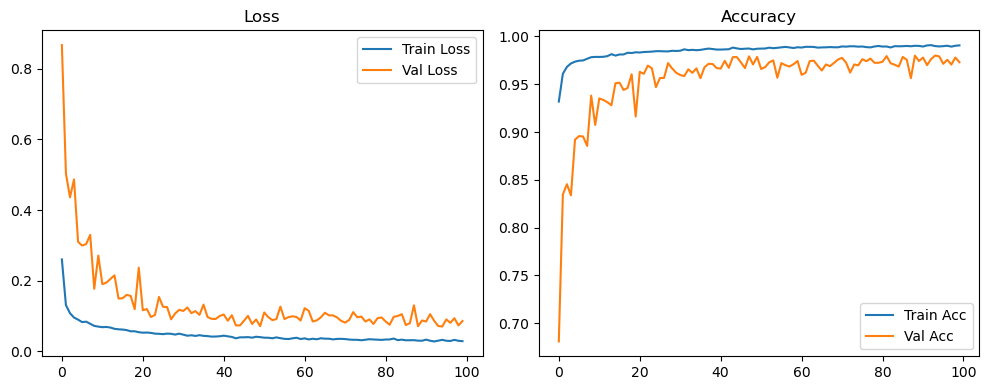

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1343, Acc: 0.9651 | Val Loss: 0.0577, Acc: 0.9826


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9845 | Val Loss: 0.0458, Acc: 0.9867


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9881 | Val Loss: 0.0499, Acc: 0.9842


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9915 | Val Loss: 0.0484, Acc: 0.9848


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0468, Acc: 0.9869


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.0490, Acc: 0.9857


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9942 | Val Loss: 0.0441, Acc: 0.9872


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0509, Acc: 0.9850


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0527, Acc: 0.9867


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0447, Acc: 0.9878


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9957 | Val Loss: 0.0513, Acc: 0.9868


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0480, Acc: 0.9875


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0455, Acc: 0.9891


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0455, Acc: 0.9895


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0511, Acc: 0.9876


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.0471, Acc: 0.9897


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0458, Acc: 0.9903


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0516, Acc: 0.9890


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0585, Acc: 0.9869


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0494, Acc: 0.9898


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0589, Acc: 0.9888


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0555, Acc: 0.9892


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0605, Acc: 0.9876


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0524, Acc: 0.9893


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0503, Acc: 0.9896


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0536, Acc: 0.9895


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0578, Acc: 0.9898


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0507, Acc: 0.9908


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0585, Acc: 0.9884


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0606, Acc: 0.9886


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0543, Acc: 0.9903


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0583, Acc: 0.9894


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0619, Acc: 0.9888


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0547, Acc: 0.9896


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0672, Acc: 0.9889


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0712, Acc: 0.9886


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0544, Acc: 0.9905


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0650, Acc: 0.9882


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0563, Acc: 0.9906


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.0720, Acc: 0.9878


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0487, Acc: 0.9923


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0631, Acc: 0.9888


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0595, Acc: 0.9904


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0648, Acc: 0.9892


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0560, Acc: 0.9916


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.0563, Acc: 0.9909


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0734, Acc: 0.9888


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0942, Acc: 0.9868


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0721, Acc: 0.9886


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0638, Acc: 0.9910


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0545, Acc: 0.9920


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0557, Acc: 0.9916


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0504, Acc: 0.9920


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0559, Acc: 0.9918


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0532, Acc: 0.9914


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9920


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9920


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9916


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0632, Acc: 0.9912


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0565, Acc: 0.9911


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9924


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0643, Acc: 0.9909


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0525, Acc: 0.9918


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0622, Acc: 0.9913


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0599, Acc: 0.9919


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9921


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0621, Acc: 0.9912


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0658, Acc: 0.9917


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0652, Acc: 0.9919


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0629, Acc: 0.9914


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0631, Acc: 0.9913


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0594, Acc: 0.9922


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0618, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0579, Acc: 0.9921


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0645, Acc: 0.9914


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0646, Acc: 0.9915


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9918


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0592, Acc: 0.9916


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0609, Acc: 0.9925


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0651, Acc: 0.9924


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0614, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9926


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9921


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9925


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9931


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9928


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0619, Acc: 0.9928


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9921


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0682, Acc: 0.9924


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0692, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9921


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9928


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0700, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9927


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9914


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0620, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0633, Acc: 0.9928


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9931


Final Test Loss: 0.0620 Accuracy: 0.9926


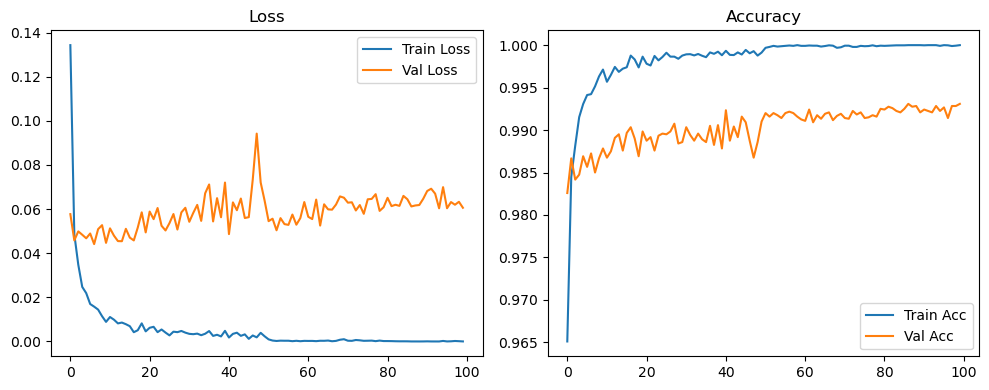

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1617, Acc: 0.9599 | Val Loss: 0.1047, Acc: 0.9682


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9790 | Val Loss: 0.0826, Acc: 0.9746


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9840 | Val Loss: 0.0827, Acc: 0.9748


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9859 | Val Loss: 0.0518, Acc: 0.9851


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.0529, Acc: 0.9836


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9884 | Val Loss: 0.0496, Acc: 0.9850


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0638, Acc: 0.9809


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9899 | Val Loss: 0.0586, Acc: 0.9824


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0480, Acc: 0.9858


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0455, Acc: 0.9872


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0421, Acc: 0.9884


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0420, Acc: 0.9879


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0420, Acc: 0.9870


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0473, Acc: 0.9862


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0331, Acc: 0.9898


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0457, Acc: 0.9878


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0661, Acc: 0.9809


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.0443, Acc: 0.9862


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0407, Acc: 0.9889


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0497, Acc: 0.9857


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9951 | Val Loss: 0.0450, Acc: 0.9876


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0443, Acc: 0.9888


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0378, Acc: 0.9902


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0466, Acc: 0.9887


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0428, Acc: 0.9889


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9955 | Val Loss: 0.0486, Acc: 0.9877


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0472, Acc: 0.9872


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.0609, Acc: 0.9842


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0517, Acc: 0.9872


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0478, Acc: 0.9889


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0556, Acc: 0.9870


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0520, Acc: 0.9878


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0459, Acc: 0.9888


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0452, Acc: 0.9889


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0427, Acc: 0.9908


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0503, Acc: 0.9881


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0458, Acc: 0.9889


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0506, Acc: 0.9879


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0522, Acc: 0.9881


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0533, Acc: 0.9871


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0445, Acc: 0.9888


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0445, Acc: 0.9899


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0455, Acc: 0.9890


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0442, Acc: 0.9906


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0403, Acc: 0.9900


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0422, Acc: 0.9900


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0555, Acc: 0.9865


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0507, Acc: 0.9890


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0487, Acc: 0.9887


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0572, Acc: 0.9881


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0415, Acc: 0.9894


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0469, Acc: 0.9893


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0416, Acc: 0.9897


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0414, Acc: 0.9903


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0399, Acc: 0.9910


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0391, Acc: 0.9917


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0453, Acc: 0.9904


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0442, Acc: 0.9909


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0388, Acc: 0.9915


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0471, Acc: 0.9904


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0477, Acc: 0.9889


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0421, Acc: 0.9908


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0480, Acc: 0.9897


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0438, Acc: 0.9909


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0435, Acc: 0.9894


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0411, Acc: 0.9906


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0401, Acc: 0.9910


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0427, Acc: 0.9902


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0473, Acc: 0.9906


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0538, Acc: 0.9888


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0482, Acc: 0.9904


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0452, Acc: 0.9909


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0521, Acc: 0.9898


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0482, Acc: 0.9896


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0448, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0479, Acc: 0.9904


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0459, Acc: 0.9914


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0413, Acc: 0.9913


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0447, Acc: 0.9920


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0466, Acc: 0.9904


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0464, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0428, Acc: 0.9911


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0422, Acc: 0.9912


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0405, Acc: 0.9913


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0437, Acc: 0.9910


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0398, Acc: 0.9918


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0355, Acc: 0.9925


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0408, Acc: 0.9919


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0418, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0401, Acc: 0.9925


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0441, Acc: 0.9919


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0437, Acc: 0.9913


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0431, Acc: 0.9917


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0438, Acc: 0.9913


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0487, Acc: 0.9911


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0466, Acc: 0.9909


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0436, Acc: 0.9918


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0448, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0427, Acc: 0.9916


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0417, Acc: 0.9919


Final Test Loss: 0.0447 Accuracy: 0.9903


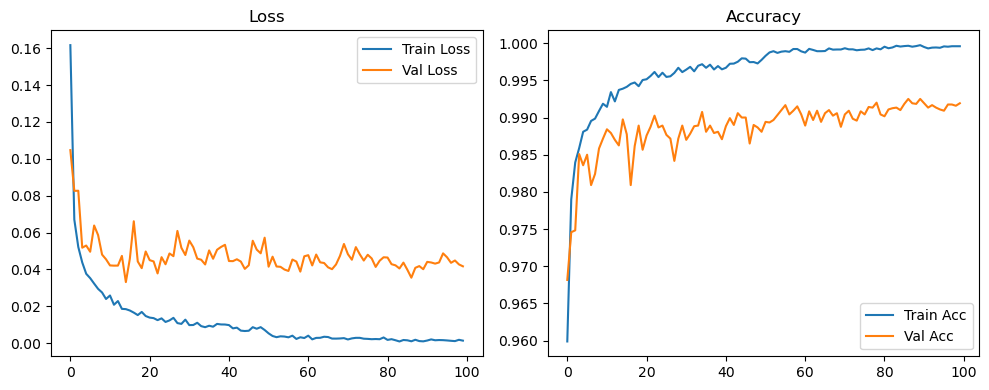

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2602, Acc: 0.9319 | Val Loss: 0.8672, Acc: 0.6809


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1308, Acc: 0.9613 | Val Loss: 0.4723, Acc: 0.8456


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1083, Acc: 0.9673 | Val Loss: 0.4040, Acc: 0.8593


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0990, Acc: 0.9706 | Val Loss: 0.3390, Acc: 0.8881


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9738 | Val Loss: 0.2454, Acc: 0.9203


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9750 | Val Loss: 0.3122, Acc: 0.8908


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9750 | Val Loss: 0.2740, Acc: 0.9081


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0770, Acc: 0.9765 | Val Loss: 0.3573, Acc: 0.8752


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0722, Acc: 0.9779 | Val Loss: 0.1228, Acc: 0.9635


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9790 | Val Loss: 0.2025, Acc: 0.9327


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9789 | Val Loss: 0.1468, Acc: 0.9523


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9796 | Val Loss: 0.1853, Acc: 0.9418


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9805 | Val Loss: 0.1841, Acc: 0.9366


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9808 | Val Loss: 0.2085, Acc: 0.9306


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9805 | Val Loss: 0.2737, Acc: 0.9083


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9805 | Val Loss: 0.2202, Acc: 0.9259


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9812 | Val Loss: 0.1604, Acc: 0.9444


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9817 | Val Loss: 0.1639, Acc: 0.9452


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9826 | Val Loss: 0.0886, Acc: 0.9705


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9826 | Val Loss: 0.2352, Acc: 0.9160


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9827 | Val Loss: 0.0875, Acc: 0.9736


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9837 | Val Loss: 0.1135, Acc: 0.9629


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.1170, Acc: 0.9629


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9845 | Val Loss: 0.1541, Acc: 0.9482


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9841 | Val Loss: 0.1349, Acc: 0.9523


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9845 | Val Loss: 0.1343, Acc: 0.9515


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9843 | Val Loss: 0.0892, Acc: 0.9720


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9845 | Val Loss: 0.1034, Acc: 0.9643


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9848 | Val Loss: 0.1279, Acc: 0.9583


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9850 | Val Loss: 0.1212, Acc: 0.9605


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9851 | Val Loss: 0.1357, Acc: 0.9545


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9860 | Val Loss: 0.1324, Acc: 0.9553


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.1033, Acc: 0.9674


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9862 | Val Loss: 0.1140, Acc: 0.9635


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9865 | Val Loss: 0.1101, Acc: 0.9630


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9853 | Val Loss: 0.1564, Acc: 0.9470


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 0.1188, Acc: 0.9596


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9861 | Val Loss: 0.1168, Acc: 0.9628


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 0.1019, Acc: 0.9651


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9862 | Val Loss: 0.1102, Acc: 0.9637


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9867 | Val Loss: 0.1129, Acc: 0.9634


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9867 | Val Loss: 0.1015, Acc: 0.9673


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.1010, Acc: 0.9662


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9870 | Val Loss: 0.0909, Acc: 0.9702


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.1448, Acc: 0.9493


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.1011, Acc: 0.9663


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9877 | Val Loss: 0.1404, Acc: 0.9524


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9880 | Val Loss: 0.1167, Acc: 0.9615


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.1125, Acc: 0.9626


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.1034, Acc: 0.9658


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9896 | Val Loss: 0.1036, Acc: 0.9665


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.1044, Acc: 0.9656


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0942, Acc: 0.9686


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9900 | Val Loss: 0.1054, Acc: 0.9663


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9901 | Val Loss: 0.0951, Acc: 0.9683


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.0924, Acc: 0.9695


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.1020, Acc: 0.9650


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9908 | Val Loss: 0.1079, Acc: 0.9620


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.1043, Acc: 0.9653


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0840, Acc: 0.9731


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.1112, Acc: 0.9623


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0873, Acc: 0.9707


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9920 | Val Loss: 0.0748, Acc: 0.9759


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0953, Acc: 0.9697


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9915 | Val Loss: 0.0947, Acc: 0.9704


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.1135, Acc: 0.9603


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.0750, Acc: 0.9769


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1174, Acc: 0.9597


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9907 | Val Loss: 0.1169, Acc: 0.9603


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0926, Acc: 0.9699


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0834, Acc: 0.9731


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1030, Acc: 0.9647


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.1002, Acc: 0.9663


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.1040, Acc: 0.9658


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9910 | Val Loss: 0.0722, Acc: 0.9775


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0701, Acc: 0.9795


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9910 | Val Loss: 0.0989, Acc: 0.9697


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0859, Acc: 0.9728


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.0816, Acc: 0.9759


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9913 | Val Loss: 0.0822, Acc: 0.9736


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9917 | Val Loss: 0.0827, Acc: 0.9747


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.0752, Acc: 0.9752


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.0796, Acc: 0.9740


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0843, Acc: 0.9739


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.0923, Acc: 0.9698


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0971, Acc: 0.9683


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0929, Acc: 0.9684


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0879, Acc: 0.9715


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.0934, Acc: 0.9699


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.0707, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0818, Acc: 0.9758


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0942, Acc: 0.9694


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0767, Acc: 0.9756


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0819, Acc: 0.9756


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.0710, Acc: 0.9789


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0902, Acc: 0.9709


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0723, Acc: 0.9782


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0800, Acc: 0.9752


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0791, Acc: 0.9754


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9925 | Val Loss: 0.0779, Acc: 0.9758


Final Test Loss: 0.0725 Accuracy: 0.9775


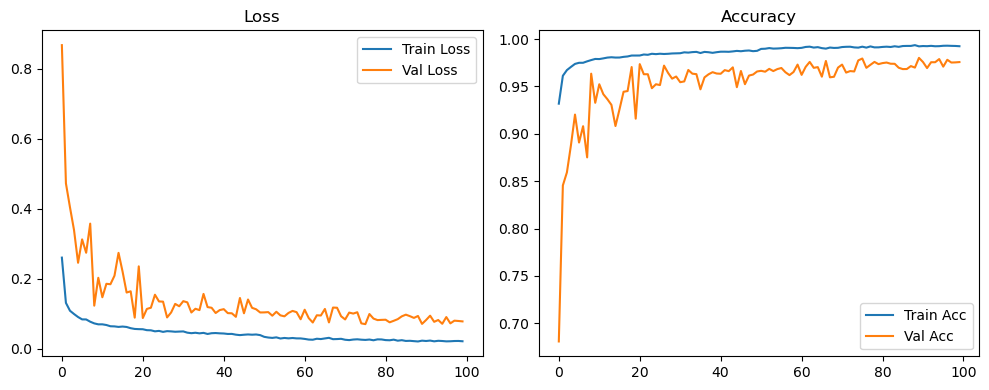

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1727, Acc: 0.9666 | Val Loss: 0.0592, Acc: 0.9818


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9862 | Val Loss: 0.0447, Acc: 0.9858


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.0489, Acc: 0.9844


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.0452, Acc: 0.9859


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0471, Acc: 0.9852


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.0388, Acc: 0.9883


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0440, Acc: 0.9868


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0464, Acc: 0.9854


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0484, Acc: 0.9868


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0433, Acc: 0.9887


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0530, Acc: 0.9862


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0426, Acc: 0.9885


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0425, Acc: 0.9884


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0450, Acc: 0.9895


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0475, Acc: 0.9880


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0423, Acc: 0.9890


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0602, Acc: 0.9860


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0472, Acc: 0.9878


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0518, Acc: 0.9879


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0443, Acc: 0.9899


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0571, Acc: 0.9862


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0692, Acc: 0.9858


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0509, Acc: 0.9885


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0504, Acc: 0.9879


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0609, Acc: 0.9856


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0505, Acc: 0.9892


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0485, Acc: 0.9896


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0541, Acc: 0.9889


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0520, Acc: 0.9892


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0464, Acc: 0.9896


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0488, Acc: 0.9899


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0500, Acc: 0.9912


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0594, Acc: 0.9882


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0527, Acc: 0.9898


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0545, Acc: 0.9879


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0541, Acc: 0.9906


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0497, Acc: 0.9898


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0505, Acc: 0.9911


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0573, Acc: 0.9885


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0531, Acc: 0.9897


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0627, Acc: 0.9871


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0549, Acc: 0.9895


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0625, Acc: 0.9882


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0584, Acc: 0.9885


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0492, Acc: 0.9901


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0519, Acc: 0.9900


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0583, Acc: 0.9896


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.0601, Acc: 0.9883


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0656, Acc: 0.9877


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0496, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0481, Acc: 0.9903


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0609, Acc: 0.9896


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0528, Acc: 0.9895


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0710, Acc: 0.9862


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0505, Acc: 0.9902


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0614, Acc: 0.9884


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0480, Acc: 0.9912


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0607, Acc: 0.9894


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0500, Acc: 0.9906


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0593, Acc: 0.9895


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0510, Acc: 0.9895


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0524, Acc: 0.9910


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0573, Acc: 0.9898


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0679, Acc: 0.9887


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0504, Acc: 0.9903


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0657, Acc: 0.9892


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0628, Acc: 0.9893


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0564, Acc: 0.9906


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0487, Acc: 0.9917


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0520, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0665, Acc: 0.9887


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0641, Acc: 0.9899


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0590, Acc: 0.9901


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0537, Acc: 0.9912


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0573, Acc: 0.9901


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0626, Acc: 0.9900


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0611, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0546, Acc: 0.9899


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0573, Acc: 0.9902


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0557, Acc: 0.9908


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0634, Acc: 0.9896


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0568, Acc: 0.9910


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0681, Acc: 0.9890


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0605, Acc: 0.9908


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0567, Acc: 0.9910


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0661, Acc: 0.9906


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0592, Acc: 0.9908


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0610, Acc: 0.9909


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0649, Acc: 0.9902


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0578, Acc: 0.9908


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0597, Acc: 0.9903


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0571, Acc: 0.9898


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0618, Acc: 0.9909


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0592, Acc: 0.9902


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0634, Acc: 0.9894


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0577, Acc: 0.9903


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9901


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0595, Acc: 0.9906


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0585, Acc: 0.9900


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0682, Acc: 0.9903


Final Test Loss: 0.0676 Accuracy: 0.9884


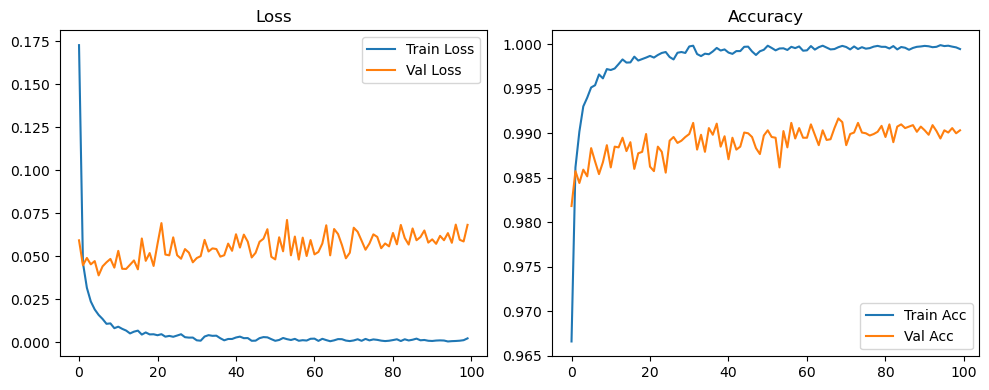

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2017, Acc: 0.9608 | Val Loss: 0.1620, Acc: 0.9565


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0654, Acc: 0.9805 | Val Loss: 0.0650, Acc: 0.9819


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9841 | Val Loss: 0.0638, Acc: 0.9822


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 0.0563, Acc: 0.9838


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.0589, Acc: 0.9826


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.0614, Acc: 0.9812


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0589, Acc: 0.9824


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9901 | Val Loss: 0.0506, Acc: 0.9836


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0489, Acc: 0.9851


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0518, Acc: 0.9844


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0460, Acc: 0.9852


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.0424, Acc: 0.9874


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0435, Acc: 0.9866


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0369, Acc: 0.9892


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0434, Acc: 0.9885


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0483, Acc: 0.9861


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0555, Acc: 0.9848


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0432, Acc: 0.9883


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0392, Acc: 0.9892


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0443, Acc: 0.9872


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0419, Acc: 0.9880


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.0496, Acc: 0.9856


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0473, Acc: 0.9874


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0415, Acc: 0.9884


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0421, Acc: 0.9882


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0483, Acc: 0.9863


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0415, Acc: 0.9894


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0428, Acc: 0.9878


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0458, Acc: 0.9880


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0468, Acc: 0.9878


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0397, Acc: 0.9892


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0450, Acc: 0.9888


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0389, Acc: 0.9890


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0446, Acc: 0.9881


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0381, Acc: 0.9900


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0483, Acc: 0.9882


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0465, Acc: 0.9876


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0454, Acc: 0.9885


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0395, Acc: 0.9889


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0379, Acc: 0.9905


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0378, Acc: 0.9899


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0447, Acc: 0.9882


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0416, Acc: 0.9895


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0475, Acc: 0.9888


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0455, Acc: 0.9889


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0431, Acc: 0.9891


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0467, Acc: 0.9874


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0503, Acc: 0.9865


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0358, Acc: 0.9912


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0411, Acc: 0.9903


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0456, Acc: 0.9882


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0480, Acc: 0.9886


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0432, Acc: 0.9900


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0417, Acc: 0.9898


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0470, Acc: 0.9892


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0449, Acc: 0.9896


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0416, Acc: 0.9900


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0402, Acc: 0.9899


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0413, Acc: 0.9908


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0444, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0502, Acc: 0.9883


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0419, Acc: 0.9905


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0408, Acc: 0.9916


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0411, Acc: 0.9902


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0404, Acc: 0.9902


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0408, Acc: 0.9908


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0441, Acc: 0.9896


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0404, Acc: 0.9899


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0438, Acc: 0.9896


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0399, Acc: 0.9903


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0406, Acc: 0.9895


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0388, Acc: 0.9908


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0438, Acc: 0.9902


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0435, Acc: 0.9893


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0433, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0473, Acc: 0.9890


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0475, Acc: 0.9887


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0435, Acc: 0.9904


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0438, Acc: 0.9894


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0462, Acc: 0.9888


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0475, Acc: 0.9882


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0395, Acc: 0.9902


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0398, Acc: 0.9895


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0421, Acc: 0.9905


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0477, Acc: 0.9908


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0461, Acc: 0.9896


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0415, Acc: 0.9905


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0500, Acc: 0.9888


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0410, Acc: 0.9913


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0390, Acc: 0.9909


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0504, Acc: 0.9880


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0465, Acc: 0.9896


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0455, Acc: 0.9895


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0454, Acc: 0.9900


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0488, Acc: 0.9890


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0418, Acc: 0.9903


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0376, Acc: 0.9913


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0441, Acc: 0.9896


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0394, Acc: 0.9902


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0426, Acc: 0.9903


Final Test Loss: 0.0413 Accuracy: 0.9901


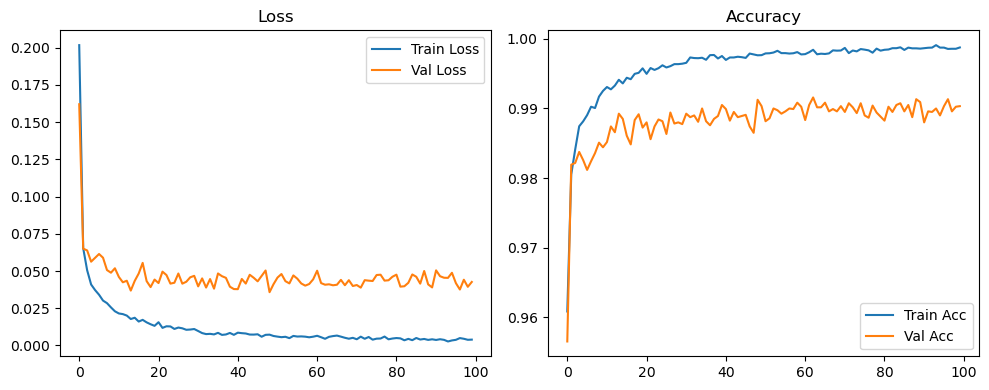

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3168, Acc: 0.9313 | Val Loss: 0.8556, Acc: 0.6994


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1302, Acc: 0.9632 | Val Loss: 0.5958, Acc: 0.7927


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1080, Acc: 0.9687 | Val Loss: 0.4748, Acc: 0.8352


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0945, Acc: 0.9725 | Val Loss: 0.4014, Acc: 0.8566


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0873, Acc: 0.9745 | Val Loss: 0.2975, Acc: 0.9003


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0824, Acc: 0.9750 | Val Loss: 0.2943, Acc: 0.9014


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0781, Acc: 0.9773 | Val Loss: 0.3182, Acc: 0.8956


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9776 | Val Loss: 0.3107, Acc: 0.8943


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0736, Acc: 0.9783 | Val Loss: 0.2136, Acc: 0.9267


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0675, Acc: 0.9796 | Val Loss: 0.1999, Acc: 0.9375


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9799 | Val Loss: 0.1802, Acc: 0.9393


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0659, Acc: 0.9802 | Val Loss: 0.1674, Acc: 0.9439


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9789 | Val Loss: 0.2118, Acc: 0.9309


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9817 | Val Loss: 0.2245, Acc: 0.9213


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9815 | Val Loss: 0.1812, Acc: 0.9395


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9823 | Val Loss: 0.1662, Acc: 0.9452


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9824 | Val Loss: 0.2342, Acc: 0.9159


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9834 | Val Loss: 0.1124, Acc: 0.9625


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9825 | Val Loss: 0.1164, Acc: 0.9644


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9841 | Val Loss: 0.1446, Acc: 0.9520


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9841 | Val Loss: 0.1814, Acc: 0.9328


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9844 | Val Loss: 0.1207, Acc: 0.9631


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9839 | Val Loss: 0.1323, Acc: 0.9562


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0478, Acc: 0.9851 | Val Loss: 0.1456, Acc: 0.9520


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9843 | Val Loss: 0.1544, Acc: 0.9483


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9845 | Val Loss: 0.1646, Acc: 0.9396


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9854 | Val Loss: 0.1047, Acc: 0.9666


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9846 | Val Loss: 0.1355, Acc: 0.9562


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.1358, Acc: 0.9537


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9863 | Val Loss: 0.1175, Acc: 0.9611


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9861 | Val Loss: 0.1084, Acc: 0.9642


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.0934, Acc: 0.9704


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9857 | Val Loss: 0.1103, Acc: 0.9637


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.1449, Acc: 0.9512


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0979, Acc: 0.9698


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1256, Acc: 0.9597


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9869 | Val Loss: 0.1072, Acc: 0.9665


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9867 | Val Loss: 0.0962, Acc: 0.9688


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9872 | Val Loss: 0.0966, Acc: 0.9701


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9872 | Val Loss: 0.1217, Acc: 0.9617


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.1435, Acc: 0.9536


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9873 | Val Loss: 0.0901, Acc: 0.9742


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 0.1023, Acc: 0.9682


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9871 | Val Loss: 0.1122, Acc: 0.9676


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9880 | Val Loss: 0.1022, Acc: 0.9702


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0876, Acc: 0.9748


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 0.1483, Acc: 0.9503


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9885 | Val Loss: 0.0912, Acc: 0.9732


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 0.1168, Acc: 0.9632


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.0851, Acc: 0.9760


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9875 | Val Loss: 0.0988, Acc: 0.9690


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9890 | Val Loss: 0.1040, Acc: 0.9671


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 0.1024, Acc: 0.9683


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9883 | Val Loss: 0.1000, Acc: 0.9673


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.1214, Acc: 0.9607


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.0930, Acc: 0.9741


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.1080, Acc: 0.9672


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9884 | Val Loss: 0.1004, Acc: 0.9712


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.1044, Acc: 0.9670


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9892 | Val Loss: 0.0844, Acc: 0.9749


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.1194, Acc: 0.9641


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.0972, Acc: 0.9685


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.0940, Acc: 0.9698


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.1066, Acc: 0.9663


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9895 | Val Loss: 0.0942, Acc: 0.9707


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9888 | Val Loss: 0.1033, Acc: 0.9639


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 0.0846, Acc: 0.9748


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.1082, Acc: 0.9619


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 0.0832, Acc: 0.9750


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.0888, Acc: 0.9721


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9902 | Val Loss: 0.0778, Acc: 0.9762


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.0839, Acc: 0.9760


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.1008, Acc: 0.9674


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0702, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.0773, Acc: 0.9790


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.1078, Acc: 0.9683


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1054, Acc: 0.9708


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0962, Acc: 0.9710


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0821, Acc: 0.9777


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.0833, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.0859, Acc: 0.9769


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0726, Acc: 0.9799


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.0881, Acc: 0.9758


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0948, Acc: 0.9724


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0986, Acc: 0.9707


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1012, Acc: 0.9689


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0917, Acc: 0.9710


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1103, Acc: 0.9636


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0820, Acc: 0.9768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0871, Acc: 0.9778


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.1006, Acc: 0.9717


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1002, Acc: 0.9718


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.0900, Acc: 0.9759


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0954, Acc: 0.9714


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9908 | Val Loss: 0.0808, Acc: 0.9772


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.0956, Acc: 0.9732


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0861, Acc: 0.9732


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.1114, Acc: 0.9647


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0873, Acc: 0.9755


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0754, Acc: 0.9776


Final Test Loss: 0.0711 Accuracy: 0.9791


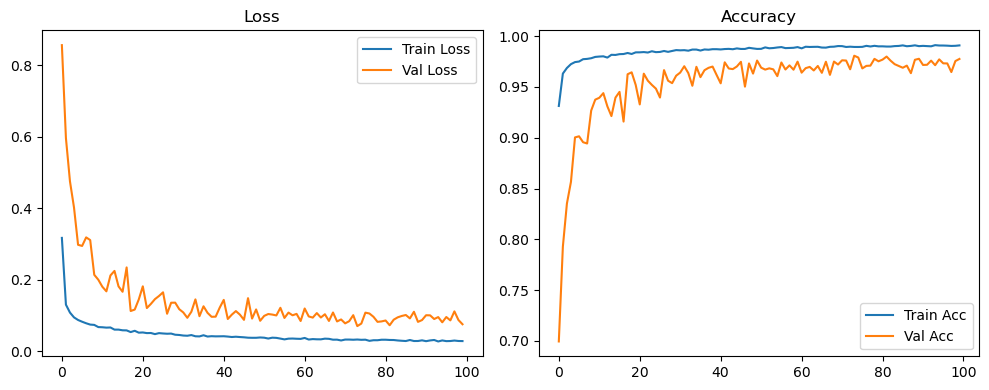

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2388, Acc: 0.9639 | Val Loss: 0.0735, Acc: 0.9807


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9859 | Val Loss: 0.0501, Acc: 0.9861


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9904 | Val Loss: 0.0498, Acc: 0.9852


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9930 | Val Loss: 0.0433, Acc: 0.9868


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9945 | Val Loss: 0.0460, Acc: 0.9863


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.0388, Acc: 0.9882


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0394, Acc: 0.9875


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9971 | Val Loss: 0.0446, Acc: 0.9866


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.0485, Acc: 0.9850


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0477, Acc: 0.9864


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0615, Acc: 0.9831


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0356, Acc: 0.9880


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0395, Acc: 0.9883


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0452, Acc: 0.9871


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0421, Acc: 0.9882


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0504, Acc: 0.9871


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0434, Acc: 0.9892


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0438, Acc: 0.9887


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0458, Acc: 0.9887


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0453, Acc: 0.9900


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0458, Acc: 0.9889


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0540, Acc: 0.9858


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0464, Acc: 0.9873


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0493, Acc: 0.9876


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0406, Acc: 0.9898


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0620, Acc: 0.9852


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0592, Acc: 0.9862


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0491, Acc: 0.9890


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0494, Acc: 0.9878


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0481, Acc: 0.9888


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0445, Acc: 0.9898


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0544, Acc: 0.9878


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0538, Acc: 0.9880


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0574, Acc: 0.9863


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0436, Acc: 0.9891


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0441, Acc: 0.9902


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0462, Acc: 0.9894


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0602, Acc: 0.9873


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0553, Acc: 0.9872


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0570, Acc: 0.9884


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0591, Acc: 0.9885


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0584, Acc: 0.9882


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0587, Acc: 0.9878


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0511, Acc: 0.9885


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0565, Acc: 0.9882


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0508, Acc: 0.9890


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0466, Acc: 0.9901


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0522, Acc: 0.9892


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0584, Acc: 0.9878


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0513, Acc: 0.9889


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0510, Acc: 0.9897


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0486, Acc: 0.9905


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0506, Acc: 0.9896


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0672, Acc: 0.9858


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0637, Acc: 0.9875


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0539, Acc: 0.9895


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0473, Acc: 0.9908


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0502, Acc: 0.9893


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0548, Acc: 0.9896


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0531, Acc: 0.9899


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0511, Acc: 0.9903


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0524, Acc: 0.9905


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0503, Acc: 0.9898


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0581, Acc: 0.9892


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0486, Acc: 0.9899


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0445, Acc: 0.9908


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0517, Acc: 0.9894


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0598, Acc: 0.9888


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0555, Acc: 0.9895


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9886


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0519, Acc: 0.9906


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0580, Acc: 0.9898


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0527, Acc: 0.9904


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0580, Acc: 0.9897


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0599, Acc: 0.9893


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0628, Acc: 0.9886


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0544, Acc: 0.9903


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0511, Acc: 0.9905


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0483, Acc: 0.9909


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0483, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0561, Acc: 0.9906


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0558, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0496, Acc: 0.9920


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0531, Acc: 0.9912


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0628, Acc: 0.9894


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0612, Acc: 0.9896


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0638, Acc: 0.9886


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0564, Acc: 0.9897


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0541, Acc: 0.9908


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0553, Acc: 0.9903


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0624, Acc: 0.9900


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0631, Acc: 0.9895


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9901


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0595, Acc: 0.9891


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0576, Acc: 0.9893


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0626, Acc: 0.9894


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0590, Acc: 0.9907


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0561, Acc: 0.9901


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0539, Acc: 0.9907


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9900


Final Test Loss: 0.0525 Accuracy: 0.9896


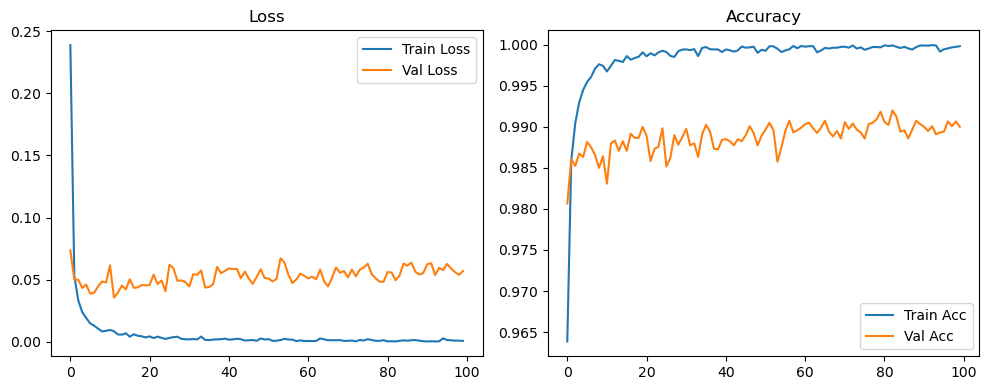

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2772, Acc: 0.9571 | Val Loss: 0.1683, Acc: 0.9627


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9818 | Val Loss: 0.0842, Acc: 0.9800


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9846 | Val Loss: 0.0809, Acc: 0.9787


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 0.0646, Acc: 0.9822


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9887 | Val Loss: 0.0525, Acc: 0.9840


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9889 | Val Loss: 0.0576, Acc: 0.9830


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.0519, Acc: 0.9843


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.0553, Acc: 0.9827


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.0527, Acc: 0.9820


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0495, Acc: 0.9838


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.0530, Acc: 0.9838


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9926 | Val Loss: 0.0414, Acc: 0.9881


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0458, Acc: 0.9866


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9937 | Val Loss: 0.0497, Acc: 0.9855


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.0535, Acc: 0.9847


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0490, Acc: 0.9851


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0457, Acc: 0.9876


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0540, Acc: 0.9843


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0404, Acc: 0.9878


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0452, Acc: 0.9869


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0460, Acc: 0.9861


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0460, Acc: 0.9886


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0494, Acc: 0.9872


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0523, Acc: 0.9858


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0406, Acc: 0.9897


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0535, Acc: 0.9847


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0500, Acc: 0.9858


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.0452, Acc: 0.9879


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0438, Acc: 0.9876


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0384, Acc: 0.9888


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0444, Acc: 0.9880


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0429, Acc: 0.9888


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0411, Acc: 0.9882


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0433, Acc: 0.9885


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0449, Acc: 0.9874


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0445, Acc: 0.9879


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0466, Acc: 0.9872


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0444, Acc: 0.9883


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.0460, Acc: 0.9871


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0394, Acc: 0.9895


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0488, Acc: 0.9858


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0431, Acc: 0.9882


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0416, Acc: 0.9880


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0433, Acc: 0.9884


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0405, Acc: 0.9890


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0403, Acc: 0.9898


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0599, Acc: 0.9852


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0481, Acc: 0.9872


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0468, Acc: 0.9897


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0493, Acc: 0.9883


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0432, Acc: 0.9882


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0448, Acc: 0.9875


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0460, Acc: 0.9881


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0396, Acc: 0.9897


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0375, Acc: 0.9908


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0489, Acc: 0.9881


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0443, Acc: 0.9897


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0439, Acc: 0.9882


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0358, Acc: 0.9901


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0381, Acc: 0.9902


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0405, Acc: 0.9895


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0384, Acc: 0.9898


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0437, Acc: 0.9896


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0397, Acc: 0.9899


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0397, Acc: 0.9892


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0479, Acc: 0.9879


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0385, Acc: 0.9912


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0420, Acc: 0.9902


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0443, Acc: 0.9898


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0445, Acc: 0.9882


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0415, Acc: 0.9892


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0454, Acc: 0.9891


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0419, Acc: 0.9900


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0449, Acc: 0.9890


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0453, Acc: 0.9894


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0382, Acc: 0.9912


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0404, Acc: 0.9900


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0389, Acc: 0.9899


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0375, Acc: 0.9900


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0402, Acc: 0.9900


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0390, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0369, Acc: 0.9916


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0461, Acc: 0.9882


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0392, Acc: 0.9908


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0445, Acc: 0.9895


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0384, Acc: 0.9912


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0385, Acc: 0.9913


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0460, Acc: 0.9894


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0369, Acc: 0.9907


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0401, Acc: 0.9907


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0402, Acc: 0.9907


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0409, Acc: 0.9903


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0402, Acc: 0.9900


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0387, Acc: 0.9902


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0408, Acc: 0.9899


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0385, Acc: 0.9912


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0386, Acc: 0.9912


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0456, Acc: 0.9895


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0448, Acc: 0.9892


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0395, Acc: 0.9914


Final Test Loss: 0.0353 Accuracy: 0.9906


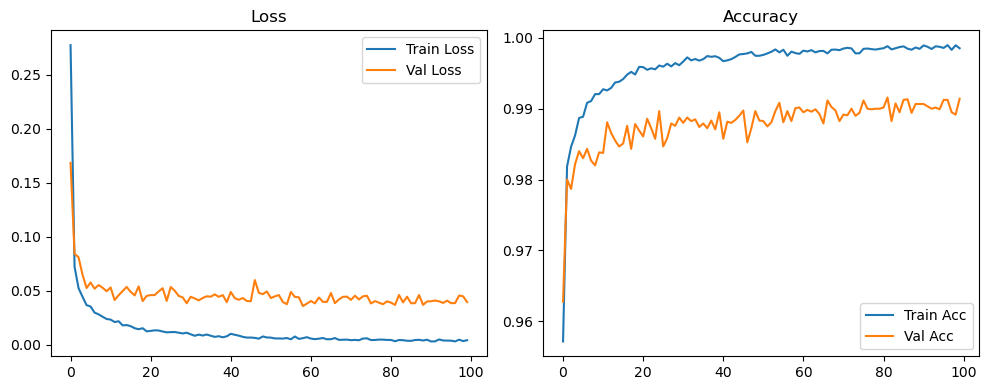

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4208, Acc: 0.9206 | Val Loss: 1.1731, Acc: 0.5403


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1442, Acc: 0.9637 | Val Loss: 0.7788, Acc: 0.7434


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1154, Acc: 0.9676 | Val Loss: 0.6916, Acc: 0.7556


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1008, Acc: 0.9714 | Val Loss: 0.7100, Acc: 0.7443


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0949, Acc: 0.9730 | Val Loss: 0.4816, Acc: 0.8333


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0871, Acc: 0.9742 | Val Loss: 0.6513, Acc: 0.7744


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0821, Acc: 0.9751 | Val Loss: 0.4142, Acc: 0.8628


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0790, Acc: 0.9767 | Val Loss: 0.4071, Acc: 0.8612


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0752, Acc: 0.9772 | Val Loss: 0.3329, Acc: 0.8805


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9787 | Val Loss: 0.2386, Acc: 0.9238


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9796 | Val Loss: 0.2794, Acc: 0.9064


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9788 | Val Loss: 0.1907, Acc: 0.9380


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0672, Acc: 0.9798 | Val Loss: 0.2159, Acc: 0.9290


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9817 | Val Loss: 0.2517, Acc: 0.9188


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0636, Acc: 0.9807 | Val Loss: 0.2593, Acc: 0.9103


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9824 | Val Loss: 0.2400, Acc: 0.9202


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0599, Acc: 0.9820 | Val Loss: 0.2124, Acc: 0.9284


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9821 | Val Loss: 0.1981, Acc: 0.9335


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9828 | Val Loss: 0.1893, Acc: 0.9338


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9840 | Val Loss: 0.1954, Acc: 0.9327


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9832 | Val Loss: 0.1933, Acc: 0.9345


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0541, Acc: 0.9832 | Val Loss: 0.1635, Acc: 0.9477


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9839 | Val Loss: 0.1405, Acc: 0.9547


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9847 | Val Loss: 0.1227, Acc: 0.9610


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9848 | Val Loss: 0.1371, Acc: 0.9555


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9849 | Val Loss: 0.2622, Acc: 0.9056


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9847 | Val Loss: 0.1413, Acc: 0.9529


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9851 | Val Loss: 0.1653, Acc: 0.9438


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 0.1514, Acc: 0.9473


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9855 | Val Loss: 0.1760, Acc: 0.9413


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9856 | Val Loss: 0.1398, Acc: 0.9543


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.1555, Acc: 0.9497


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9860 | Val Loss: 0.1925, Acc: 0.9364


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9861 | Val Loss: 0.1978, Acc: 0.9357


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9861 | Val Loss: 0.1246, Acc: 0.9597


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.1624, Acc: 0.9450


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1208, Acc: 0.9604


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9867 | Val Loss: 0.2012, Acc: 0.9303


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9867 | Val Loss: 0.1618, Acc: 0.9451


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9872 | Val Loss: 0.1177, Acc: 0.9617


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9865 | Val Loss: 0.1132, Acc: 0.9643


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.1632, Acc: 0.9483


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9868 | Val Loss: 0.1549, Acc: 0.9479


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9880 | Val Loss: 0.1166, Acc: 0.9606


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9880 | Val Loss: 0.1561, Acc: 0.9496


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 0.1587, Acc: 0.9444


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.2140, Acc: 0.9261


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9878 | Val Loss: 0.1204, Acc: 0.9620


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9884 | Val Loss: 0.1552, Acc: 0.9499


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9882 | Val Loss: 0.1034, Acc: 0.9680


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9874 | Val Loss: 0.1156, Acc: 0.9647


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9891 | Val Loss: 0.1441, Acc: 0.9537


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9889 | Val Loss: 0.1913, Acc: 0.9356


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.1496, Acc: 0.9488


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.1528, Acc: 0.9480


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.1250, Acc: 0.9610


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.1729, Acc: 0.9441


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.1536, Acc: 0.9507


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9887 | Val Loss: 0.1460, Acc: 0.9528


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 0.1504, Acc: 0.9492


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.1714, Acc: 0.9437


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.1462, Acc: 0.9537


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.1077, Acc: 0.9690


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.1199, Acc: 0.9612


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.1344, Acc: 0.9567


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.1177, Acc: 0.9612


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.1064, Acc: 0.9694


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.1779, Acc: 0.9379


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1673, Acc: 0.9447


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.1097, Acc: 0.9679


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1385, Acc: 0.9539


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.1245, Acc: 0.9633


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.1465, Acc: 0.9543


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9897 | Val Loss: 0.1303, Acc: 0.9586


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9901 | Val Loss: 0.1048, Acc: 0.9683


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1200, Acc: 0.9613


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.1167, Acc: 0.9611


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.1197, Acc: 0.9617


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.1057, Acc: 0.9695


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.1255, Acc: 0.9606


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.1256, Acc: 0.9627


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.0992, Acc: 0.9705


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.1123, Acc: 0.9657


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.1226, Acc: 0.9620


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.1676, Acc: 0.9450


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.1124, Acc: 0.9658


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9891 | Val Loss: 0.1190, Acc: 0.9603


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.1314, Acc: 0.9566


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.0957, Acc: 0.9708


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.1231, Acc: 0.9610


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.1028, Acc: 0.9688


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.1389, Acc: 0.9544


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1206, Acc: 0.9619


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0868, Acc: 0.9762


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9903 | Val Loss: 0.1030, Acc: 0.9698


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.1130, Acc: 0.9642


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.1109, Acc: 0.9646


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9894 | Val Loss: 0.1459, Acc: 0.9478


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.1093, Acc: 0.9683


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.1271, Acc: 0.9606


Final Test Loss: 0.1202 Accuracy: 0.9616


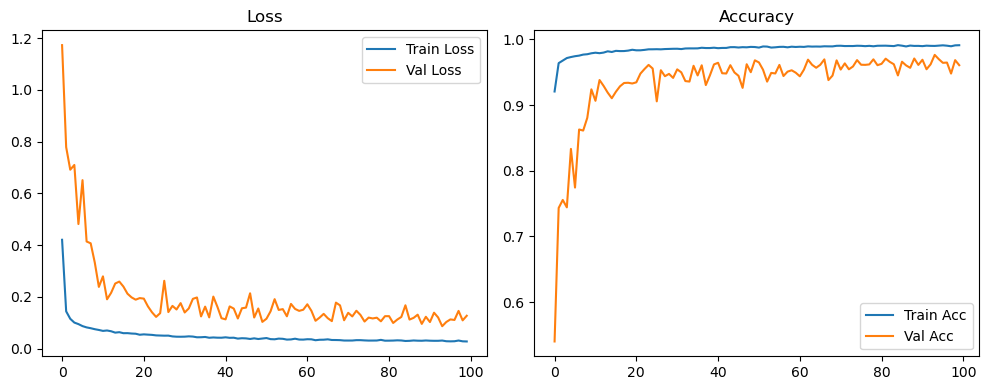

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1534, Acc: 0.9597 | Val Loss: 0.0821, Acc: 0.9754


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.0696, Acc: 0.9782


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.0409, Acc: 0.9883


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.1317, Acc: 0.9609


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0431, Acc: 0.9869


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0550, Acc: 0.9858


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0468, Acc: 0.9873


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.0524, Acc: 0.9864


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0445, Acc: 0.9875


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0575, Acc: 0.9846


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0599, Acc: 0.9865


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0532, Acc: 0.9875


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0501, Acc: 0.9883


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0781, Acc: 0.9827


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0586, Acc: 0.9880


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0638, Acc: 0.9860


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0671, Acc: 0.9869


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0629, Acc: 0.9860


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0579, Acc: 0.9880


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0680, Acc: 0.9857


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0620, Acc: 0.9888


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0811, Acc: 0.9862


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0624, Acc: 0.9888


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0615, Acc: 0.9875


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0657, Acc: 0.9869


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0598, Acc: 0.9882


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0644, Acc: 0.9885


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0704, Acc: 0.9884


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0571, Acc: 0.9903


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0651, Acc: 0.9882


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0754, Acc: 0.9884


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0660, Acc: 0.9887


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0679, Acc: 0.9890


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0674, Acc: 0.9882


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0581, Acc: 0.9889


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0524, Acc: 0.9902


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0606, Acc: 0.9893


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0584, Acc: 0.9888


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0681, Acc: 0.9880


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0695, Acc: 0.9887


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0749, Acc: 0.9886


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0636, Acc: 0.9907


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0832, Acc: 0.9886


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0936, Acc: 0.9876


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0708, Acc: 0.9879


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0766, Acc: 0.9882


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0694, Acc: 0.9890


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0927, Acc: 0.9865


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0728, Acc: 0.9890


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0792, Acc: 0.9888


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0715, Acc: 0.9892


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0735, Acc: 0.9882


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0863, Acc: 0.9892


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0842, Acc: 0.9878


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1099, Acc: 0.9838


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0787, Acc: 0.9900


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0752, Acc: 0.9906


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0937, Acc: 0.9881


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9885


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0769, Acc: 0.9912


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0755, Acc: 0.9908


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0731, Acc: 0.9914


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0821, Acc: 0.9892


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0854, Acc: 0.9886


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0944, Acc: 0.9884


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0824, Acc: 0.9892


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0778, Acc: 0.9898


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0830, Acc: 0.9892


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0849, Acc: 0.9896


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0773, Acc: 0.9902


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0782, Acc: 0.9892


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0790, Acc: 0.9892


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.0808, Acc: 0.9899


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0776, Acc: 0.9897


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0708, Acc: 0.9902


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0704, Acc: 0.9902


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0782, Acc: 0.9907


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0809, Acc: 0.9892


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0754, Acc: 0.9905


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0845, Acc: 0.9898


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0870, Acc: 0.9897


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0902, Acc: 0.9898


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0772, Acc: 0.9901


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0893, Acc: 0.9884


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0913, Acc: 0.9892


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1016, Acc: 0.9888


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0742, Acc: 0.9911


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0874, Acc: 0.9903


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0821, Acc: 0.9898


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0935, Acc: 0.9899


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0839, Acc: 0.9898


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0859, Acc: 0.9898


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0906, Acc: 0.9894


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1020, Acc: 0.9898


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0872, Acc: 0.9890


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0912, Acc: 0.9904


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1057, Acc: 0.9899


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1033, Acc: 0.9888


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1012, Acc: 0.9902


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0902, Acc: 0.9909


Final Test Loss: 0.0843 Accuracy: 0.9897


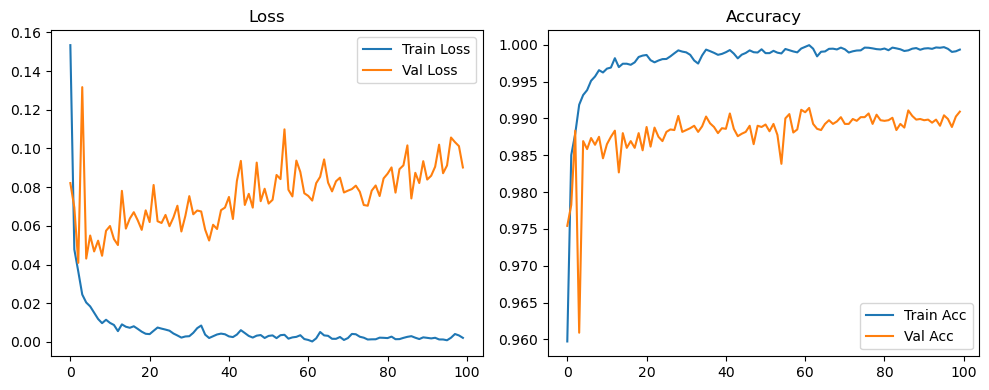

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1797, Acc: 0.9512 | Val Loss: 0.1892, Acc: 0.9387


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9788 | Val Loss: 0.0598, Acc: 0.9821


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.0674, Acc: 0.9792


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9852 | Val Loss: 0.0755, Acc: 0.9782


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.0683, Acc: 0.9782


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9886 | Val Loss: 0.0536, Acc: 0.9831


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.0630, Acc: 0.9802


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0543, Acc: 0.9840


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.0386, Acc: 0.9885


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0793, Acc: 0.9751


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.0507, Acc: 0.9850


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0429, Acc: 0.9878


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0491, Acc: 0.9859


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0529, Acc: 0.9833


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0456, Acc: 0.9872


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0533, Acc: 0.9848


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0491, Acc: 0.9875


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0413, Acc: 0.9888


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0487, Acc: 0.9862


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0509, Acc: 0.9865


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.0487, Acc: 0.9865


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0658, Acc: 0.9838


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0479, Acc: 0.9879


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0492, Acc: 0.9865


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0541, Acc: 0.9863


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0555, Acc: 0.9854


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0525, Acc: 0.9868


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0529, Acc: 0.9882


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0458, Acc: 0.9880


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0509, Acc: 0.9868


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0578, Acc: 0.9862


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0543, Acc: 0.9875


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0502, Acc: 0.9894


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0438, Acc: 0.9894


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9960 | Val Loss: 0.0471, Acc: 0.9878


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0468, Acc: 0.9892


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0457, Acc: 0.9888


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0559, Acc: 0.9871


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0395, Acc: 0.9907


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0448, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0624, Acc: 0.9852


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0503, Acc: 0.9891


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0529, Acc: 0.9880


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0506, Acc: 0.9886


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0552, Acc: 0.9869


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0604, Acc: 0.9867


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0562, Acc: 0.9879


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0502, Acc: 0.9886


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0598, Acc: 0.9862


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0521, Acc: 0.9882


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0548, Acc: 0.9868


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0557, Acc: 0.9859


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0683, Acc: 0.9845


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.0429, Acc: 0.9903


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0521, Acc: 0.9892


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0572, Acc: 0.9882


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0541, Acc: 0.9881


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0529, Acc: 0.9882


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0524, Acc: 0.9890


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0531, Acc: 0.9886


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0525, Acc: 0.9888


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0557, Acc: 0.9890


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0567, Acc: 0.9893


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0551, Acc: 0.9899


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9976 | Val Loss: 0.0579, Acc: 0.9888


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0453, Acc: 0.9910


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0494, Acc: 0.9901


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.0539, Acc: 0.9887


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0551, Acc: 0.9888


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0564, Acc: 0.9884


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0528, Acc: 0.9891


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0504, Acc: 0.9889


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0598, Acc: 0.9892


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0516, Acc: 0.9895


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0575, Acc: 0.9874


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0567, Acc: 0.9875


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0637, Acc: 0.9891


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0532, Acc: 0.9888


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0591, Acc: 0.9888


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0654, Acc: 0.9874


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0585, Acc: 0.9887


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0654, Acc: 0.9869


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0512, Acc: 0.9900


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0548, Acc: 0.9885


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0672, Acc: 0.9870


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0515, Acc: 0.9901


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0579, Acc: 0.9879


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0557, Acc: 0.9899


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.0549, Acc: 0.9888


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0456, Acc: 0.9909


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0630, Acc: 0.9873


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0483, Acc: 0.9893


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0520, Acc: 0.9900


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0619, Acc: 0.9880


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0496, Acc: 0.9903


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0503, Acc: 0.9909


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0593, Acc: 0.9885


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0579, Acc: 0.9888


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0541, Acc: 0.9902


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0507, Acc: 0.9900


Final Test Loss: 0.0471 Accuracy: 0.9905


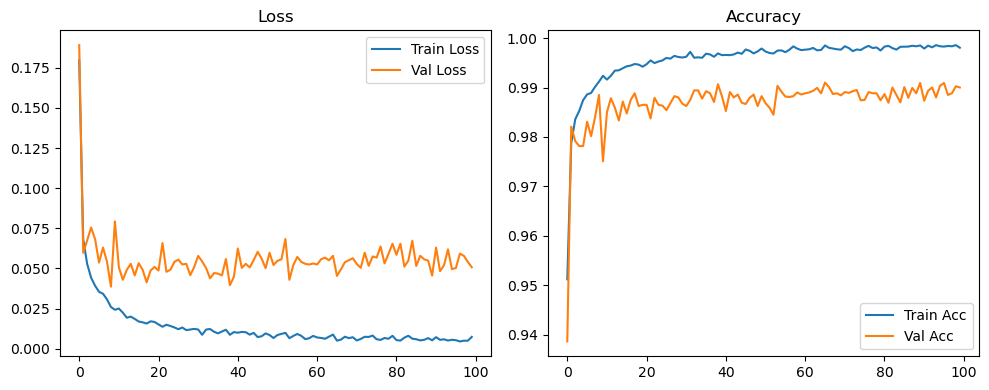

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2743, Acc: 0.9216 | Val Loss: 1.7673, Acc: 0.4749


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9606 | Val Loss: 0.7856, Acc: 0.7261


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9675 | Val Loss: 0.7825, Acc: 0.7218


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9697 | Val Loss: 0.4361, Acc: 0.8462


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9715 | Val Loss: 0.4762, Acc: 0.8327


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9740 | Val Loss: 0.5417, Acc: 0.8207


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9755 | Val Loss: 0.3552, Acc: 0.8756


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9757 | Val Loss: 0.4126, Acc: 0.8555


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9778 | Val Loss: 0.1534, Acc: 0.9494


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9784 | Val Loss: 0.2429, Acc: 0.9147


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.2156, Acc: 0.9258


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9793 | Val Loss: 0.1569, Acc: 0.9503


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9802 | Val Loss: 0.1610, Acc: 0.9464


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9799 | Val Loss: 0.1336, Acc: 0.9579


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9804 | Val Loss: 0.2408, Acc: 0.9153


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9814 | Val Loss: 0.2357, Acc: 0.9196


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9815 | Val Loss: 0.1684, Acc: 0.9440


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9810 | Val Loss: 0.2142, Acc: 0.9243


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9819 | Val Loss: 0.1385, Acc: 0.9533


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9820 | Val Loss: 0.1710, Acc: 0.9407


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9822 | Val Loss: 0.1203, Acc: 0.9579


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9837 | Val Loss: 0.1542, Acc: 0.9483


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9828 | Val Loss: 0.1797, Acc: 0.9388


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.2041, Acc: 0.9272


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9831 | Val Loss: 0.1677, Acc: 0.9397


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 0.1447, Acc: 0.9507


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9849 | Val Loss: 0.2068, Acc: 0.9268


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9848 | Val Loss: 0.1800, Acc: 0.9424


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9841 | Val Loss: 0.1860, Acc: 0.9367


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.1613, Acc: 0.9448


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9845 | Val Loss: 0.1484, Acc: 0.9463


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.2596, Acc: 0.9084


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9853 | Val Loss: 0.1743, Acc: 0.9404


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 0.1076, Acc: 0.9639


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9855 | Val Loss: 0.1330, Acc: 0.9537


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.1453, Acc: 0.9496


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9857 | Val Loss: 0.1133, Acc: 0.9613


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9847 | Val Loss: 0.1579, Acc: 0.9466


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9865 | Val Loss: 0.0891, Acc: 0.9711


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 0.1424, Acc: 0.9532


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9875 | Val Loss: 0.0971, Acc: 0.9683


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9866 | Val Loss: 0.1314, Acc: 0.9553


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9859 | Val Loss: 0.1576, Acc: 0.9467


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9859 | Val Loss: 0.1364, Acc: 0.9542


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9870 | Val Loss: 0.1121, Acc: 0.9623


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9876 | Val Loss: 0.1332, Acc: 0.9542


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.1233, Acc: 0.9608


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.1299, Acc: 0.9553


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 0.1727, Acc: 0.9408


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9880 | Val Loss: 0.1178, Acc: 0.9594


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.1107, Acc: 0.9609


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.1967, Acc: 0.9311


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9870 | Val Loss: 0.1597, Acc: 0.9453


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.1063, Acc: 0.9653


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.1546, Acc: 0.9479


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.1170, Acc: 0.9617


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.0888, Acc: 0.9705


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.1015, Acc: 0.9653


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9886 | Val Loss: 0.1375, Acc: 0.9543


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1301, Acc: 0.9557


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9883 | Val Loss: 0.1099, Acc: 0.9663


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.0993, Acc: 0.9685


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.1064, Acc: 0.9644


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9884 | Val Loss: 0.1145, Acc: 0.9623


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.0958, Acc: 0.9673


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9892 | Val Loss: 0.1201, Acc: 0.9603


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.0871, Acc: 0.9720


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0897, Acc: 0.9707


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9882 | Val Loss: 0.1293, Acc: 0.9547


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1116, Acc: 0.9604


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.1035, Acc: 0.9629


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9892 | Val Loss: 0.0947, Acc: 0.9680


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9896 | Val Loss: 0.0711, Acc: 0.9783


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9895 | Val Loss: 0.0883, Acc: 0.9714


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.0886, Acc: 0.9700


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.0855, Acc: 0.9710


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0792, Acc: 0.9737


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.0802, Acc: 0.9734


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0817, Acc: 0.9719


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.0648, Acc: 0.9789


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.0948, Acc: 0.9707


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.1123, Acc: 0.9614


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9898 | Val Loss: 0.0766, Acc: 0.9739


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0803, Acc: 0.9742


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.0825, Acc: 0.9756


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.1483, Acc: 0.9473


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.1009, Acc: 0.9646


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.0970, Acc: 0.9667


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0777, Acc: 0.9758


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0818, Acc: 0.9723


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9903 | Val Loss: 0.0775, Acc: 0.9740


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.0696, Acc: 0.9777


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.0701, Acc: 0.9762


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9891 | Val Loss: 0.0817, Acc: 0.9720


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.0666, Acc: 0.9788


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9904 | Val Loss: 0.0826, Acc: 0.9717


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.0706, Acc: 0.9767


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9900 | Val Loss: 0.0683, Acc: 0.9773


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0756, Acc: 0.9757


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0653, Acc: 0.9802


Final Test Loss: 0.0632 Accuracy: 0.9812


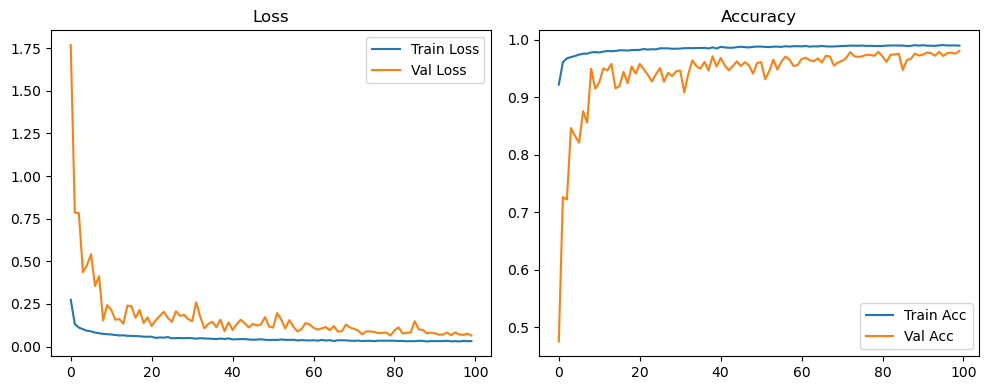

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1534, Acc: 0.9597 | Val Loss: 0.0821, Acc: 0.9754


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.0696, Acc: 0.9782


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0483, Acc: 0.9856


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0493, Acc: 0.9853


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0648, Acc: 0.9812


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9934 | Val Loss: 0.0370, Acc: 0.9889


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.0401, Acc: 0.9888


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9956 | Val Loss: 0.0505, Acc: 0.9877


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.0406, Acc: 0.9898


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0632, Acc: 0.9848


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0689, Acc: 0.9835


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9962 | Val Loss: 0.0589, Acc: 0.9870


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0537, Acc: 0.9857


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0478, Acc: 0.9892


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0472, Acc: 0.9892


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0949, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0480, Acc: 0.9895


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0492, Acc: 0.9888


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0650, Acc: 0.9862


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0537, Acc: 0.9891


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0661, Acc: 0.9875


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0692, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0556, Acc: 0.9898


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0588, Acc: 0.9892


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0554, Acc: 0.9887


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0663, Acc: 0.9880


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0488, Acc: 0.9907


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0689, Acc: 0.9875


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0591, Acc: 0.9883


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0495, Acc: 0.9902


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0570, Acc: 0.9889


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0544, Acc: 0.9893


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0799, Acc: 0.9864


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0568, Acc: 0.9890


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0676, Acc: 0.9875


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0564, Acc: 0.9893


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0715, Acc: 0.9881


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0651, Acc: 0.9896


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.0719, Acc: 0.9886


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0936, Acc: 0.9847


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0801, Acc: 0.9880


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0700, Acc: 0.9886


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0663, Acc: 0.9889


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0733, Acc: 0.9883


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0589, Acc: 0.9903


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0658, Acc: 0.9900


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0708, Acc: 0.9893


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0713, Acc: 0.9888


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0679, Acc: 0.9902


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0887, Acc: 0.9879


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.0629, Acc: 0.9908


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9905


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0666, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0638, Acc: 0.9899


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0593, Acc: 0.9915


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9911


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9918


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0589, Acc: 0.9910


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9918


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9910


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9914


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0644, Acc: 0.9902


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0614, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0625, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0780, Acc: 0.9894


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0695, Acc: 0.9899


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0646, Acc: 0.9918


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0659, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0705, Acc: 0.9910


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0661, Acc: 0.9911


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0734, Acc: 0.9903


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0635, Acc: 0.9916


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0837, Acc: 0.9897


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0794, Acc: 0.9896


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0746, Acc: 0.9900


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0703, Acc: 0.9917


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0700, Acc: 0.9909


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0630, Acc: 0.9905


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0817, Acc: 0.9908


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0818, Acc: 0.9899


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0728, Acc: 0.9912


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9920


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0703, Acc: 0.9912


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0678, Acc: 0.9917


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0682, Acc: 0.9923


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0673, Acc: 0.9919


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0698, Acc: 0.9916


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0656, Acc: 0.9918


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9923


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9921


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9924


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9922


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9926


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9926


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9923


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9920


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9922


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9925


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9926


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9922


Final Test Loss: 0.0578 Accuracy: 0.9911


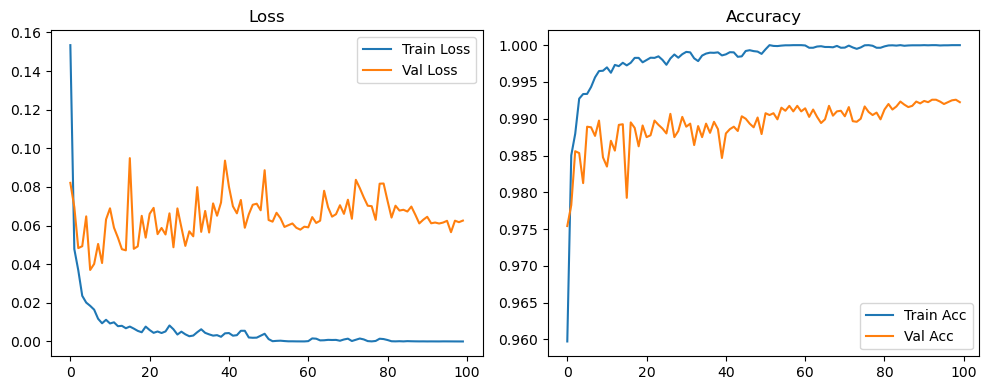

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1797, Acc: 0.9512 | Val Loss: 0.1892, Acc: 0.9387


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9785 | Val Loss: 0.0742, Acc: 0.9771


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9827 | Val Loss: 0.0804, Acc: 0.9742


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.0524, Acc: 0.9847


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.0638, Acc: 0.9798


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9884 | Val Loss: 0.0495, Acc: 0.9844


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.0501, Acc: 0.9835


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.0540, Acc: 0.9832


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0394, Acc: 0.9868


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0503, Acc: 0.9855


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.0425, Acc: 0.9861


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0541, Acc: 0.9847


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0539, Acc: 0.9858


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.0470, Acc: 0.9859


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.0424, Acc: 0.9883


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.0472, Acc: 0.9863


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0469, Acc: 0.9860


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0409, Acc: 0.9888


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.0409, Acc: 0.9880


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9943 | Val Loss: 0.0450, Acc: 0.9879


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0598, Acc: 0.9819


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0385, Acc: 0.9898


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0393, Acc: 0.9895


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.0450, Acc: 0.9887


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0443, Acc: 0.9886


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.0460, Acc: 0.9873


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0480, Acc: 0.9867


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0548, Acc: 0.9869


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0454, Acc: 0.9888


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0403, Acc: 0.9891


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0501, Acc: 0.9890


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0424, Acc: 0.9897


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0418, Acc: 0.9899


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0469, Acc: 0.9895


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0443, Acc: 0.9891


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9967 | Val Loss: 0.0505, Acc: 0.9877


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0435, Acc: 0.9895


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0398, Acc: 0.9902


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0494, Acc: 0.9863


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0460, Acc: 0.9892


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0402, Acc: 0.9904


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0494, Acc: 0.9901


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0590, Acc: 0.9862


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0448, Acc: 0.9892


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0439, Acc: 0.9906


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0415, Acc: 0.9902


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0483, Acc: 0.9893


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0450, Acc: 0.9901


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0499, Acc: 0.9894


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0421, Acc: 0.9911


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0444, Acc: 0.9912


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0441, Acc: 0.9905


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0445, Acc: 0.9911


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0457, Acc: 0.9892


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0431, Acc: 0.9912


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0444, Acc: 0.9907


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0439, Acc: 0.9911


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0421, Acc: 0.9914


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0424, Acc: 0.9912


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0462, Acc: 0.9908


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0432, Acc: 0.9903


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0447, Acc: 0.9909


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0427, Acc: 0.9908


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0396, Acc: 0.9919


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0415, Acc: 0.9912


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0461, Acc: 0.9910


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0458, Acc: 0.9904


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0415, Acc: 0.9918


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0474, Acc: 0.9911


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0408, Acc: 0.9920


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0494, Acc: 0.9900


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0408, Acc: 0.9921


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0461, Acc: 0.9908


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0422, Acc: 0.9920


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0475, Acc: 0.9908


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0475, Acc: 0.9902


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0423, Acc: 0.9921


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0400, Acc: 0.9922


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0399, Acc: 0.9928


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0471, Acc: 0.9915


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0436, Acc: 0.9918


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0435, Acc: 0.9927


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0448, Acc: 0.9918


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0417, Acc: 0.9916


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0412, Acc: 0.9925


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0420, Acc: 0.9919


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0392, Acc: 0.9918


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0399, Acc: 0.9927


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0450, Acc: 0.9917


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0441, Acc: 0.9914


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0439, Acc: 0.9914


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0445, Acc: 0.9913


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0403, Acc: 0.9924


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0414, Acc: 0.9914


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0411, Acc: 0.9922


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0444, Acc: 0.9923


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0411, Acc: 0.9931


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0376, Acc: 0.9930


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0426, Acc: 0.9918


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0409, Acc: 0.9925


Final Test Loss: 0.0421 Accuracy: 0.9914


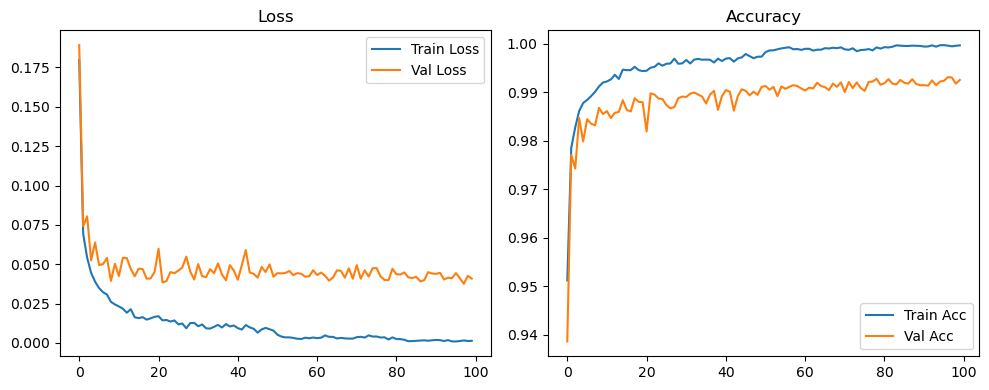

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2743, Acc: 0.9216 | Val Loss: 1.7673, Acc: 0.4749


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9606 | Val Loss: 0.7856, Acc: 0.7261


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1118, Acc: 0.9672 | Val Loss: 0.5626, Acc: 0.7975


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1031, Acc: 0.9699 | Val Loss: 0.6675, Acc: 0.7656


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9722 | Val Loss: 0.6515, Acc: 0.7742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9739 | Val Loss: 0.5983, Acc: 0.7894


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9752 | Val Loss: 0.3354, Acc: 0.8825


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9759 | Val Loss: 0.2859, Acc: 0.9062


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9782 | Val Loss: 0.2232, Acc: 0.9232


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9783 | Val Loss: 0.2672, Acc: 0.9105


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9790 | Val Loss: 0.1857, Acc: 0.9379


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9790 | Val Loss: 0.1402, Acc: 0.9590


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9802 | Val Loss: 0.1503, Acc: 0.9503


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9799 | Val Loss: 0.1850, Acc: 0.9383


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9807 | Val Loss: 0.2665, Acc: 0.9113


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9815 | Val Loss: 0.2389, Acc: 0.9181


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9808 | Val Loss: 0.2711, Acc: 0.9068


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9820 | Val Loss: 0.1473, Acc: 0.9513


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9818 | Val Loss: 0.1631, Acc: 0.9443


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9830 | Val Loss: 0.2471, Acc: 0.9142


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9821 | Val Loss: 0.1392, Acc: 0.9537


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9837 | Val Loss: 0.1645, Acc: 0.9447


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9829 | Val Loss: 0.2080, Acc: 0.9262


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9835 | Val Loss: 0.3057, Acc: 0.8911


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9841 | Val Loss: 0.1851, Acc: 0.9391


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9842 | Val Loss: 0.1675, Acc: 0.9422


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.1515, Acc: 0.9511


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 0.1465, Acc: 0.9529


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 0.1951, Acc: 0.9357


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9844 | Val Loss: 0.1275, Acc: 0.9573


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9848 | Val Loss: 0.1673, Acc: 0.9403


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9855 | Val Loss: 0.1178, Acc: 0.9600


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9850 | Val Loss: 0.1888, Acc: 0.9374


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9854 | Val Loss: 0.1220, Acc: 0.9585


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.1218, Acc: 0.9595


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9853 | Val Loss: 0.1145, Acc: 0.9633


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9861 | Val Loss: 0.1021, Acc: 0.9670


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9859 | Val Loss: 0.1902, Acc: 0.9347


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9867 | Val Loss: 0.1821, Acc: 0.9371


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9852 | Val Loss: 0.1106, Acc: 0.9645


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 0.1508, Acc: 0.9482


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.2095, Acc: 0.9303


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9871 | Val Loss: 0.1258, Acc: 0.9575


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.1370, Acc: 0.9543


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.1064, Acc: 0.9619


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.1310, Acc: 0.9590


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9869 | Val Loss: 0.1509, Acc: 0.9489


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.1580, Acc: 0.9452


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9871 | Val Loss: 0.1324, Acc: 0.9573


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.0798, Acc: 0.9725


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.1265, Acc: 0.9570


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9898 | Val Loss: 0.1434, Acc: 0.9516


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.1145, Acc: 0.9629


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.1059, Acc: 0.9662


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.0958, Acc: 0.9677


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9904 | Val Loss: 0.1013, Acc: 0.9685


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.1186, Acc: 0.9619


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.1154, Acc: 0.9605


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.0751, Acc: 0.9769


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.1083, Acc: 0.9637


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.0921, Acc: 0.9694


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0851, Acc: 0.9732


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.1021, Acc: 0.9688


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 0.0846, Acc: 0.9728


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.1333, Acc: 0.9574


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1203, Acc: 0.9587


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0813, Acc: 0.9753


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.1147, Acc: 0.9611


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.1216, Acc: 0.9600


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0888, Acc: 0.9706


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9920 | Val Loss: 0.0981, Acc: 0.9683


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1028, Acc: 0.9671


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9905 | Val Loss: 0.1098, Acc: 0.9637


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.0873, Acc: 0.9722


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.0818, Acc: 0.9735


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9914 | Val Loss: 0.0835, Acc: 0.9722


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0785, Acc: 0.9742


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.0918, Acc: 0.9700


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0635, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.0922, Acc: 0.9696


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.0833, Acc: 0.9721


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0674, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0813, Acc: 0.9749


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0685, Acc: 0.9770


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.0758, Acc: 0.9750


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.0972, Acc: 0.9666


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0765, Acc: 0.9754


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9931 | Val Loss: 0.0772, Acc: 0.9743


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0610, Acc: 0.9809


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0639, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0832, Acc: 0.9738


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0807, Acc: 0.9733


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9930 | Val Loss: 0.0762, Acc: 0.9762


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0750, Acc: 0.9772


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9931 | Val Loss: 0.0861, Acc: 0.9706


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0801, Acc: 0.9732


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0637, Acc: 0.9793


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0751, Acc: 0.9763


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0610, Acc: 0.9802


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0621, Acc: 0.9804


Final Test Loss: 0.0607 Accuracy: 0.9807


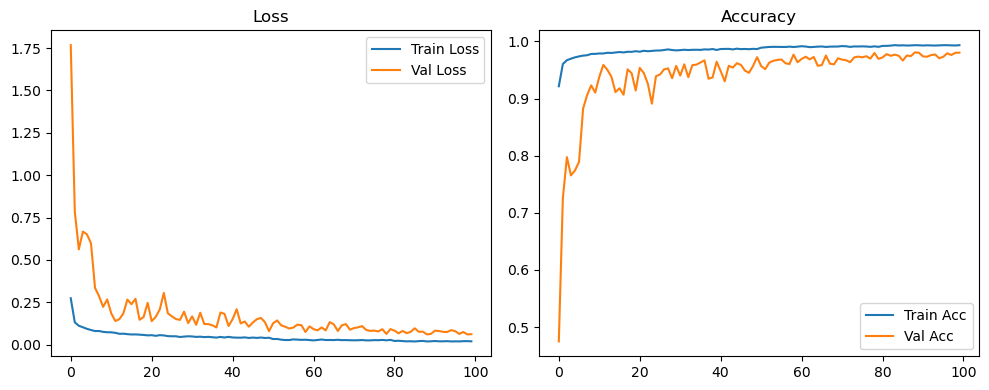

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1534, Acc: 0.9597 | Val Loss: 0.0821, Acc: 0.9754


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.0696, Acc: 0.9782


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.0409, Acc: 0.9883


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.1317, Acc: 0.9609


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0452, Acc: 0.9868


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.0497, Acc: 0.9870


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9945 | Val Loss: 0.0481, Acc: 0.9872


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.0431, Acc: 0.9893


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0574, Acc: 0.9855


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0607, Acc: 0.9852


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0648, Acc: 0.9842


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0530, Acc: 0.9889


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0704, Acc: 0.9848


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0584, Acc: 0.9882


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0597, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0579, Acc: 0.9881


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0511, Acc: 0.9905


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0516, Acc: 0.9888


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0689, Acc: 0.9871


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0659, Acc: 0.9878


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0626, Acc: 0.9886


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0596, Acc: 0.9887


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0566, Acc: 0.9883


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0678, Acc: 0.9879


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0573, Acc: 0.9893


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0587, Acc: 0.9896


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0680, Acc: 0.9873


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0754, Acc: 0.9868


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0844, Acc: 0.9857


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0691, Acc: 0.9862


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0593, Acc: 0.9893


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0660, Acc: 0.9885


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0617, Acc: 0.9899


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0623, Acc: 0.9891


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0568, Acc: 0.9901


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0661, Acc: 0.9902


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0696, Acc: 0.9891


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0721, Acc: 0.9888


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0806, Acc: 0.9883


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0747, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0848, Acc: 0.9869


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0683, Acc: 0.9901


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0728, Acc: 0.9863


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0767, Acc: 0.9892


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0609, Acc: 0.9912


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0559, Acc: 0.9902


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0552, Acc: 0.9922


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0668, Acc: 0.9907


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0671, Acc: 0.9893


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0618, Acc: 0.9908


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0549, Acc: 0.9902


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0573, Acc: 0.9910


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0618, Acc: 0.9914


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0580, Acc: 0.9914


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9913


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0576, Acc: 0.9921


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9917


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9918


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0754, Acc: 0.9908


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0572, Acc: 0.9920


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0671, Acc: 0.9908


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0803, Acc: 0.9896


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0666, Acc: 0.9904


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0630, Acc: 0.9907


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0683, Acc: 0.9895


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0721, Acc: 0.9910


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0681, Acc: 0.9910


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9912


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0691, Acc: 0.9910


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0697, Acc: 0.9908


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0708, Acc: 0.9899


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0725, Acc: 0.9898


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0746, Acc: 0.9907


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0702, Acc: 0.9901


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0727, Acc: 0.9904


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0718, Acc: 0.9900


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0729, Acc: 0.9911


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0722, Acc: 0.9903


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0744, Acc: 0.9903


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0738, Acc: 0.9895


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0651, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0642, Acc: 0.9908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9917


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9920


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9918


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0638, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9912


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9916


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9922


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9919


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9915


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9926


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0654, Acc: 0.9919


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0654, Acc: 0.9918


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9919


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0701, Acc: 0.9912


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9920


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9922


Final Test Loss: 0.0559 Accuracy: 0.9915


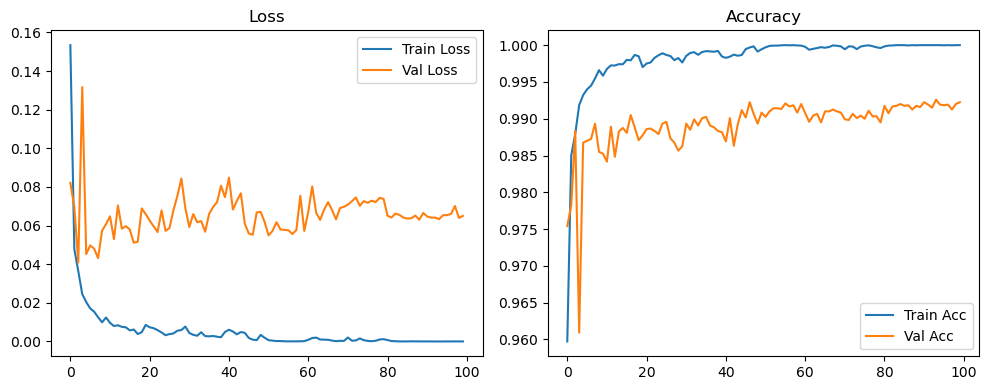

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1797, Acc: 0.9512 | Val Loss: 0.1892, Acc: 0.9387


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9788 | Val Loss: 0.0598, Acc: 0.9821


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.0674, Acc: 0.9792


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9852 | Val Loss: 0.0755, Acc: 0.9782


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0480, Acc: 0.9848


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0497, Acc: 0.9832


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9891 | Val Loss: 0.0482, Acc: 0.9853


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.0423, Acc: 0.9874


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0354, Acc: 0.9894


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0462, Acc: 0.9858


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0476, Acc: 0.9853


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0571, Acc: 0.9832


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0739, Acc: 0.9789


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0478, Acc: 0.9865


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0466, Acc: 0.9876


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0935, Acc: 0.9749


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9943 | Val Loss: 0.0515, Acc: 0.9858


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0385, Acc: 0.9891


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.0430, Acc: 0.9888


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0457, Acc: 0.9873


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0432, Acc: 0.9886


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0448, Acc: 0.9882


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0538, Acc: 0.9862


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9952 | Val Loss: 0.0674, Acc: 0.9840


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9951 | Val Loss: 0.0482, Acc: 0.9873


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0495, Acc: 0.9868


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0400, Acc: 0.9887


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0478, Acc: 0.9876


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0521, Acc: 0.9867


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0440, Acc: 0.9887


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.0416, Acc: 0.9888


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9956 | Val Loss: 0.0558, Acc: 0.9875


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0610, Acc: 0.9842


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0447, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0445, Acc: 0.9888


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0427, Acc: 0.9885


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0393, Acc: 0.9901


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0457, Acc: 0.9886


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0456, Acc: 0.9886


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0452, Acc: 0.9889


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0519, Acc: 0.9886


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0527, Acc: 0.9878


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0516, Acc: 0.9888


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0514, Acc: 0.9887


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0503, Acc: 0.9885


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0522, Acc: 0.9881


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0474, Acc: 0.9897


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0493, Acc: 0.9899


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0514, Acc: 0.9892


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0435, Acc: 0.9908


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0461, Acc: 0.9903


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0456, Acc: 0.9904


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0427, Acc: 0.9914


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0452, Acc: 0.9900


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0484, Acc: 0.9898


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0464, Acc: 0.9898


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0500, Acc: 0.9902


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0453, Acc: 0.9902


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0420, Acc: 0.9920


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0460, Acc: 0.9910


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0486, Acc: 0.9910


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0464, Acc: 0.9915


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0491, Acc: 0.9903


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0492, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0465, Acc: 0.9912


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0478, Acc: 0.9901


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0526, Acc: 0.9901


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0496, Acc: 0.9906


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0483, Acc: 0.9892


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0446, Acc: 0.9908


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0457, Acc: 0.9911


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0489, Acc: 0.9900


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0523, Acc: 0.9909


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0578, Acc: 0.9882


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0529, Acc: 0.9908


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0527, Acc: 0.9911


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0542, Acc: 0.9902


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0539, Acc: 0.9896


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0541, Acc: 0.9896


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0534, Acc: 0.9898


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0496, Acc: 0.9900


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0483, Acc: 0.9910


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0491, Acc: 0.9906


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0473, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0490, Acc: 0.9911


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0486, Acc: 0.9910


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0489, Acc: 0.9912


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0467, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0465, Acc: 0.9916


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0493, Acc: 0.9911


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0532, Acc: 0.9908


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0451, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0474, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0467, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0498, Acc: 0.9915


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.0480, Acc: 0.9918


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0524, Acc: 0.9913


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0513, Acc: 0.9913


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0467, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0493, Acc: 0.9918


Final Test Loss: 0.0463 Accuracy: 0.9904


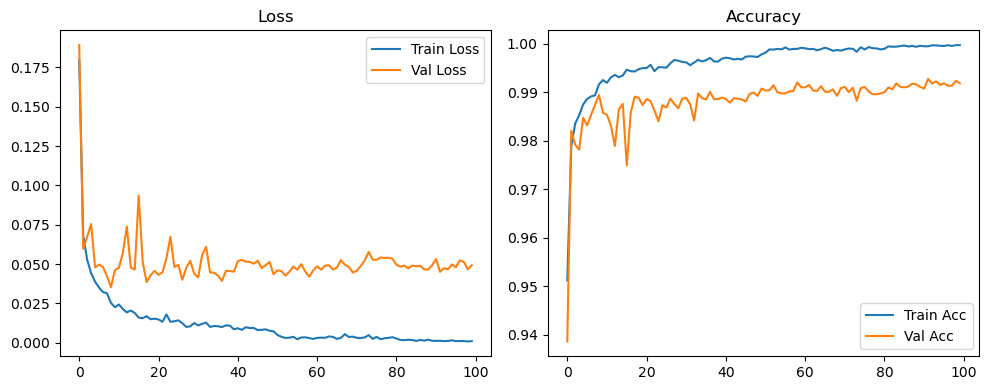

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2743, Acc: 0.9216 | Val Loss: 1.7673, Acc: 0.4749


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9606 | Val Loss: 0.7856, Acc: 0.7261


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1116, Acc: 0.9675 | Val Loss: 0.7312, Acc: 0.7312


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1002, Acc: 0.9699 | Val Loss: 0.6983, Acc: 0.7589


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9719 | Val Loss: 0.4356, Acc: 0.8446


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9742 | Val Loss: 0.6611, Acc: 0.7730


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9744 | Val Loss: 0.3222, Acc: 0.8843


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9760 | Val Loss: 0.3271, Acc: 0.8872


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9779 | Val Loss: 0.1993, Acc: 0.9340


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9780 | Val Loss: 0.2843, Acc: 0.9040


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9786 | Val Loss: 0.2940, Acc: 0.8974


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9786 | Val Loss: 0.2142, Acc: 0.9267


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9800 | Val Loss: 0.2954, Acc: 0.8935


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9798 | Val Loss: 0.2450, Acc: 0.9153


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9812 | Val Loss: 0.2702, Acc: 0.9063


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9828 | Val Loss: 0.1814, Acc: 0.9407


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9818 | Val Loss: 0.2192, Acc: 0.9266


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9817 | Val Loss: 0.1694, Acc: 0.9438


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9818 | Val Loss: 0.1653, Acc: 0.9442


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9822 | Val Loss: 0.1243, Acc: 0.9593


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9825 | Val Loss: 0.1311, Acc: 0.9552


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9832 | Val Loss: 0.2226, Acc: 0.9251


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9826 | Val Loss: 0.2252, Acc: 0.9230


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 0.1701, Acc: 0.9414


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9836 | Val Loss: 0.1808, Acc: 0.9367


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9839 | Val Loss: 0.1414, Acc: 0.9518


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9845 | Val Loss: 0.2667, Acc: 0.9047


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9854 | Val Loss: 0.1392, Acc: 0.9550


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9852 | Val Loss: 0.2161, Acc: 0.9250


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9846 | Val Loss: 0.1081, Acc: 0.9653


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9856 | Val Loss: 0.1326, Acc: 0.9577


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9842 | Val Loss: 0.1457, Acc: 0.9503


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9854 | Val Loss: 0.1456, Acc: 0.9505


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9850 | Val Loss: 0.1017, Acc: 0.9673


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9848 | Val Loss: 0.1204, Acc: 0.9597


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9858 | Val Loss: 0.1370, Acc: 0.9541


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1540, Acc: 0.9489


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9861 | Val Loss: 0.2212, Acc: 0.9225


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9860 | Val Loss: 0.1273, Acc: 0.9583


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9863 | Val Loss: 0.1955, Acc: 0.9313


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9865 | Val Loss: 0.1532, Acc: 0.9469


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9863 | Val Loss: 0.1875, Acc: 0.9348


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9866 | Val Loss: 0.1457, Acc: 0.9507


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9864 | Val Loss: 0.1284, Acc: 0.9571


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9876 | Val Loss: 0.0950, Acc: 0.9688


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9872 | Val Loss: 0.1102, Acc: 0.9621


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.1377, Acc: 0.9543


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9877 | Val Loss: 0.1020, Acc: 0.9647


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9862 | Val Loss: 0.1307, Acc: 0.9531


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.1385, Acc: 0.9523


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9889 | Val Loss: 0.1039, Acc: 0.9633


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1454, Acc: 0.9500


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.1185, Acc: 0.9595


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.1207, Acc: 0.9587


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.1138, Acc: 0.9605


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.0827, Acc: 0.9726


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.1075, Acc: 0.9623


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.1280, Acc: 0.9568


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.1353, Acc: 0.9547


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.1212, Acc: 0.9583


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.1087, Acc: 0.9634


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9917 | Val Loss: 0.0870, Acc: 0.9714


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0884, Acc: 0.9703


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0864, Acc: 0.9722


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.1036, Acc: 0.9647


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.1117, Acc: 0.9626


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0898, Acc: 0.9712


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0881, Acc: 0.9721


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9901 | Val Loss: 0.1099, Acc: 0.9625


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9912 | Val Loss: 0.0886, Acc: 0.9707


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.0876, Acc: 0.9718


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0696, Acc: 0.9779


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0950, Acc: 0.9680


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.1290, Acc: 0.9565


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0796, Acc: 0.9750


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.0913, Acc: 0.9700


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.0865, Acc: 0.9728


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0909, Acc: 0.9693


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9909 | Val Loss: 0.0840, Acc: 0.9718


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9916 | Val Loss: 0.1008, Acc: 0.9675


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0772, Acc: 0.9749


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9923 | Val Loss: 0.0808, Acc: 0.9726


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0765, Acc: 0.9749


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0782, Acc: 0.9747


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0885, Acc: 0.9713


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.1000, Acc: 0.9667


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.0746, Acc: 0.9757


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.0718, Acc: 0.9757


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9933 | Val Loss: 0.0725, Acc: 0.9762


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9934 | Val Loss: 0.0735, Acc: 0.9758


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0638, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0724, Acc: 0.9767


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9939 | Val Loss: 0.0759, Acc: 0.9753


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.0880, Acc: 0.9707


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0781, Acc: 0.9743


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9943 | Val Loss: 0.0790, Acc: 0.9724


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0695, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0726, Acc: 0.9776


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.0719, Acc: 0.9762


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9939 | Val Loss: 0.0671, Acc: 0.9788


Final Test Loss: 0.0661 Accuracy: 0.9792


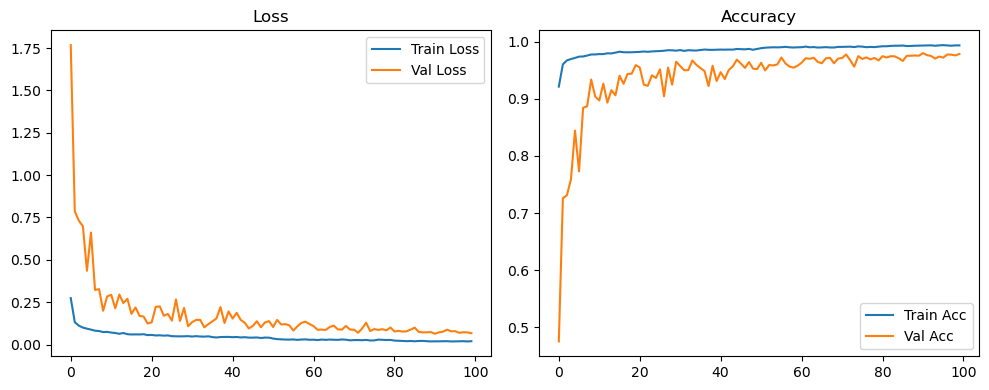

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1534, Acc: 0.9597 | Val Loss: 0.0821, Acc: 0.9754


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.0696, Acc: 0.9782


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.0530, Acc: 0.9838


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0516, Acc: 0.9848


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9926 | Val Loss: 0.0461, Acc: 0.9868


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9934 | Val Loss: 0.0575, Acc: 0.9838


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.0413, Acc: 0.9890


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0472, Acc: 0.9871


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9962 | Val Loss: 0.0508, Acc: 0.9878


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0496, Acc: 0.9884


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0586, Acc: 0.9864


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.0566, Acc: 0.9862


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0473, Acc: 0.9880


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0526, Acc: 0.9890


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0617, Acc: 0.9851


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0473, Acc: 0.9891


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0585, Acc: 0.9878


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0540, Acc: 0.9881


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0605, Acc: 0.9879


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0620, Acc: 0.9870


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0524, Acc: 0.9886


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0621, Acc: 0.9882


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0478, Acc: 0.9912


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0497, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0449, Acc: 0.9913


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0784, Acc: 0.9857


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0630, Acc: 0.9879


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0690, Acc: 0.9878


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0635, Acc: 0.9884


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0537, Acc: 0.9898


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0621, Acc: 0.9884


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0644, Acc: 0.9892


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0618, Acc: 0.9881


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0731, Acc: 0.9875


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0775, Acc: 0.9875


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0683, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0722, Acc: 0.9877


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0654, Acc: 0.9890


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0689, Acc: 0.9891


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0616, Acc: 0.9892


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0547, Acc: 0.9893


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0686, Acc: 0.9887


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0679, Acc: 0.9890


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.0689, Acc: 0.9892


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0655, Acc: 0.9893


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0741, Acc: 0.9876


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0600, Acc: 0.9899


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0644, Acc: 0.9898


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0891, Acc: 0.9877


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0763, Acc: 0.9882


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0578, Acc: 0.9906


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0557, Acc: 0.9910


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9916


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0548, Acc: 0.9918


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0511, Acc: 0.9918


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9915


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9917


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9912


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9930


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9922


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9926


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9930


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9921


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9923


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9925


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9928


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9922


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9918


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9920


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0479, Acc: 0.9919


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0540, Acc: 0.9923


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9916


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9925


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9928


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9922


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9919


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0554, Acc: 0.9923


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9922


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9928


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9923


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9925


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9927


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9921


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9923


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9929


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9923


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9928


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9928


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9926


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9930


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9932


Final Test Loss: 0.0536 Accuracy: 0.9916


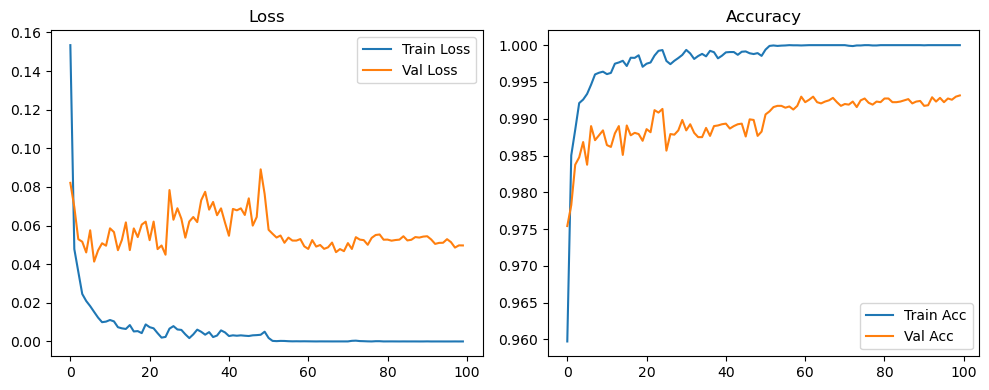

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1797, Acc: 0.9512 | Val Loss: 0.1892, Acc: 0.9387


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9788 | Val Loss: 0.0598, Acc: 0.9821


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.0674, Acc: 0.9792


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9852 | Val Loss: 0.0755, Acc: 0.9782


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0509, Acc: 0.9836


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9877 | Val Loss: 0.0512, Acc: 0.9836


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.0400, Acc: 0.9886


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.0583, Acc: 0.9818


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0354, Acc: 0.9895


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0535, Acc: 0.9839


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.0428, Acc: 0.9862


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0420, Acc: 0.9879


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9923 | Val Loss: 0.0486, Acc: 0.9842


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0424, Acc: 0.9868


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0619, Acc: 0.9805


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.0584, Acc: 0.9827


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.0529, Acc: 0.9850


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0520, Acc: 0.9854


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0446, Acc: 0.9883


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0511, Acc: 0.9860


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0619, Acc: 0.9836


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0448, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.0462, Acc: 0.9882


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0602, Acc: 0.9843


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0435, Acc: 0.9882


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0580, Acc: 0.9852


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0601, Acc: 0.9844


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0552, Acc: 0.9864


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0592, Acc: 0.9853


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0494, Acc: 0.9879


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0461, Acc: 0.9897


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0466, Acc: 0.9883


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0490, Acc: 0.9882


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0478, Acc: 0.9891


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0437, Acc: 0.9902


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0433, Acc: 0.9899


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0467, Acc: 0.9879


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0675, Acc: 0.9832


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0454, Acc: 0.9883


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0450, Acc: 0.9885


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0459, Acc: 0.9898


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0503, Acc: 0.9877


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0560, Acc: 0.9879


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0599, Acc: 0.9866


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0503, Acc: 0.9880


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0605, Acc: 0.9857


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0505, Acc: 0.9888


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0480, Acc: 0.9898


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0497, Acc: 0.9892


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0585, Acc: 0.9872


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0486, Acc: 0.9894


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0500, Acc: 0.9896


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0438, Acc: 0.9904


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0472, Acc: 0.9904


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0423, Acc: 0.9916


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0465, Acc: 0.9902


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0439, Acc: 0.9915


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0485, Acc: 0.9903


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0445, Acc: 0.9908


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0470, Acc: 0.9898


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0497, Acc: 0.9894


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0445, Acc: 0.9897


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0452, Acc: 0.9908


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0394, Acc: 0.9921


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0449, Acc: 0.9907


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0447, Acc: 0.9917


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0403, Acc: 0.9912


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0489, Acc: 0.9902


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0476, Acc: 0.9901


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0437, Acc: 0.9920


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0495, Acc: 0.9901


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0480, Acc: 0.9904


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0515, Acc: 0.9905


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0478, Acc: 0.9900


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0522, Acc: 0.9897


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0468, Acc: 0.9907


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0481, Acc: 0.9902


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0438, Acc: 0.9917


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0462, Acc: 0.9914


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0576, Acc: 0.9898


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0510, Acc: 0.9911


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0480, Acc: 0.9912


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0539, Acc: 0.9902


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0500, Acc: 0.9908


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0465, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0471, Acc: 0.9911


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0475, Acc: 0.9917


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0513, Acc: 0.9912


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0492, Acc: 0.9911


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0509, Acc: 0.9910


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0523, Acc: 0.9908


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0486, Acc: 0.9903


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0504, Acc: 0.9902


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0478, Acc: 0.9911


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0484, Acc: 0.9908


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0422, Acc: 0.9915


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0469, Acc: 0.9912


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0486, Acc: 0.9904


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0470, Acc: 0.9914


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0451, Acc: 0.9914


Final Test Loss: 0.0456 Accuracy: 0.9906


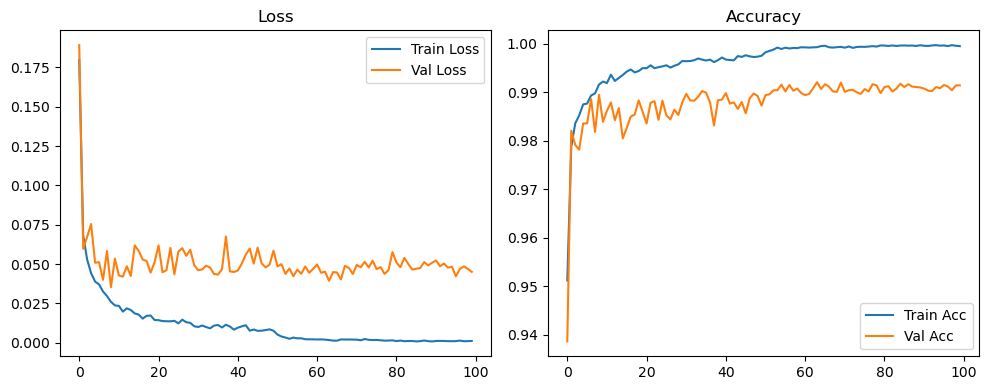

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2743, Acc: 0.9216 | Val Loss: 1.7673, Acc: 0.4749


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9606 | Val Loss: 0.7856, Acc: 0.7261


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1108, Acc: 0.9677 | Val Loss: 0.8916, Acc: 0.6999


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9706 | Val Loss: 0.4036, Acc: 0.8575


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9720 | Val Loss: 0.4272, Acc: 0.8571


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9744 | Val Loss: 0.3561, Acc: 0.8818


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9754 | Val Loss: 0.2640, Acc: 0.9145


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9749 | Val Loss: 0.1932, Acc: 0.9357


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9782 | Val Loss: 0.1883, Acc: 0.9377


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9786 | Val Loss: 0.2785, Acc: 0.9037


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9787 | Val Loss: 0.2677, Acc: 0.9118


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9790 | Val Loss: 0.2473, Acc: 0.9198


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9801 | Val Loss: 0.2093, Acc: 0.9297


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9799 | Val Loss: 0.1679, Acc: 0.9439


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9803 | Val Loss: 0.2539, Acc: 0.9154


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9812 | Val Loss: 0.2431, Acc: 0.9187


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9823 | Val Loss: 0.2469, Acc: 0.9147


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9815 | Val Loss: 0.2457, Acc: 0.9139


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9824 | Val Loss: 0.1724, Acc: 0.9403


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9836 | Val Loss: 0.1369, Acc: 0.9534


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9824 | Val Loss: 0.1512, Acc: 0.9513


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9826 | Val Loss: 0.2153, Acc: 0.9274


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9841 | Val Loss: 0.1147, Acc: 0.9636


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9829 | Val Loss: 0.1959, Acc: 0.9307


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9836 | Val Loss: 0.1560, Acc: 0.9453


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9841 | Val Loss: 0.1833, Acc: 0.9327


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9857 | Val Loss: 0.2086, Acc: 0.9282


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9850 | Val Loss: 0.1128, Acc: 0.9635


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9842 | Val Loss: 0.1356, Acc: 0.9535


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9847 | Val Loss: 0.1102, Acc: 0.9633


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9850 | Val Loss: 0.1212, Acc: 0.9590


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.1314, Acc: 0.9560


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9845 | Val Loss: 0.1236, Acc: 0.9589


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.1021, Acc: 0.9669


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9851 | Val Loss: 0.1234, Acc: 0.9588


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.1182, Acc: 0.9613


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.1170, Acc: 0.9622


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9861 | Val Loss: 0.1007, Acc: 0.9682


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9869 | Val Loss: 0.1430, Acc: 0.9497


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9873 | Val Loss: 0.1078, Acc: 0.9632


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9864 | Val Loss: 0.0993, Acc: 0.9701


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9864 | Val Loss: 0.1982, Acc: 0.9317


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.1532, Acc: 0.9492


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.1733, Acc: 0.9422


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9876 | Val Loss: 0.1270, Acc: 0.9570


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.1350, Acc: 0.9539


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9873 | Val Loss: 0.1326, Acc: 0.9571


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.0854, Acc: 0.9723


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.1566, Acc: 0.9453


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.1502, Acc: 0.9488


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.1087, Acc: 0.9636


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9902 | Val Loss: 0.1395, Acc: 0.9541


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.1064, Acc: 0.9652


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.1160, Acc: 0.9607


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.1145, Acc: 0.9622


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.0980, Acc: 0.9670


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0970, Acc: 0.9669


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0995, Acc: 0.9664


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9909 | Val Loss: 0.0865, Acc: 0.9716


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.1044, Acc: 0.9654


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.1099, Acc: 0.9647


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.0953, Acc: 0.9670


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0960, Acc: 0.9688


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.0857, Acc: 0.9723


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.1129, Acc: 0.9627


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.1040, Acc: 0.9649


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.1051, Acc: 0.9651


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0896, Acc: 0.9706


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0929, Acc: 0.9698


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0969, Acc: 0.9674


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.0863, Acc: 0.9722


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0926, Acc: 0.9692


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.0815, Acc: 0.9738


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.1181, Acc: 0.9600


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0833, Acc: 0.9723


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0876, Acc: 0.9718


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9922 | Val Loss: 0.0899, Acc: 0.9712


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0848, Acc: 0.9712


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9920 | Val Loss: 0.0837, Acc: 0.9728


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0912, Acc: 0.9687


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0964, Acc: 0.9667


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0690, Acc: 0.9780


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0791, Acc: 0.9743


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0746, Acc: 0.9740


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0775, Acc: 0.9751


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0914, Acc: 0.9695


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0887, Acc: 0.9708


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0852, Acc: 0.9718


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0634, Acc: 0.9791


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0768, Acc: 0.9757


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0829, Acc: 0.9720


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0881, Acc: 0.9703


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0869, Acc: 0.9718


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9928 | Val Loss: 0.0856, Acc: 0.9723


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0919, Acc: 0.9700


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0958, Acc: 0.9673


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0876, Acc: 0.9702


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0872, Acc: 0.9720


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0657, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0743, Acc: 0.9763


Final Test Loss: 0.0750 Accuracy: 0.9750


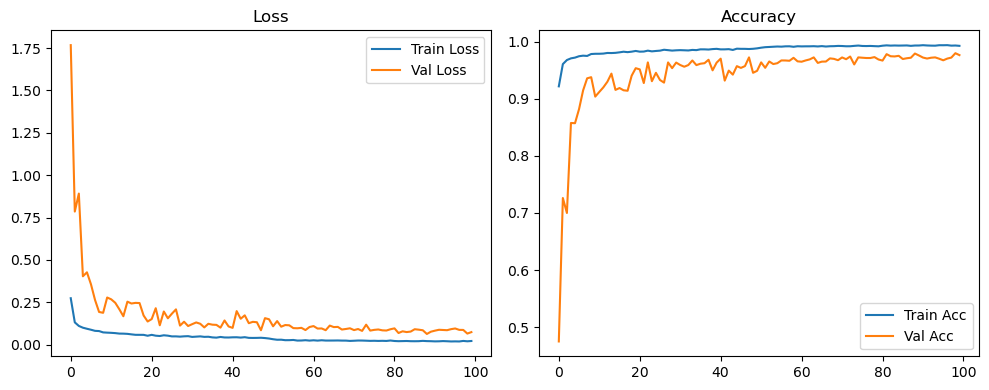

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1705, Acc: 0.9616 | Val Loss: 0.0655, Acc: 0.9811


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 0.0486, Acc: 0.9855


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9896 | Val Loss: 0.0483, Acc: 0.9857


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0559, Acc: 0.9822


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0565, Acc: 0.9832


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.0548, Acc: 0.9839


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0427, Acc: 0.9886


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0561, Acc: 0.9835


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0400, Acc: 0.9894


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.0479, Acc: 0.9869


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0518, Acc: 0.9858


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0493, Acc: 0.9871


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9976 | Val Loss: 0.0452, Acc: 0.9892


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0593, Acc: 0.9857


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0469, Acc: 0.9878


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0414, Acc: 0.9901


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0465, Acc: 0.9893


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0618, Acc: 0.9860


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0463, Acc: 0.9893


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0475, Acc: 0.9899


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0582, Acc: 0.9876


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0543, Acc: 0.9883


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0675, Acc: 0.9875


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0530, Acc: 0.9882


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0539, Acc: 0.9892


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0480, Acc: 0.9901


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0522, Acc: 0.9894


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0562, Acc: 0.9888


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0578, Acc: 0.9892


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0517, Acc: 0.9899


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0724, Acc: 0.9852


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0615, Acc: 0.9872


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0524, Acc: 0.9891


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0504, Acc: 0.9891


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0474, Acc: 0.9898


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0570, Acc: 0.9897


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0618, Acc: 0.9882


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0688, Acc: 0.9882


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0627, Acc: 0.9885


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0583, Acc: 0.9887


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0592, Acc: 0.9892


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0546, Acc: 0.9902


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0644, Acc: 0.9882


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0581, Acc: 0.9901


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0561, Acc: 0.9906


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0585, Acc: 0.9910


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0573, Acc: 0.9895


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0558, Acc: 0.9907


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0790, Acc: 0.9874


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9981 | Val Loss: 0.0590, Acc: 0.9884


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0604, Acc: 0.9895


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0610, Acc: 0.9892


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0480, Acc: 0.9913


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0522, Acc: 0.9907


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0574, Acc: 0.9906


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0756, Acc: 0.9880


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0731, Acc: 0.9894


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0695, Acc: 0.9894


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0641, Acc: 0.9901


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0656, Acc: 0.9890


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0600, Acc: 0.9897


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0570, Acc: 0.9900


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0580, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0643, Acc: 0.9899


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0759, Acc: 0.9876


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0623, Acc: 0.9903


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0735, Acc: 0.9895


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0632, Acc: 0.9900


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0717, Acc: 0.9884


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0636, Acc: 0.9898


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0584, Acc: 0.9906


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0665, Acc: 0.9901


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0606, Acc: 0.9911


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0595, Acc: 0.9912


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0679, Acc: 0.9890


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0698, Acc: 0.9903


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0656, Acc: 0.9911


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0673, Acc: 0.9901


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0680, Acc: 0.9896


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0573, Acc: 0.9906


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0558, Acc: 0.9912


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0626, Acc: 0.9909


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0541, Acc: 0.9922


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.0561, Acc: 0.9912


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0620, Acc: 0.9912


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0670, Acc: 0.9904


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0654, Acc: 0.9902


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0565, Acc: 0.9915


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0614, Acc: 0.9912


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0600, Acc: 0.9919


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0781, Acc: 0.9894


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0661, Acc: 0.9900


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0718, Acc: 0.9908


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0703, Acc: 0.9899


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0623, Acc: 0.9912


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0644, Acc: 0.9909


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0576, Acc: 0.9908


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0593, Acc: 0.9909


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0625, Acc: 0.9905


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0682, Acc: 0.9918


Final Test Loss: 0.0660 Accuracy: 0.9906


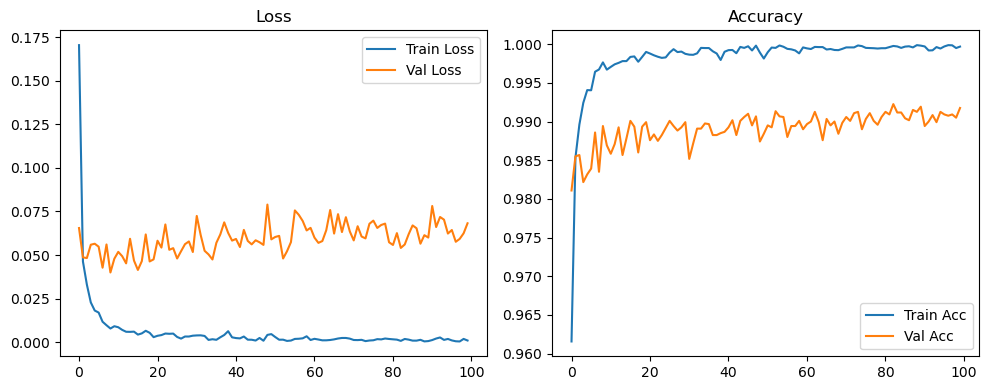

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1986, Acc: 0.9545 | Val Loss: 0.2514, Acc: 0.9191


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0666, Acc: 0.9799 | Val Loss: 0.0977, Acc: 0.9707


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9842 | Val Loss: 0.0843, Acc: 0.9739


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0546, Acc: 0.9832


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9882 | Val Loss: 0.0523, Acc: 0.9829


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9901 | Val Loss: 0.0612, Acc: 0.9801


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0457, Acc: 0.9852


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.0530, Acc: 0.9835


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9914 | Val Loss: 0.0379, Acc: 0.9892


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0462, Acc: 0.9874


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0554, Acc: 0.9823


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9928 | Val Loss: 0.0502, Acc: 0.9843


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0651, Acc: 0.9795


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0514, Acc: 0.9857


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0530, Acc: 0.9849


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9946 | Val Loss: 0.0546, Acc: 0.9838


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0531, Acc: 0.9836


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0549, Acc: 0.9850


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9946 | Val Loss: 0.0444, Acc: 0.9868


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9948 | Val Loss: 0.0484, Acc: 0.9857


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0375, Acc: 0.9897


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0569, Acc: 0.9833


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0459, Acc: 0.9879


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0504, Acc: 0.9866


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0453, Acc: 0.9878


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0428, Acc: 0.9877


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0365, Acc: 0.9892


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0378, Acc: 0.9894


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0406, Acc: 0.9881


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0451, Acc: 0.9877


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0426, Acc: 0.9886


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9964 | Val Loss: 0.0470, Acc: 0.9867


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0496, Acc: 0.9869


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0484, Acc: 0.9879


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0463, Acc: 0.9871


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0610, Acc: 0.9843


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0601, Acc: 0.9836


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0392, Acc: 0.9893


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0391, Acc: 0.9899


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0469, Acc: 0.9886


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0419, Acc: 0.9890


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0464, Acc: 0.9895


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0455, Acc: 0.9892


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0492, Acc: 0.9891


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0498, Acc: 0.9883


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0510, Acc: 0.9868


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0486, Acc: 0.9881


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0513, Acc: 0.9873


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.0483, Acc: 0.9882


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0464, Acc: 0.9892


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9973 | Val Loss: 0.0411, Acc: 0.9898


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0461, Acc: 0.9887


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0483, Acc: 0.9891


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0532, Acc: 0.9877


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0440, Acc: 0.9908


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0484, Acc: 0.9884


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0522, Acc: 0.9886


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0456, Acc: 0.9892


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0436, Acc: 0.9897


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0523, Acc: 0.9874


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0477, Acc: 0.9886


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0504, Acc: 0.9891


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0481, Acc: 0.9897


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0466, Acc: 0.9894


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0399, Acc: 0.9902


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0408, Acc: 0.9898


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0413, Acc: 0.9906


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0486, Acc: 0.9896


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0454, Acc: 0.9894


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.0453, Acc: 0.9898


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0431, Acc: 0.9910


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0392, Acc: 0.9910


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0440, Acc: 0.9890


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0551, Acc: 0.9872


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0558, Acc: 0.9878


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0465, Acc: 0.9898


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0493, Acc: 0.9892


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0411, Acc: 0.9902


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0464, Acc: 0.9898


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9982 | Val Loss: 0.0478, Acc: 0.9896


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0502, Acc: 0.9889


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0454, Acc: 0.9898


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0491, Acc: 0.9892


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0502, Acc: 0.9892


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0471, Acc: 0.9903


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0451, Acc: 0.9906


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0548, Acc: 0.9892


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0536, Acc: 0.9883


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0532, Acc: 0.9879


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0537, Acc: 0.9896


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0483, Acc: 0.9892


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0448, Acc: 0.9908


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0540, Acc: 0.9882


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0470, Acc: 0.9903


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0420, Acc: 0.9910


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0473, Acc: 0.9899


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0463, Acc: 0.9897


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0524, Acc: 0.9891


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0492, Acc: 0.9888


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0472, Acc: 0.9911


Final Test Loss: 0.0469 Accuracy: 0.9889


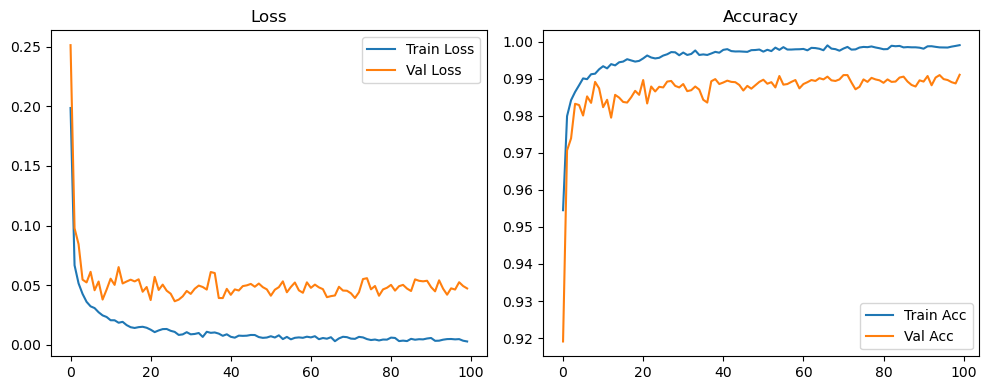

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2998, Acc: 0.9262 | Val Loss: 1.3861, Acc: 0.5458


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1295, Acc: 0.9621 | Val Loss: 0.7472, Acc: 0.7398


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1081, Acc: 0.9689 | Val Loss: 0.7730, Acc: 0.7234


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0975, Acc: 0.9717 | Val Loss: 0.6735, Acc: 0.7642


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0874, Acc: 0.9744 | Val Loss: 0.4526, Acc: 0.8391


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0852, Acc: 0.9745 | Val Loss: 0.3884, Acc: 0.8692


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9769 | Val Loss: 0.3820, Acc: 0.8598


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0784, Acc: 0.9762 | Val Loss: 0.5719, Acc: 0.8024


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9793 | Val Loss: 0.1910, Acc: 0.9384


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9792 | Val Loss: 0.2369, Acc: 0.9203


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9789 | Val Loss: 0.2948, Acc: 0.8987


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9803 | Val Loss: 0.3232, Acc: 0.8889


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9809 | Val Loss: 0.1919, Acc: 0.9358


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9818 | Val Loss: 0.2529, Acc: 0.9138


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9816 | Val Loss: 0.2242, Acc: 0.9219


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9823 | Val Loss: 0.2996, Acc: 0.8966


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9826 | Val Loss: 0.1650, Acc: 0.9463


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9830 | Val Loss: 0.2516, Acc: 0.9139


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9828 | Val Loss: 0.1955, Acc: 0.9307


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9839 | Val Loss: 0.1349, Acc: 0.9559


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9835 | Val Loss: 0.1336, Acc: 0.9573


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9846 | Val Loss: 0.2336, Acc: 0.9192


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9850 | Val Loss: 0.1967, Acc: 0.9330


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9853 | Val Loss: 0.2100, Acc: 0.9284


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9843 | Val Loss: 0.1982, Acc: 0.9313


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9855 | Val Loss: 0.1285, Acc: 0.9581


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9852 | Val Loss: 0.1714, Acc: 0.9413


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9868 | Val Loss: 0.1888, Acc: 0.9367


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.1706, Acc: 0.9453


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9861 | Val Loss: 0.1222, Acc: 0.9602


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9861 | Val Loss: 0.1549, Acc: 0.9467


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.2086, Acc: 0.9277


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.1378, Acc: 0.9533


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9855 | Val Loss: 0.1219, Acc: 0.9595


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9859 | Val Loss: 0.1212, Acc: 0.9616


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.1147, Acc: 0.9640


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9869 | Val Loss: 0.1206, Acc: 0.9599


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.1227, Acc: 0.9595


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9876 | Val Loss: 0.1368, Acc: 0.9535


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.1405, Acc: 0.9533


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.1727, Acc: 0.9433


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.1571, Acc: 0.9476


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.1009, Acc: 0.9677


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.1343, Acc: 0.9571


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1145, Acc: 0.9634


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9890 | Val Loss: 0.1355, Acc: 0.9557


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0971, Acc: 0.9695


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0917, Acc: 0.9700


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.1172, Acc: 0.9603


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9883 | Val Loss: 0.1227, Acc: 0.9595


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9878 | Val Loss: 0.0822, Acc: 0.9743


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.0988, Acc: 0.9672


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9892 | Val Loss: 0.1504, Acc: 0.9480


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0976, Acc: 0.9693


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.1108, Acc: 0.9631


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.1212, Acc: 0.9612


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.1061, Acc: 0.9665


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.0765, Acc: 0.9762


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.0997, Acc: 0.9681


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.0808, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.0802, Acc: 0.9763


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0798, Acc: 0.9762


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.1052, Acc: 0.9681


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.0835, Acc: 0.9738


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9895 | Val Loss: 0.1146, Acc: 0.9623


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9883 | Val Loss: 0.1040, Acc: 0.9673


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.0881, Acc: 0.9713


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9894 | Val Loss: 0.0775, Acc: 0.9757


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.0699, Acc: 0.9795


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.1078, Acc: 0.9648


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.0921, Acc: 0.9712


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9897 | Val Loss: 0.0946, Acc: 0.9708


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.0798, Acc: 0.9741


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.1231, Acc: 0.9597


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0830, Acc: 0.9739


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.1013, Acc: 0.9686


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.0996, Acc: 0.9681


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9902 | Val Loss: 0.0824, Acc: 0.9729


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.0845, Acc: 0.9739


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.1117, Acc: 0.9640


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1185, Acc: 0.9603


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.1227, Acc: 0.9590


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9907 | Val Loss: 0.0952, Acc: 0.9698


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1033, Acc: 0.9669


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0963, Acc: 0.9711


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9904 | Val Loss: 0.1044, Acc: 0.9647


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.0797, Acc: 0.9741


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.1015, Acc: 0.9677


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9907 | Val Loss: 0.0595, Acc: 0.9818


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0872, Acc: 0.9723


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0842, Acc: 0.9732


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9919 | Val Loss: 0.0661, Acc: 0.9804


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.0845, Acc: 0.9747


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.0835, Acc: 0.9727


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.0758, Acc: 0.9771


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0787, Acc: 0.9752


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0695, Acc: 0.9791


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.1120, Acc: 0.9632


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.0753, Acc: 0.9763


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0797, Acc: 0.9744


Final Test Loss: 0.0774 Accuracy: 0.9732


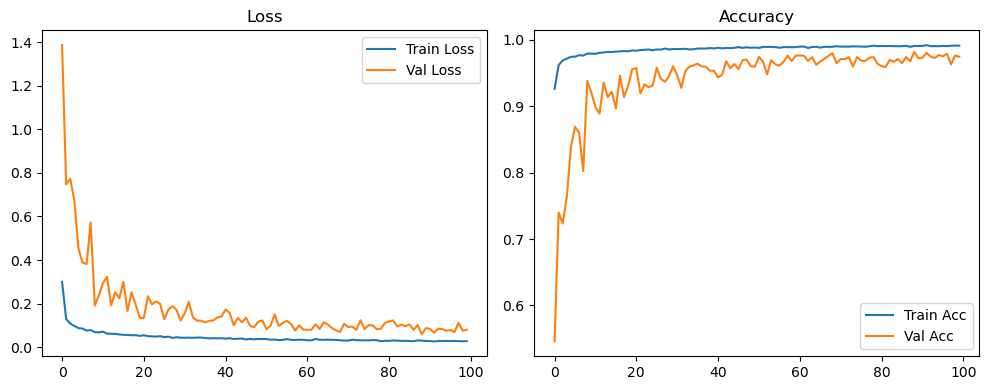

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1705, Acc: 0.9616 | Val Loss: 0.0655, Acc: 0.9811


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9853 | Val Loss: 0.0495, Acc: 0.9850


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0517, Acc: 0.9845


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.0625, Acc: 0.9789


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0474, Acc: 0.9864


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0395, Acc: 0.9868


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0401, Acc: 0.9888


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0409, Acc: 0.9882


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0518, Acc: 0.9861


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0530, Acc: 0.9858


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0470, Acc: 0.9872


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0503, Acc: 0.9882


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0492, Acc: 0.9890


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0498, Acc: 0.9888


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0583, Acc: 0.9861


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0467, Acc: 0.9902


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0472, Acc: 0.9892


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0395, Acc: 0.9906


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0580, Acc: 0.9855


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0593, Acc: 0.9869


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0504, Acc: 0.9887


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0654, Acc: 0.9854


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0507, Acc: 0.9884


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0491, Acc: 0.9893


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0511, Acc: 0.9899


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0476, Acc: 0.9900


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0590, Acc: 0.9880


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0517, Acc: 0.9897


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0634, Acc: 0.9868


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0549, Acc: 0.9895


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0474, Acc: 0.9902


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0540, Acc: 0.9882


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0468, Acc: 0.9897


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0604, Acc: 0.9881


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0598, Acc: 0.9883


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0632, Acc: 0.9881


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0608, Acc: 0.9885


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0576, Acc: 0.9886


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0641, Acc: 0.9885


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0550, Acc: 0.9904


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0567, Acc: 0.9894


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0537, Acc: 0.9898


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0550, Acc: 0.9899


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0526, Acc: 0.9902


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0594, Acc: 0.9889


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0737, Acc: 0.9865


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0551, Acc: 0.9898


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0719, Acc: 0.9884


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0585, Acc: 0.9887


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0681, Acc: 0.9888


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0539, Acc: 0.9908


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0525, Acc: 0.9913


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9910


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9912


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9914


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9912


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0530, Acc: 0.9913


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9917


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9920


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9908


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0546, Acc: 0.9907


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0518, Acc: 0.9908


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0552, Acc: 0.9904


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0547, Acc: 0.9911


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0560, Acc: 0.9914


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9907


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9917


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9922


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0636, Acc: 0.9902


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9900


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0574, Acc: 0.9905


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0654, Acc: 0.9911


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9913


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0636, Acc: 0.9909


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9916


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9925


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0551, Acc: 0.9919


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0605, Acc: 0.9915


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0595, Acc: 0.9910


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0588, Acc: 0.9916


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9920


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9916


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9916


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9914


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9909


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9912


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9912


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0568, Acc: 0.9921


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9912


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0574, Acc: 0.9913


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9921


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9912


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9916


Final Test Loss: 0.0550 Accuracy: 0.9914


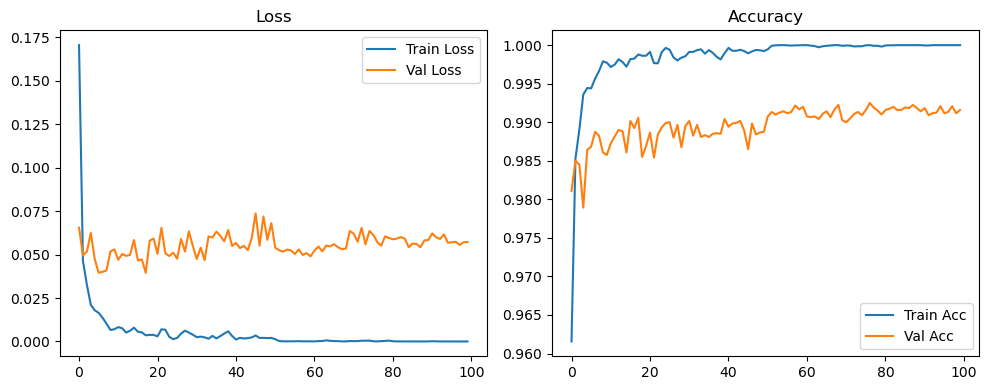

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1986, Acc: 0.9545 | Val Loss: 0.2514, Acc: 0.9191


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0666, Acc: 0.9799 | Val Loss: 0.0977, Acc: 0.9707


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9842 | Val Loss: 0.0843, Acc: 0.9739


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0546, Acc: 0.9832


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9882 | Val Loss: 0.0523, Acc: 0.9829


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9901 | Val Loss: 0.0612, Acc: 0.9801


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0479, Acc: 0.9857


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0438, Acc: 0.9876


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.0409, Acc: 0.9867


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.0535, Acc: 0.9829


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0384, Acc: 0.9882


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9927 | Val Loss: 0.0381, Acc: 0.9887


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0432, Acc: 0.9879


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0400, Acc: 0.9890


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0441, Acc: 0.9868


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9946 | Val Loss: 0.0563, Acc: 0.9838


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.0392, Acc: 0.9888


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0352, Acc: 0.9900


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.0478, Acc: 0.9871


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0520, Acc: 0.9843


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9946 | Val Loss: 0.0500, Acc: 0.9860


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0447, Acc: 0.9871


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0460, Acc: 0.9883


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0483, Acc: 0.9862


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0391, Acc: 0.9901


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0436, Acc: 0.9882


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0425, Acc: 0.9876


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0358, Acc: 0.9902


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0398, Acc: 0.9889


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0374, Acc: 0.9904


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0413, Acc: 0.9886


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0429, Acc: 0.9896


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0329, Acc: 0.9913


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0380, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0444, Acc: 0.9879


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0420, Acc: 0.9898


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0503, Acc: 0.9863


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0494, Acc: 0.9869


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0428, Acc: 0.9884


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0470, Acc: 0.9890


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0428, Acc: 0.9901


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0487, Acc: 0.9864


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0436, Acc: 0.9887


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0409, Acc: 0.9898


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0484, Acc: 0.9885


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0432, Acc: 0.9878


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0431, Acc: 0.9893


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0422, Acc: 0.9903


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0417, Acc: 0.9902


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0419, Acc: 0.9893


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0366, Acc: 0.9912


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0388, Acc: 0.9902


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0351, Acc: 0.9909


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0349, Acc: 0.9913


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0405, Acc: 0.9902


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0429, Acc: 0.9903


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0394, Acc: 0.9908


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0386, Acc: 0.9908


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0417, Acc: 0.9902


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0345, Acc: 0.9918


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0384, Acc: 0.9907


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0387, Acc: 0.9912


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0375, Acc: 0.9921


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0403, Acc: 0.9904


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0393, Acc: 0.9904


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0423, Acc: 0.9909


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9912


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0411, Acc: 0.9902


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0428, Acc: 0.9907


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0413, Acc: 0.9897


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0380, Acc: 0.9910


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9914


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0517, Acc: 0.9892


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0426, Acc: 0.9901


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0413, Acc: 0.9915


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0439, Acc: 0.9902


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0454, Acc: 0.9900


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0416, Acc: 0.9916


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0431, Acc: 0.9900


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0442, Acc: 0.9908


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0413, Acc: 0.9915


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0389, Acc: 0.9920


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0391, Acc: 0.9913


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0388, Acc: 0.9910


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0434, Acc: 0.9904


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0423, Acc: 0.9910


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9908


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0387, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0399, Acc: 0.9915


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0425, Acc: 0.9909


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0426, Acc: 0.9910


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0450, Acc: 0.9903


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0461, Acc: 0.9898


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0468, Acc: 0.9894


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0419, Acc: 0.9913


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0426, Acc: 0.9916


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0415, Acc: 0.9914


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0455, Acc: 0.9905


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0430, Acc: 0.9911


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0418, Acc: 0.9912


Final Test Loss: 0.0438 Accuracy: 0.9906


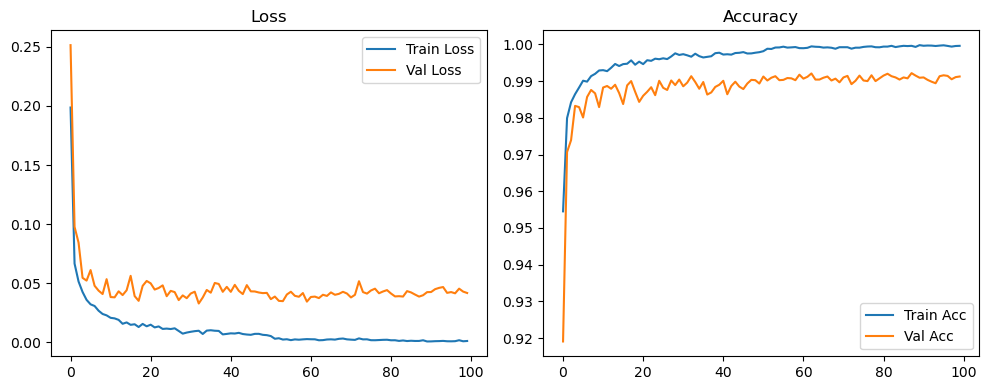

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2998, Acc: 0.9262 | Val Loss: 1.3861, Acc: 0.5458


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1295, Acc: 0.9621 | Val Loss: 0.7472, Acc: 0.7398


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1081, Acc: 0.9689 | Val Loss: 0.7730, Acc: 0.7234


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0979, Acc: 0.9715 | Val Loss: 0.5971, Acc: 0.7943


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0894, Acc: 0.9733 | Val Loss: 0.4203, Acc: 0.8512


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9743 | Val Loss: 0.3334, Acc: 0.8852


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9768 | Val Loss: 0.2835, Acc: 0.9024


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9764 | Val Loss: 0.3665, Acc: 0.8776


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9791 | Val Loss: 0.2128, Acc: 0.9295


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0713, Acc: 0.9791 | Val Loss: 0.2071, Acc: 0.9332


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9807 | Val Loss: 0.2076, Acc: 0.9309


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.2256, Acc: 0.9237


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9808 | Val Loss: 0.2192, Acc: 0.9235


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0606, Acc: 0.9811 | Val Loss: 0.1701, Acc: 0.9464


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9823 | Val Loss: 0.2887, Acc: 0.8985


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9833 | Val Loss: 0.2328, Acc: 0.9195


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9824 | Val Loss: 0.1652, Acc: 0.9454


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9829 | Val Loss: 0.2930, Acc: 0.8993


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9822 | Val Loss: 0.1422, Acc: 0.9527


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9845 | Val Loss: 0.1398, Acc: 0.9551


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9829 | Val Loss: 0.1617, Acc: 0.9453


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9850 | Val Loss: 0.2643, Acc: 0.9048


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9839 | Val Loss: 0.1142, Acc: 0.9622


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9850 | Val Loss: 0.1645, Acc: 0.9445


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9853 | Val Loss: 0.1817, Acc: 0.9371


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9854 | Val Loss: 0.1545, Acc: 0.9477


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9855 | Val Loss: 0.1223, Acc: 0.9595


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9857 | Val Loss: 0.1796, Acc: 0.9406


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9857 | Val Loss: 0.1593, Acc: 0.9487


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9856 | Val Loss: 0.1540, Acc: 0.9497


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9862 | Val Loss: 0.1499, Acc: 0.9499


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.1647, Acc: 0.9462


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9861 | Val Loss: 0.2145, Acc: 0.9267


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9862 | Val Loss: 0.1301, Acc: 0.9544


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9864 | Val Loss: 0.1800, Acc: 0.9403


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.1496, Acc: 0.9513


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9869 | Val Loss: 0.0948, Acc: 0.9699


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9873 | Val Loss: 0.1543, Acc: 0.9463


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9873 | Val Loss: 0.1442, Acc: 0.9532


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1651, Acc: 0.9452


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9876 | Val Loss: 0.1780, Acc: 0.9428


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9879 | Val Loss: 0.1807, Acc: 0.9395


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.1206, Acc: 0.9603


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9872 | Val Loss: 0.1451, Acc: 0.9514


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9881 | Val Loss: 0.1490, Acc: 0.9494


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.1160, Acc: 0.9623


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1069, Acc: 0.9661


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.1063, Acc: 0.9661


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9880 | Val Loss: 0.1386, Acc: 0.9537


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9887 | Val Loss: 0.1065, Acc: 0.9657


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.1219, Acc: 0.9590


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1189, Acc: 0.9595


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.1205, Acc: 0.9588


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1132, Acc: 0.9624


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.1145, Acc: 0.9628


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.1186, Acc: 0.9617


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.1057, Acc: 0.9637


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1518, Acc: 0.9480


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.1259, Acc: 0.9573


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.1026, Acc: 0.9660


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.1061, Acc: 0.9661


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.1011, Acc: 0.9668


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0901, Acc: 0.9721


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.0933, Acc: 0.9698


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9906 | Val Loss: 0.0989, Acc: 0.9686


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0979, Acc: 0.9688


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9906 | Val Loss: 0.1298, Acc: 0.9578


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1277, Acc: 0.9569


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0998, Acc: 0.9671


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.1039, Acc: 0.9642


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0869, Acc: 0.9717


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.0872, Acc: 0.9734


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.0921, Acc: 0.9696


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0876, Acc: 0.9718


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0777, Acc: 0.9744


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.0948, Acc: 0.9689


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0903, Acc: 0.9705


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0921, Acc: 0.9696


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0873, Acc: 0.9722


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1036, Acc: 0.9663


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.1104, Acc: 0.9635


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0945, Acc: 0.9681


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0979, Acc: 0.9670


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0958, Acc: 0.9677


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.0838, Acc: 0.9732


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.1039, Acc: 0.9654


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0922, Acc: 0.9711


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.1004, Acc: 0.9675


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0734, Acc: 0.9763


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0724, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0796, Acc: 0.9746


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0713, Acc: 0.9771


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0827, Acc: 0.9732


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0810, Acc: 0.9748


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9926 | Val Loss: 0.0915, Acc: 0.9706


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.0938, Acc: 0.9692


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0828, Acc: 0.9753


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1151, Acc: 0.9620


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9934 | Val Loss: 0.0778, Acc: 0.9752


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0743, Acc: 0.9772


Final Test Loss: 0.0716 Accuracy: 0.9777


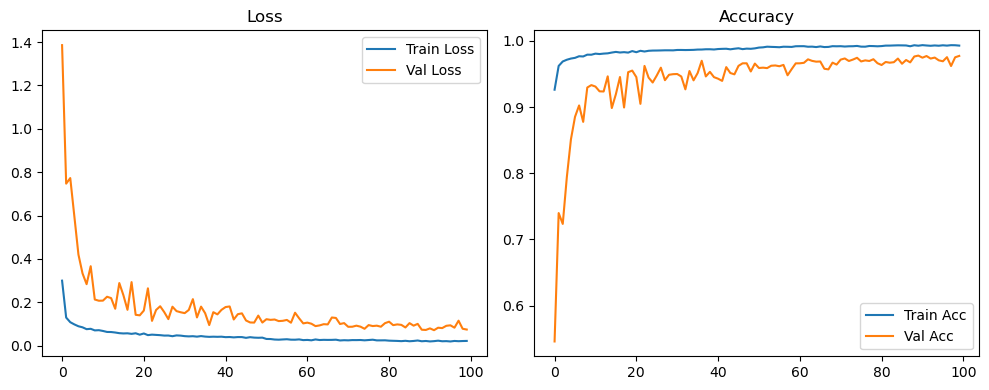

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2414, Acc: 0.9611 | Val Loss: 0.0666, Acc: 0.9832


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9866 | Val Loss: 0.0571, Acc: 0.9829


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9907 | Val Loss: 0.0444, Acc: 0.9871


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9935 | Val Loss: 0.0562, Acc: 0.9829


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9946 | Val Loss: 0.0377, Acc: 0.9885


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.0412, Acc: 0.9868


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.0417, Acc: 0.9874


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0440, Acc: 0.9876


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0633, Acc: 0.9812


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0555, Acc: 0.9848


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0486, Acc: 0.9865


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0418, Acc: 0.9878


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0450, Acc: 0.9879


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0470, Acc: 0.9872


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0467, Acc: 0.9872


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0394, Acc: 0.9890


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0516, Acc: 0.9858


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0443, Acc: 0.9882


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0423, Acc: 0.9885


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0710, Acc: 0.9821


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0546, Acc: 0.9859


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0545, Acc: 0.9871


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0475, Acc: 0.9884


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0467, Acc: 0.9894


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0618, Acc: 0.9866


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0712, Acc: 0.9834


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0602, Acc: 0.9854


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0461, Acc: 0.9895


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0491, Acc: 0.9882


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0494, Acc: 0.9881


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0490, Acc: 0.9898


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0510, Acc: 0.9888


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0507, Acc: 0.9891


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0497, Acc: 0.9890


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0544, Acc: 0.9888


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0496, Acc: 0.9885


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0502, Acc: 0.9882


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0522, Acc: 0.9884


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0583, Acc: 0.9864


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0478, Acc: 0.9895


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0529, Acc: 0.9894


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0649, Acc: 0.9868


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0676, Acc: 0.9864


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0529, Acc: 0.9892


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0538, Acc: 0.9884


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0508, Acc: 0.9892


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0499, Acc: 0.9902


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0552, Acc: 0.9888


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0584, Acc: 0.9890


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0485, Acc: 0.9905


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0499, Acc: 0.9898


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0564, Acc: 0.9902


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0499, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0480, Acc: 0.9904


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0501, Acc: 0.9908


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0713, Acc: 0.9862


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0610, Acc: 0.9890


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0545, Acc: 0.9892


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0540, Acc: 0.9891


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0467, Acc: 0.9906


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0464, Acc: 0.9909


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0605, Acc: 0.9889


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0547, Acc: 0.9899


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0496, Acc: 0.9895


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0542, Acc: 0.9895


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0577, Acc: 0.9900


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0660, Acc: 0.9882


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0653, Acc: 0.9869


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0592, Acc: 0.9893


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0523, Acc: 0.9897


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0555, Acc: 0.9894


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0541, Acc: 0.9904


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0814, Acc: 0.9848


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0670, Acc: 0.9879


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0667, Acc: 0.9877


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0567, Acc: 0.9892


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0569, Acc: 0.9891


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0606, Acc: 0.9891


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0660, Acc: 0.9881


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0647, Acc: 0.9877


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0545, Acc: 0.9892


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0564, Acc: 0.9899


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0535, Acc: 0.9902


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0616, Acc: 0.9898


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9899


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0740, Acc: 0.9874


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0596, Acc: 0.9897


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0593, Acc: 0.9885


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0611, Acc: 0.9887


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0636, Acc: 0.9888


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0615, Acc: 0.9897


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0656, Acc: 0.9888


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0590, Acc: 0.9908


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0533, Acc: 0.9904


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9908


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0683, Acc: 0.9891


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0611, Acc: 0.9898


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0618, Acc: 0.9895


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0574, Acc: 0.9902


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0540, Acc: 0.9908


Final Test Loss: 0.0513 Accuracy: 0.9896


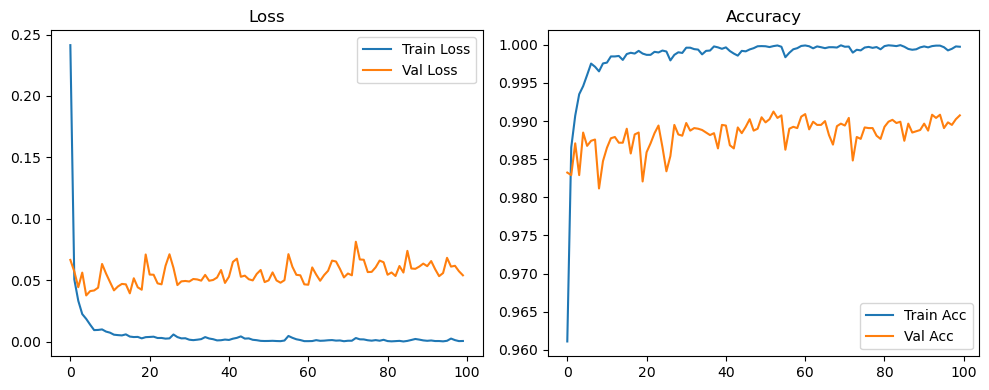

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2763, Acc: 0.9531 | Val Loss: 0.2306, Acc: 0.9437


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0686, Acc: 0.9812 | Val Loss: 0.0859, Acc: 0.9778


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9854 | Val Loss: 0.0945, Acc: 0.9729


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.0668, Acc: 0.9805


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9892 | Val Loss: 0.0604, Acc: 0.9820


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0833, Acc: 0.9742


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9912 | Val Loss: 0.0475, Acc: 0.9860


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.0499, Acc: 0.9842


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.0398, Acc: 0.9878


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.0538, Acc: 0.9828


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0398, Acc: 0.9873


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0494, Acc: 0.9849


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0450, Acc: 0.9871


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0492, Acc: 0.9852


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.0408, Acc: 0.9875


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0436, Acc: 0.9870


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0456, Acc: 0.9869


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0487, Acc: 0.9858


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0465, Acc: 0.9853


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0457, Acc: 0.9865


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0448, Acc: 0.9868


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9956 | Val Loss: 0.0562, Acc: 0.9839


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0541, Acc: 0.9843


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0484, Acc: 0.9865


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0482, Acc: 0.9862


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0479, Acc: 0.9859


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0475, Acc: 0.9868


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0399, Acc: 0.9886


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0472, Acc: 0.9874


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0356, Acc: 0.9904


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0437, Acc: 0.9888


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0344, Acc: 0.9911


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0496, Acc: 0.9862


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0585, Acc: 0.9856


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0399, Acc: 0.9899


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0487, Acc: 0.9875


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0441, Acc: 0.9894


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.0470, Acc: 0.9891


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0536, Acc: 0.9865


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0496, Acc: 0.9869


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0409, Acc: 0.9894


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.0455, Acc: 0.9879


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9971 | Val Loss: 0.0471, Acc: 0.9892


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0506, Acc: 0.9886


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0456, Acc: 0.9888


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0485, Acc: 0.9882


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0498, Acc: 0.9878


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0406, Acc: 0.9892


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0443, Acc: 0.9887


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0415, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0381, Acc: 0.9906


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0404, Acc: 0.9894


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0505, Acc: 0.9867


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0401, Acc: 0.9894


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0407, Acc: 0.9903


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0432, Acc: 0.9899


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0426, Acc: 0.9902


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0360, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0448, Acc: 0.9891


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0430, Acc: 0.9909


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.0499, Acc: 0.9871


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0446, Acc: 0.9896


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0428, Acc: 0.9898


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0452, Acc: 0.9898


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0599, Acc: 0.9853


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0472, Acc: 0.9893


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0499, Acc: 0.9886


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0422, Acc: 0.9902


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0439, Acc: 0.9900


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0396, Acc: 0.9904


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0412, Acc: 0.9908


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0436, Acc: 0.9898


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0483, Acc: 0.9898


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0641, Acc: 0.9867


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9982 | Val Loss: 0.0473, Acc: 0.9892


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0411, Acc: 0.9915


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0383, Acc: 0.9914


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0386, Acc: 0.9902


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0421, Acc: 0.9905


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0489, Acc: 0.9898


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0440, Acc: 0.9912


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0404, Acc: 0.9911


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9980 | Val Loss: 0.0466, Acc: 0.9900


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0437, Acc: 0.9902


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0431, Acc: 0.9903


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0403, Acc: 0.9908


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0447, Acc: 0.9908


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0461, Acc: 0.9908


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0429, Acc: 0.9910


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0485, Acc: 0.9897


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0435, Acc: 0.9909


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0492, Acc: 0.9892


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0458, Acc: 0.9896


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0478, Acc: 0.9892


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0485, Acc: 0.9900


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0494, Acc: 0.9897


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0512, Acc: 0.9898


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0565, Acc: 0.9881


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0479, Acc: 0.9902


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0495, Acc: 0.9889


Final Test Loss: 0.0469 Accuracy: 0.9871


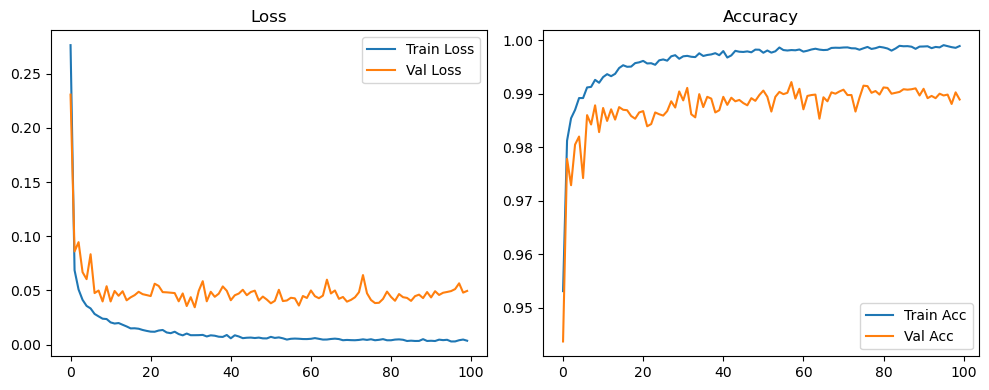

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3985, Acc: 0.9209 | Val Loss: 1.3854, Acc: 0.4813


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1384, Acc: 0.9631 | Val Loss: 0.8393, Acc: 0.7049


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1146, Acc: 0.9682 | Val Loss: 0.8714, Acc: 0.6740


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0991, Acc: 0.9716 | Val Loss: 0.6135, Acc: 0.7740


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0911, Acc: 0.9744 | Val Loss: 0.3172, Acc: 0.8961


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0874, Acc: 0.9745 | Val Loss: 0.3235, Acc: 0.8972


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0777, Acc: 0.9776 | Val Loss: 0.3065, Acc: 0.8978


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0751, Acc: 0.9779 | Val Loss: 0.3945, Acc: 0.8621


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0717, Acc: 0.9784 | Val Loss: 0.2214, Acc: 0.9290


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0697, Acc: 0.9795 | Val Loss: 0.2339, Acc: 0.9253


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0672, Acc: 0.9802 | Val Loss: 0.2669, Acc: 0.9094


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0654, Acc: 0.9801 | Val Loss: 0.1951, Acc: 0.9396


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9815 | Val Loss: 0.2141, Acc: 0.9326


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0623, Acc: 0.9815 | Val Loss: 0.1877, Acc: 0.9403


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0580, Acc: 0.9822 | Val Loss: 0.2238, Acc: 0.9277


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0586, Acc: 0.9819 | Val Loss: 0.2488, Acc: 0.9167


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9845 | Val Loss: 0.1341, Acc: 0.9583


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9832 | Val Loss: 0.1786, Acc: 0.9418


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 0.1561, Acc: 0.9462


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9837 | Val Loss: 0.1270, Acc: 0.9612


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9839 | Val Loss: 0.1442, Acc: 0.9537


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9836 | Val Loss: 0.2205, Acc: 0.9268


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9843 | Val Loss: 0.1132, Acc: 0.9646


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.1969, Acc: 0.9320


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9855 | Val Loss: 0.2157, Acc: 0.9285


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9852 | Val Loss: 0.1475, Acc: 0.9520


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9846 | Val Loss: 0.1204, Acc: 0.9599


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.1535, Acc: 0.9478


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9856 | Val Loss: 0.1458, Acc: 0.9516


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.1138, Acc: 0.9639


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9862 | Val Loss: 0.1589, Acc: 0.9470


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9861 | Val Loss: 0.1431, Acc: 0.9528


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9865 | Val Loss: 0.1066, Acc: 0.9667


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.0952, Acc: 0.9700


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 0.0955, Acc: 0.9698


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9870 | Val Loss: 0.1505, Acc: 0.9497


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9885 | Val Loss: 0.1032, Acc: 0.9669


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.1112, Acc: 0.9653


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.0930, Acc: 0.9701


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 0.1136, Acc: 0.9646


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.1028, Acc: 0.9659


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.1110, Acc: 0.9661


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9877 | Val Loss: 0.1280, Acc: 0.9578


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0986, Acc: 0.9687


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9883 | Val Loss: 0.0887, Acc: 0.9725


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9891 | Val Loss: 0.0954, Acc: 0.9700


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.1121, Acc: 0.9637


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9885 | Val Loss: 0.1048, Acc: 0.9663


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9883 | Val Loss: 0.1457, Acc: 0.9520


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9896 | Val Loss: 0.1067, Acc: 0.9643


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9892 | Val Loss: 0.1078, Acc: 0.9633


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.1057, Acc: 0.9668


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9892 | Val Loss: 0.0881, Acc: 0.9726


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9887 | Val Loss: 0.0903, Acc: 0.9708


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9884 | Val Loss: 0.1138, Acc: 0.9601


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9895 | Val Loss: 0.0978, Acc: 0.9702


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.1067, Acc: 0.9651


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.0901, Acc: 0.9714


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9890 | Val Loss: 0.0947, Acc: 0.9697


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.0843, Acc: 0.9724


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0904, Acc: 0.9729


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.0823, Acc: 0.9732


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9894 | Val Loss: 0.0840, Acc: 0.9738


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0655, Acc: 0.9797


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9896 | Val Loss: 0.0916, Acc: 0.9727


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.0951, Acc: 0.9707


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.0819, Acc: 0.9754


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0968, Acc: 0.9702


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.0822, Acc: 0.9754


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0723, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.0732, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9906 | Val Loss: 0.0905, Acc: 0.9718


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9901 | Val Loss: 0.0734, Acc: 0.9770


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.0767, Acc: 0.9758


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0801, Acc: 0.9751


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.0910, Acc: 0.9697


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0871, Acc: 0.9722


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0788, Acc: 0.9751


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.0665, Acc: 0.9801


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.1091, Acc: 0.9619


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.0826, Acc: 0.9738


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.1048, Acc: 0.9652


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.1057, Acc: 0.9649


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.0848, Acc: 0.9725


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0862, Acc: 0.9720


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0817, Acc: 0.9733


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9903 | Val Loss: 0.0902, Acc: 0.9719


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0925, Acc: 0.9700


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0770, Acc: 0.9762


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.0939, Acc: 0.9698


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9903 | Val Loss: 0.1032, Acc: 0.9658


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.0867, Acc: 0.9729


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.0787, Acc: 0.9743


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0795, Acc: 0.9740


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0791, Acc: 0.9747


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0826, Acc: 0.9745


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0979, Acc: 0.9681


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.0859, Acc: 0.9722


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0758, Acc: 0.9761


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0697, Acc: 0.9782


Final Test Loss: 0.0676 Accuracy: 0.9785


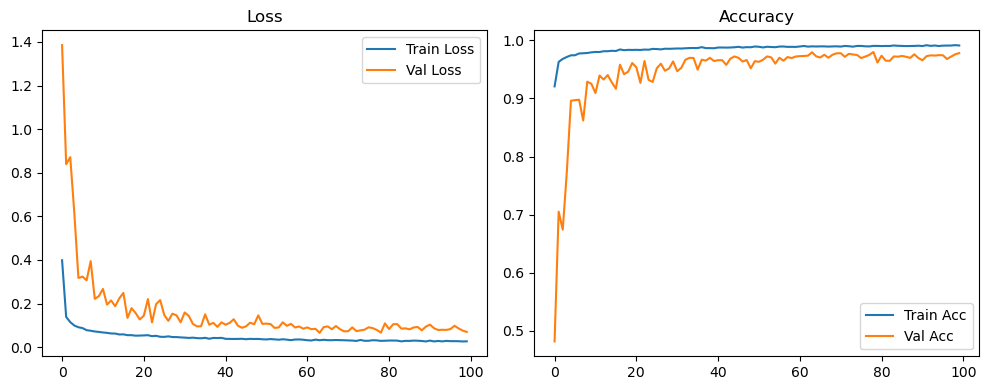

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3506, Acc: 0.9561 | Val Loss: 0.0972, Acc: 0.9827


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9858 | Val Loss: 0.0599, Acc: 0.9865


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9904 | Val Loss: 0.0547, Acc: 0.9858


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9931 | Val Loss: 0.0489, Acc: 0.9861


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9952 | Val Loss: 0.0422, Acc: 0.9881


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9961 | Val Loss: 0.0446, Acc: 0.9868


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9972 | Val Loss: 0.0422, Acc: 0.9872


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9975 | Val Loss: 0.0427, Acc: 0.9869


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.0494, Acc: 0.9847


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9985 | Val Loss: 0.0440, Acc: 0.9870


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9983 | Val Loss: 0.0370, Acc: 0.9895


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9990 | Val Loss: 0.0451, Acc: 0.9867


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9992 | Val Loss: 0.0437, Acc: 0.9879


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.0438, Acc: 0.9876


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.0507, Acc: 0.9848


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.0441, Acc: 0.9882


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0485, Acc: 0.9874


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0496, Acc: 0.9862


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0486, Acc: 0.9859


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9995 | Val Loss: 0.0417, Acc: 0.9877


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0459, Acc: 0.9869


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0445, Acc: 0.9882


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0482, Acc: 0.9875


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0479, Acc: 0.9874


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0448, Acc: 0.9874


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0494, Acc: 0.9870


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0599, Acc: 0.9842


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0435, Acc: 0.9892


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0499, Acc: 0.9882


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0467, Acc: 0.9883


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.0451, Acc: 0.9891


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0489, Acc: 0.9892


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0481, Acc: 0.9867


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0643, Acc: 0.9844


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0575, Acc: 0.9872


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9891


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0437, Acc: 0.9892


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0555, Acc: 0.9877


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0505, Acc: 0.9881


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0515, Acc: 0.9881


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0457, Acc: 0.9892


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0439, Acc: 0.9893


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0492, Acc: 0.9888


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0523, Acc: 0.9885


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0533, Acc: 0.9878


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0660, Acc: 0.9851


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0537, Acc: 0.9882


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0493, Acc: 0.9888


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0598, Acc: 0.9871


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0512, Acc: 0.9879


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0556, Acc: 0.9878


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0521, Acc: 0.9889


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0472, Acc: 0.9895


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0539, Acc: 0.9881


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0547, Acc: 0.9883


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0575, Acc: 0.9863


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0580, Acc: 0.9870


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0538, Acc: 0.9882


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0526, Acc: 0.9892


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0503, Acc: 0.9892


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0484, Acc: 0.9901


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0485, Acc: 0.9891


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0507, Acc: 0.9891


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0557, Acc: 0.9880


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9901


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9905


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9890


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9891


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0630, Acc: 0.9869


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0659, Acc: 0.9868


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0602, Acc: 0.9882


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0574, Acc: 0.9880


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0565, Acc: 0.9877


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.0561, Acc: 0.9882


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0533, Acc: 0.9891


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0512, Acc: 0.9888


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0613, Acc: 0.9882


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0559, Acc: 0.9885


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0610, Acc: 0.9866


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0556, Acc: 0.9888


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0562, Acc: 0.9888


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0519, Acc: 0.9894


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0522, Acc: 0.9896


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0481, Acc: 0.9898


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0667, Acc: 0.9863


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0493, Acc: 0.9902


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0530, Acc: 0.9893


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9902


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9901


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9905


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9907


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0567, Acc: 0.9884


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0618, Acc: 0.9879


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0633, Acc: 0.9874


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0640, Acc: 0.9882


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9884


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0587, Acc: 0.9888


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0517, Acc: 0.9904


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0653, Acc: 0.9870


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0608, Acc: 0.9887


Final Test Loss: 0.0522 Accuracy: 0.9896


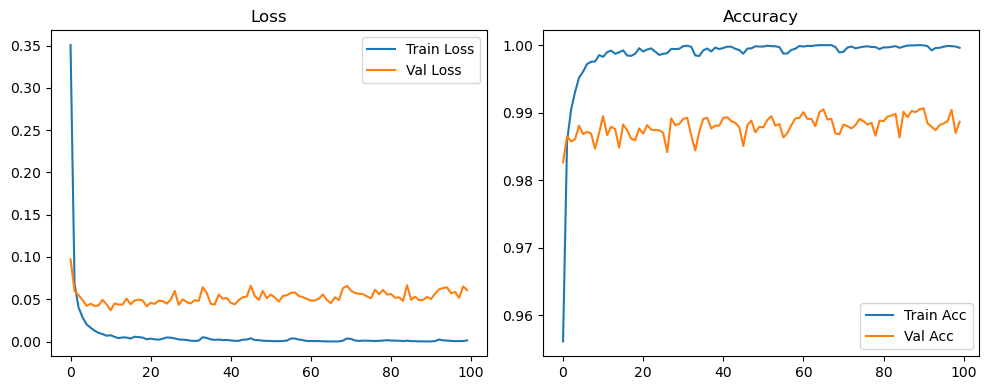

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3988, Acc: 0.9453 | Val Loss: 0.2641, Acc: 0.9567


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0887, Acc: 0.9812 | Val Loss: 0.1270, Acc: 0.9749


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9850 | Val Loss: 0.1041, Acc: 0.9745


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9875 | Val Loss: 0.0817, Acc: 0.9794


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9889 | Val Loss: 0.0704, Acc: 0.9802


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9899 | Val Loss: 0.0645, Acc: 0.9835


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9905 | Val Loss: 0.0559, Acc: 0.9850


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9911 | Val Loss: 0.0531, Acc: 0.9855


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9925 | Val Loss: 0.0497, Acc: 0.9853


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9927 | Val Loss: 0.0574, Acc: 0.9828


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.0540, Acc: 0.9844


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0422, Acc: 0.9872


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0455, Acc: 0.9858


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0445, Acc: 0.9866


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0391, Acc: 0.9878


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0592, Acc: 0.9819


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0501, Acc: 0.9852


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0398, Acc: 0.9875


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0454, Acc: 0.9868


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0519, Acc: 0.9848


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0408, Acc: 0.9866


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0591, Acc: 0.9826


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0548, Acc: 0.9837


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0412, Acc: 0.9876


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0418, Acc: 0.9881


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0436, Acc: 0.9872


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0482, Acc: 0.9852


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0431, Acc: 0.9868


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0499, Acc: 0.9849


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0403, Acc: 0.9888


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.0478, Acc: 0.9862


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0457, Acc: 0.9880


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0448, Acc: 0.9874


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0383, Acc: 0.9891


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0405, Acc: 0.9890


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0486, Acc: 0.9860


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0345, Acc: 0.9908


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0414, Acc: 0.9881


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0551, Acc: 0.9858


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0510, Acc: 0.9858


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.0404, Acc: 0.9892


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0443, Acc: 0.9879


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0477, Acc: 0.9876


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0429, Acc: 0.9891


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0487, Acc: 0.9867


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0525, Acc: 0.9862


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0471, Acc: 0.9881


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0449, Acc: 0.9878


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0453, Acc: 0.9879


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0355, Acc: 0.9908


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0493, Acc: 0.9863


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0466, Acc: 0.9872


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0402, Acc: 0.9892


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0418, Acc: 0.9890


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0384, Acc: 0.9899


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.0458, Acc: 0.9883


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0373, Acc: 0.9900


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0425, Acc: 0.9894


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0388, Acc: 0.9898


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0448, Acc: 0.9891


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0451, Acc: 0.9893


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0384, Acc: 0.9902


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.0427, Acc: 0.9895


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0445, Acc: 0.9899


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0480, Acc: 0.9882


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0456, Acc: 0.9886


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0480, Acc: 0.9887


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0417, Acc: 0.9883


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0372, Acc: 0.9908


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0404, Acc: 0.9902


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0429, Acc: 0.9888


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0424, Acc: 0.9889


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0439, Acc: 0.9892


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0455, Acc: 0.9880


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0412, Acc: 0.9902


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0402, Acc: 0.9904


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0441, Acc: 0.9900


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0386, Acc: 0.9899


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0420, Acc: 0.9895


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0518, Acc: 0.9873


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0442, Acc: 0.9888


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9982 | Val Loss: 0.0472, Acc: 0.9883


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0387, Acc: 0.9900


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0438, Acc: 0.9888


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0408, Acc: 0.9898


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0427, Acc: 0.9897


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0411, Acc: 0.9912


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0434, Acc: 0.9898


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0415, Acc: 0.9908


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0453, Acc: 0.9900


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0427, Acc: 0.9900


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0433, Acc: 0.9885


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0400, Acc: 0.9907


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0447, Acc: 0.9880


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0452, Acc: 0.9881


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0406, Acc: 0.9906


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0468, Acc: 0.9897


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0454, Acc: 0.9896


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0518, Acc: 0.9878


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0421, Acc: 0.9906


Final Test Loss: 0.0443 Accuracy: 0.9875


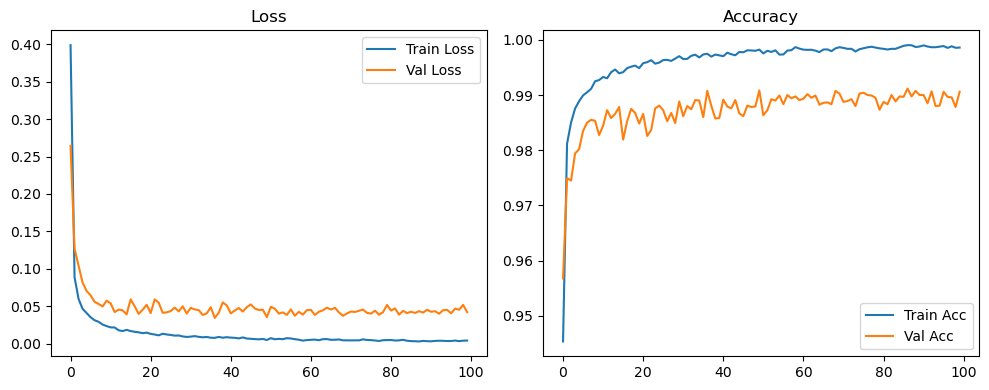

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5542, Acc: 0.9049 | Val Loss: 1.5402, Acc: 0.3568


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1734, Acc: 0.9619 | Val Loss: 0.9809, Acc: 0.6475


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1301, Acc: 0.9671 | Val Loss: 1.0587, Acc: 0.5819


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1106, Acc: 0.9708 | Val Loss: 0.6947, Acc: 0.7392


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0992, Acc: 0.9730 | Val Loss: 0.3894, Acc: 0.8721


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0931, Acc: 0.9734 | Val Loss: 0.4352, Acc: 0.8478


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0859, Acc: 0.9765 | Val Loss: 0.4139, Acc: 0.8574


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0818, Acc: 0.9766 | Val Loss: 0.4073, Acc: 0.8602


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0766, Acc: 0.9780 | Val Loss: 0.2789, Acc: 0.9079


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0748, Acc: 0.9780 | Val Loss: 0.3172, Acc: 0.8950


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9792 | Val Loss: 0.3672, Acc: 0.8759


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0689, Acc: 0.9798 | Val Loss: 0.2856, Acc: 0.9068


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0650, Acc: 0.9806 | Val Loss: 0.2430, Acc: 0.9209


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0667, Acc: 0.9804 | Val Loss: 0.2395, Acc: 0.9207


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0623, Acc: 0.9811 | Val Loss: 0.2682, Acc: 0.9087


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9823 | Val Loss: 0.3053, Acc: 0.8976


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9826 | Val Loss: 0.2029, Acc: 0.9323


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0557, Acc: 0.9835 | Val Loss: 0.2210, Acc: 0.9259


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0559, Acc: 0.9833 | Val Loss: 0.1746, Acc: 0.9444


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9833 | Val Loss: 0.1566, Acc: 0.9507


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0579, Acc: 0.9825 | Val Loss: 0.1924, Acc: 0.9372


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9825 | Val Loss: 0.2517, Acc: 0.9125


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0521, Acc: 0.9846 | Val Loss: 0.1273, Acc: 0.9612


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9839 | Val Loss: 0.1600, Acc: 0.9482


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9839 | Val Loss: 0.1787, Acc: 0.9433


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9848 | Val Loss: 0.1654, Acc: 0.9464


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0499, Acc: 0.9851 | Val Loss: 0.1840, Acc: 0.9372


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9844 | Val Loss: 0.1505, Acc: 0.9521


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.1627, Acc: 0.9486


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9858 | Val Loss: 0.1452, Acc: 0.9537


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9853 | Val Loss: 0.1340, Acc: 0.9561


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.1415, Acc: 0.9552


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.1334, Acc: 0.9588


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9869 | Val Loss: 0.1160, Acc: 0.9626


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9859 | Val Loss: 0.1252, Acc: 0.9602


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9873 | Val Loss: 0.1915, Acc: 0.9379


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9861 | Val Loss: 0.1279, Acc: 0.9587


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.1225, Acc: 0.9626


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9864 | Val Loss: 0.1247, Acc: 0.9600


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9868 | Val Loss: 0.1257, Acc: 0.9605


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9870 | Val Loss: 0.1118, Acc: 0.9646


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9880 | Val Loss: 0.1816, Acc: 0.9407


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.1367, Acc: 0.9566


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.1029, Acc: 0.9686


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9878 | Val Loss: 0.1121, Acc: 0.9645


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.1013, Acc: 0.9681


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9875 | Val Loss: 0.1151, Acc: 0.9648


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9881 | Val Loss: 0.1391, Acc: 0.9547


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1230, Acc: 0.9615


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9885 | Val Loss: 0.1011, Acc: 0.9681


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9878 | Val Loss: 0.1284, Acc: 0.9578


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9877 | Val Loss: 0.1131, Acc: 0.9652


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9883 | Val Loss: 0.1206, Acc: 0.9622


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.1201, Acc: 0.9610


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9894 | Val Loss: 0.1377, Acc: 0.9523


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.1019, Acc: 0.9679


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.1130, Acc: 0.9636


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.1031, Acc: 0.9679


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9886 | Val Loss: 0.0966, Acc: 0.9684


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.0935, Acc: 0.9699


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9890 | Val Loss: 0.1248, Acc: 0.9604


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0909, Acc: 0.9721


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9895 | Val Loss: 0.0985, Acc: 0.9693


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.0840, Acc: 0.9730


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9895 | Val Loss: 0.1013, Acc: 0.9683


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9896 | Val Loss: 0.1216, Acc: 0.9618


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9896 | Val Loss: 0.1092, Acc: 0.9657


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 0.1097, Acc: 0.9661


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.1012, Acc: 0.9672


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0810, Acc: 0.9756


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0825, Acc: 0.9749


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.0809, Acc: 0.9765


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.0863, Acc: 0.9718


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.1120, Acc: 0.9656


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0911, Acc: 0.9713


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0884, Acc: 0.9716


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.0880, Acc: 0.9718


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.0792, Acc: 0.9757


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0777, Acc: 0.9771


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.1067, Acc: 0.9651


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.1017, Acc: 0.9683


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0848, Acc: 0.9722


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.0766, Acc: 0.9765


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9906 | Val Loss: 0.0903, Acc: 0.9712


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0718, Acc: 0.9785


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.0862, Acc: 0.9718


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.0987, Acc: 0.9679


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.0860, Acc: 0.9735


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9902 | Val Loss: 0.0760, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0920, Acc: 0.9721


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.1029, Acc: 0.9659


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9901 | Val Loss: 0.0742, Acc: 0.9759


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0814, Acc: 0.9748


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.0813, Acc: 0.9728


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.0838, Acc: 0.9738


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0828, Acc: 0.9748


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0805, Acc: 0.9759


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0888, Acc: 0.9716


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0740, Acc: 0.9767


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9906 | Val Loss: 0.0884, Acc: 0.9722


Final Test Loss: 0.0863 Accuracy: 0.9725


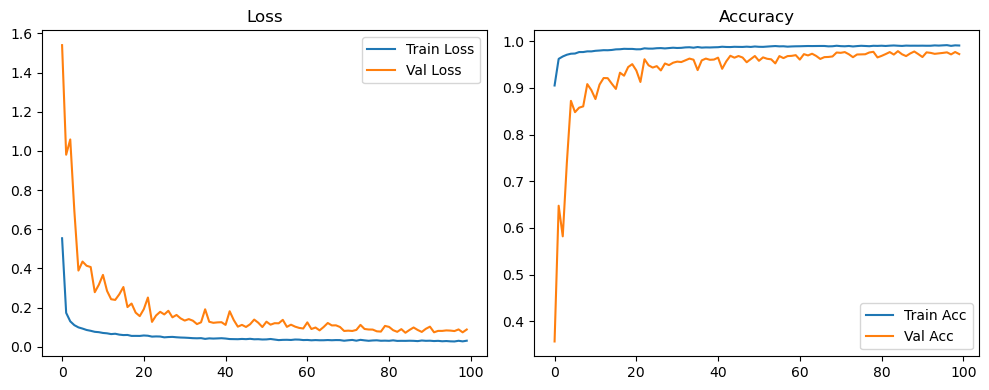

🏆 Best Config: batch128_lr0.005_0.002_0.001_dp0.0 Accuracy: 0.9926


In [8]:
root_path = "TCV_4bit_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)